In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *
import torch

/home/du0/20CS30037/miniconda3/envs/gnn_inter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MUTAGENICITY DATASET

In [3]:
global_seed = 200
dataset = MutagenicityDataset(seed=global_seed)

Processing...
Done!


In [4]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)

model.load_state_dict(torch.load('ckpts/mutagen_hd_64_epochs_128.pt'))

<All keys matched successfully>

In [5]:
dataset.evaluate_model(model)

/home/du0/20CS30037/miniconda3/envs/gnn_inter/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


class idx: 0, class: mutagen, f1: 0.8795589208602905
class idx: 1, class: nonmutagen, f1: 0.8564931750297546


{'mutagen': 0.8795589208602905, 'nonmutagen': 0.8564931750297546}

In [6]:
mean_embeds = dataset.mean_embeddings(model)

In [7]:
trainer = {}
sampler = {}

# Mutagen Class (Class 0)

In [8]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=4),
        dict(key="omega", criterion=NormPenalty(order=2), weight=4),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=30, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [9]:
trainer[cls_idx].train(1000)

  0%|          | 1/1000 [00:02<46:37,  2.80s/it, size=100, bpw=0.95, mutagen=-15.3, nonmutagen=19.1]

iteration=0, loss=3818.60, size=100.24388122558594, scores={'mutagen': -15.305439949035645, 'nonmutagen': 19.057573318481445}


  0%|          | 2/1000 [00:04<35:46,  2.15s/it, size=82.3, bpw=0.902, mutagen=-10.7, nonmutagen=12.1]

iteration=1, loss=36930.98, size=82.32586669921875, scores={'mutagen': -10.701292991638184, 'nonmutagen': 12.110894203186035}


  0%|          | 3/1000 [00:05<29:56,  1.80s/it, size=88.1, bpw=0.857, mutagen=-2.98, nonmutagen=2.21]

iteration=2, loss=35337.50, size=88.10104370117188, scores={'mutagen': -2.9808573722839355, 'nonmutagen': 2.211650848388672}


  0%|          | 4/1000 [00:07<29:23,  1.77s/it, size=81.2, bpw=0.815, mutagen=-4.85, nonmutagen=5.3] 

iteration=3, loss=32837.87, size=81.21378326416016, scores={'mutagen': -4.847827911376953, 'nonmutagen': 5.299211025238037}


  0%|          | 5/1000 [00:09<28:29,  1.72s/it, size=85.1, bpw=0.774, mutagen=-6.62, nonmutagen=7.38]

iteration=4, loss=30009.80, size=85.08190155029297, scores={'mutagen': -6.623736381530762, 'nonmutagen': 7.3767008781433105}


  1%|          | 6/1000 [00:11<28:55,  1.75s/it, size=81.6, bpw=0.735, mutagen=-6.88, nonmutagen=7.83]

iteration=5, loss=29517.54, size=81.55642700195312, scores={'mutagen': -6.882176399230957, 'nonmutagen': 7.82896089553833}


  1%|          | 7/1000 [00:12<26:43,  1.61s/it, size=79.4, bpw=0.698, mutagen=-5.95, nonmutagen=5.8] 

iteration=6, loss=31171.43, size=79.40324401855469, scores={'mutagen': -5.950875282287598, 'nonmutagen': 5.802121639251709}


  1%|          | 8/1000 [00:13<25:17,  1.53s/it, size=70.7, bpw=0.663, mutagen=-7.99, nonmutagen=8.57]

iteration=7, loss=30484.88, size=70.71050262451172, scores={'mutagen': -7.987096786499023, 'nonmutagen': 8.568467140197754}


  1%|          | 9/1000 [00:15<24:10,  1.46s/it, size=78.2, bpw=0.63, mutagen=-7.64, nonmutagen=7.82] 

iteration=8, loss=29381.14, size=78.23287963867188, scores={'mutagen': -7.635950565338135, 'nonmutagen': 7.819355010986328}


  1%|          | 10/1000 [00:16<25:13,  1.53s/it, size=70.8, bpw=0.599, mutagen=-7.88, nonmutagen=7.95]

iteration=9, loss=28301.89, size=70.80265808105469, scores={'mutagen': -7.8836445808410645, 'nonmutagen': 7.95348596572876}


  1%|          | 11/1000 [00:18<24:22,  1.48s/it, size=80.5, bpw=0.569, mutagen=-7.51, nonmutagen=7.23]

iteration=10, loss=26134.40, size=80.54607391357422, scores={'mutagen': -7.513516902923584, 'nonmutagen': 7.227230072021484}


  1%|          | 12/1000 [00:19<24:52,  1.51s/it, size=77.7, bpw=0.54, mutagen=-6.86, nonmutagen=6.7]  

iteration=11, loss=23714.30, size=77.74105072021484, scores={'mutagen': -6.862493991851807, 'nonmutagen': 6.698770999908447}


  1%|▏         | 13/1000 [00:21<24:04,  1.46s/it, size=78.9, bpw=0.513, mutagen=-4.03, nonmutagen=2.99]

iteration=12, loss=23923.00, size=78.87308502197266, scores={'mutagen': -4.030573844909668, 'nonmutagen': 2.993947982788086}


  1%|▏         | 14/1000 [00:22<23:16,  1.42s/it, size=77.1, bpw=0.488, mutagen=-4.58, nonmutagen=3.91]

iteration=13, loss=22513.34, size=77.11231994628906, scores={'mutagen': -4.578277587890625, 'nonmutagen': 3.9077632427215576}


  2%|▏         | 15/1000 [00:23<24:02,  1.46s/it, size=78.1, bpw=0.463, mutagen=-4.62, nonmutagen=4.01]

iteration=14, loss=21590.48, size=78.12113952636719, scores={'mutagen': -4.623144149780273, 'nonmutagen': 4.01322078704834}


  2%|▏         | 16/1000 [00:25<24:25,  1.49s/it, size=77.3, bpw=0.44, mutagen=-4.51, nonmutagen=3.78] 

iteration=15, loss=21797.42, size=77.257568359375, scores={'mutagen': -4.511819362640381, 'nonmutagen': 3.7847306728363037}


  2%|▏         | 17/1000 [00:26<23:35,  1.44s/it, size=88.5, bpw=0.418, mutagen=-4.99, nonmutagen=4.32]

iteration=16, loss=21648.33, size=88.53587341308594, scores={'mutagen': -4.988035678863525, 'nonmutagen': 4.317268371582031}


  2%|▏         | 18/1000 [00:28<24:06,  1.47s/it, size=84, bpw=0.397, mutagen=-4.88, nonmutagen=4.43]  

iteration=17, loss=21118.96, size=84.03175354003906, scores={'mutagen': -4.877159595489502, 'nonmutagen': 4.433859348297119}


  2%|▏         | 19/1000 [00:29<23:17,  1.42s/it, size=89, bpw=0.377, mutagen=-4.63, nonmutagen=4.04]

iteration=18, loss=21986.55, size=88.98944091796875, scores={'mutagen': -4.627559185028076, 'nonmutagen': 4.042660713195801}


  2%|▏         | 20/1000 [00:31<23:14,  1.42s/it, size=88.1, bpw=0.358, mutagen=-4.71, nonmutagen=4.18]

iteration=19, loss=20119.91, size=88.05864715576172, scores={'mutagen': -4.7078399658203125, 'nonmutagen': 4.183815956115723}


  2%|▏         | 21/1000 [00:32<22:49,  1.40s/it, size=90.8, bpw=0.341, mutagen=-4.2, nonmutagen=3.46] 

iteration=20, loss=20510.38, size=90.76725006103516, scores={'mutagen': -4.197698593139648, 'nonmutagen': 3.463419198989868}


  2%|▏         | 22/1000 [00:33<22:29,  1.38s/it, size=90.6, bpw=0.324, mutagen=-5.64, nonmutagen=5.24]

iteration=21, loss=20161.84, size=90.6225357055664, scores={'mutagen': -5.643606662750244, 'nonmutagen': 5.237508296966553}


  2%|▏         | 23/1000 [00:35<22:18,  1.37s/it, size=92.8, bpw=0.307, mutagen=-5, nonmutagen=4.5]    

iteration=22, loss=18339.68, size=92.79862213134766, scores={'mutagen': -5.004291534423828, 'nonmutagen': 4.504395008087158}


  2%|▏         | 24/1000 [00:36<23:26,  1.44s/it, size=94.6, bpw=0.292, mutagen=-4.98, nonmutagen=4.72]

iteration=23, loss=16526.92, size=94.56084442138672, scores={'mutagen': -4.979225158691406, 'nonmutagen': 4.721700668334961}


  2%|▎         | 25/1000 [00:38<22:52,  1.41s/it, size=97.3, bpw=0.277, mutagen=-4.59, nonmutagen=4.1] 

iteration=24, loss=16079.38, size=97.28649139404297, scores={'mutagen': -4.589138507843018, 'nonmutagen': 4.1015753746032715}


  3%|▎         | 26/1000 [00:39<22:23,  1.38s/it, size=95.6, bpw=0.264, mutagen=-1.81, nonmutagen=0.885]

iteration=25, loss=15550.26, size=95.6317367553711, scores={'mutagen': -1.8078584671020508, 'nonmutagen': 0.8848025798797607}


  3%|▎         | 27/1000 [00:40<22:22,  1.38s/it, size=97.8, bpw=0.25, mutagen=-1.49, nonmutagen=0.534] 

iteration=26, loss=15998.15, size=97.7863540649414, scores={'mutagen': -1.4945011138916016, 'nonmutagen': 0.5337948799133301}


  3%|▎         | 28/1000 [00:42<23:00,  1.42s/it, size=98.9, bpw=0.238, mutagen=-1.95, nonmutagen=0.967]

iteration=27, loss=16696.46, size=98.92854309082031, scores={'mutagen': -1.9501850605010986, 'nonmutagen': 0.9666504859924316}


  3%|▎         | 29/1000 [00:43<22:43,  1.40s/it, size=102, bpw=0.226, mutagen=-1.49, nonmutagen=0.428] 

iteration=28, loss=16252.78, size=101.66129302978516, scores={'mutagen': -1.4916479587554932, 'nonmutagen': 0.4275093078613281}


  3%|▎         | 30/1000 [00:44<22:25,  1.39s/it, size=100, bpw=0.215, mutagen=-.936, nonmutagen=-.215]

iteration=29, loss=16783.48, size=100.32433319091797, scores={'mutagen': -0.9361328482627869, 'nonmutagen': -0.215066596865654}


  3%|▎         | 31/1000 [00:46<21:57,  1.36s/it, size=98, bpw=0.204, mutagen=-1.21, nonmutagen=-.0646]

iteration=30, loss=17222.63, size=98.01519775390625, scores={'mutagen': -1.2099778652191162, 'nonmutagen': -0.06456035375595093}


  3%|▎         | 32/1000 [00:47<22:06,  1.37s/it, size=96, bpw=0.194, mutagen=-1.13, nonmutagen=0.0216]

iteration=31, loss=16253.57, size=96.04314422607422, scores={'mutagen': -1.1298105716705322, 'nonmutagen': 0.02161632478237152}


  3%|▎         | 33/1000 [00:48<21:52,  1.36s/it, size=97.7, bpw=0.184, mutagen=-1.92, nonmutagen=1.13]

iteration=32, loss=15011.35, size=97.69438934326172, scores={'mutagen': -1.92378568649292, 'nonmutagen': 1.1260906457901}


  3%|▎         | 34/1000 [00:50<21:40,  1.35s/it, size=102, bpw=0.175, mutagen=-1.91, nonmutagen=1.27] 

iteration=33, loss=14242.96, size=102.33369445800781, scores={'mutagen': -1.910380482673645, 'nonmutagen': 1.2707053422927856}


  4%|▎         | 35/1000 [00:51<21:06,  1.31s/it, size=101, bpw=0.166, mutagen=-3.48, nonmutagen=4.2] 

iteration=34, loss=14867.69, size=101.06705474853516, scores={'mutagen': -3.4762868881225586, 'nonmutagen': 4.203553676605225}


  4%|▎         | 36/1000 [00:52<21:09,  1.32s/it, size=102, bpw=0.158, mutagen=-1.99, nonmutagen=2.44]

iteration=35, loss=14136.38, size=102.11608123779297, scores={'mutagen': -1.9866654872894287, 'nonmutagen': 2.444303035736084}


  4%|▎         | 37/1000 [00:54<21:42,  1.35s/it, size=99.7, bpw=0.15, mutagen=-3.18, nonmutagen=3.6] 

iteration=36, loss=14092.90, size=99.71304321289062, scores={'mutagen': -3.181368112564087, 'nonmutagen': 3.5950310230255127}


  4%|▍         | 38/1000 [00:55<21:32,  1.34s/it, size=99.8, bpw=0.142, mutagen=-3.14, nonmutagen=3.79]

iteration=37, loss=14539.45, size=99.755859375, scores={'mutagen': -3.143028736114502, 'nonmutagen': 3.7949063777923584}


  4%|▍         | 39/1000 [00:57<22:58,  1.43s/it, size=97.6, bpw=0.135, mutagen=-3.32, nonmutagen=4.09]

iteration=38, loss=15111.32, size=97.61587524414062, scores={'mutagen': -3.3158819675445557, 'nonmutagen': 4.094392776489258}


  4%|▍         | 40/1000 [00:58<22:32,  1.41s/it, size=99.7, bpw=0.129, mutagen=-4.33, nonmutagen=5.07]

iteration=39, loss=16394.58, size=99.70295715332031, scores={'mutagen': -4.330901622772217, 'nonmutagen': 5.071377277374268}


  4%|▍         | 41/1000 [01:00<26:22,  1.65s/it, size=97.9, bpw=0.122, mutagen=-3.41, nonmutagen=4.22]

iteration=40, loss=16360.70, size=97.87283325195312, scores={'mutagen': -3.4115233421325684, 'nonmutagen': 4.221611022949219}


  4%|▍         | 42/1000 [01:02<26:03,  1.63s/it, size=94.6, bpw=0.116, mutagen=-3.15, nonmutagen=3.79]

iteration=41, loss=16845.01, size=94.592041015625, scores={'mutagen': -3.151968240737915, 'nonmutagen': 3.791301727294922}


  4%|▍         | 43/1000 [01:03<24:50,  1.56s/it, size=97.6, bpw=0.11, mutagen=-3.19, nonmutagen=3.74] 

iteration=42, loss=17040.45, size=97.6328353881836, scores={'mutagen': -3.1856353282928467, 'nonmutagen': 3.7364728450775146}


  4%|▍         | 44/1000 [01:05<25:10,  1.58s/it, size=99.2, bpw=0.105, mutagen=-3.86, nonmutagen=4.61]

iteration=43, loss=15972.09, size=99.21427917480469, scores={'mutagen': -3.8622801303863525, 'nonmutagen': 4.609575271606445}


  4%|▍         | 45/1000 [01:06<24:07,  1.52s/it, size=100, bpw=0.0994, mutagen=-3.06, nonmutagen=3.64]

iteration=44, loss=16432.04, size=100.09821319580078, scores={'mutagen': -3.056364059448242, 'nonmutagen': 3.642064094543457}


  5%|▍         | 46/1000 [01:08<23:01,  1.45s/it, size=97.1, bpw=0.0945, mutagen=-3.01, nonmutagen=3.52]

iteration=45, loss=17677.69, size=97.06895446777344, scores={'mutagen': -3.0082015991210938, 'nonmutagen': 3.5228025913238525}


  5%|▍         | 47/1000 [01:09<21:58,  1.38s/it, size=97.4, bpw=0.0897, mutagen=-3.12, nonmutagen=3.74]

iteration=46, loss=17151.63, size=97.35442352294922, scores={'mutagen': -3.1195733547210693, 'nonmutagen': 3.740600347518921}


  5%|▍         | 48/1000 [01:10<21:08,  1.33s/it, size=101, bpw=0.0853, mutagen=-3.78, nonmutagen=4.35] 

iteration=47, loss=17363.52, size=101.00611114501953, scores={'mutagen': -3.779249668121338, 'nonmutagen': 4.347176551818848}


  5%|▍         | 49/1000 [01:11<21:30,  1.36s/it, size=101, bpw=0.081, mutagen=-3.48, nonmutagen=4.2]  

iteration=48, loss=16942.50, size=101.16477966308594, scores={'mutagen': -3.4826459884643555, 'nonmutagen': 4.196808338165283}


  5%|▌         | 50/1000 [01:13<21:29,  1.36s/it, size=99.8, bpw=0.0769, mutagen=-3.32, nonmutagen=4.09]

iteration=49, loss=15232.88, size=99.80303955078125, scores={'mutagen': -3.3180856704711914, 'nonmutagen': 4.085888385772705}


  5%|▌         | 51/1000 [01:14<21:00,  1.33s/it, size=104, bpw=0.0731, mutagen=-3.86, nonmutagen=4.64] 

iteration=50, loss=14161.69, size=103.99066925048828, scores={'mutagen': -3.861384153366089, 'nonmutagen': 4.640877723693848}


  5%|▌         | 52/1000 [01:15<20:49,  1.32s/it, size=98, bpw=0.0694, mutagen=-3.4, nonmutagen=4.21]  

iteration=51, loss=14028.52, size=98.02249145507812, scores={'mutagen': -3.402888298034668, 'nonmutagen': 4.214415550231934}


  5%|▌         | 53/1000 [01:17<20:47,  1.32s/it, size=99.3, bpw=0.066, mutagen=-2.36, nonmutagen=2.81]

iteration=52, loss=13974.79, size=99.26676177978516, scores={'mutagen': -2.3613827228546143, 'nonmutagen': 2.808241367340088}


  5%|▌         | 54/1000 [01:18<21:08,  1.34s/it, size=98.6, bpw=0.0627, mutagen=-2.1, nonmutagen=2.69]

iteration=53, loss=15162.91, size=98.59021759033203, scores={'mutagen': -2.100781202316284, 'nonmutagen': 2.6869165897369385}


  6%|▌         | 55/1000 [01:19<21:16,  1.35s/it, size=100, bpw=0.0595, mutagen=-3.37, nonmutagen=4.32]

iteration=54, loss=16817.77, size=100.24962615966797, scores={'mutagen': -3.374448776245117, 'nonmutagen': 4.324631214141846}


  6%|▌         | 56/1000 [01:21<21:04,  1.34s/it, size=96.6, bpw=0.0566, mutagen=-2.57, nonmutagen=3.26]

iteration=55, loss=17050.46, size=96.55191802978516, scores={'mutagen': -2.5667543411254883, 'nonmutagen': 3.257561445236206}


  6%|▌         | 57/1000 [01:22<20:51,  1.33s/it, size=99.7, bpw=0.0537, mutagen=-3.8, nonmutagen=4.2]  

iteration=56, loss=16162.54, size=99.7173843383789, scores={'mutagen': -3.7986645698547363, 'nonmutagen': 4.2007622718811035}


  6%|▌         | 58/1000 [01:23<20:46,  1.32s/it, size=95, bpw=0.051, mutagen=-3.63, nonmutagen=4.21] 

iteration=57, loss=15590.57, size=94.95578002929688, scores={'mutagen': -3.633665084838867, 'nonmutagen': 4.207883358001709}


  6%|▌         | 59/1000 [01:25<21:10,  1.35s/it, size=97.2, bpw=0.0485, mutagen=-3.35, nonmutagen=4.02]

iteration=58, loss=15039.99, size=97.19859313964844, scores={'mutagen': -3.3455235958099365, 'nonmutagen': 4.015888690948486}


  6%|▌         | 60/1000 [01:26<20:58,  1.34s/it, size=96.7, bpw=0.0461, mutagen=-2.44, nonmutagen=2.67]

iteration=59, loss=13926.26, size=96.69283294677734, scores={'mutagen': -2.441157341003418, 'nonmutagen': 2.6683855056762695}


  6%|▌         | 61/1000 [01:28<23:15,  1.49s/it, size=97, bpw=0.0438, mutagen=-3.71, nonmutagen=4.62]  

iteration=60, loss=13253.56, size=97.00888061523438, scores={'mutagen': -3.706657886505127, 'nonmutagen': 4.62188196182251}


  6%|▌         | 62/1000 [01:29<23:10,  1.48s/it, size=99.8, bpw=0.0416, mutagen=-3.85, nonmutagen=4.84]

iteration=61, loss=15732.35, size=99.82666015625, scores={'mutagen': -3.8488359451293945, 'nonmutagen': 4.840515613555908}


  6%|▋         | 63/1000 [01:31<22:54,  1.47s/it, size=98.3, bpw=0.0395, mutagen=-4.11, nonmutagen=4.97]

iteration=62, loss=14952.01, size=98.30024719238281, scores={'mutagen': -4.114039421081543, 'nonmutagen': 4.9735822677612305}


  6%|▋         | 64/1000 [01:32<22:50,  1.46s/it, size=103, bpw=0.0375, mutagen=-2.8, nonmutagen=3.13]  

iteration=63, loss=13937.09, size=102.92371368408203, scores={'mutagen': -2.7955498695373535, 'nonmutagen': 3.12618350982666}


  6%|▋         | 65/1000 [01:34<22:36,  1.45s/it, size=99.5, bpw=0.0356, mutagen=-3.27, nonmutagen=4] 

iteration=64, loss=13324.70, size=99.50503540039062, scores={'mutagen': -3.2709317207336426, 'nonmutagen': 3.9967520236968994}


  7%|▋         | 66/1000 [01:35<21:58,  1.41s/it, size=106, bpw=0.0339, mutagen=-2.22, nonmutagen=2.47]

iteration=65, loss=13728.46, size=105.65337371826172, scores={'mutagen': -2.219970226287842, 'nonmutagen': 2.467973470687866}


  7%|▋         | 67/1000 [01:36<22:14,  1.43s/it, size=97.3, bpw=0.0322, mutagen=-2.47, nonmutagen=3.07]

iteration=66, loss=13484.65, size=97.33045959472656, scores={'mutagen': -2.4729878902435303, 'nonmutagen': 3.072202682495117}


  7%|▋         | 68/1000 [01:38<21:56,  1.41s/it, size=98.2, bpw=0.0306, mutagen=-3.04, nonmutagen=3.55]

iteration=67, loss=14177.14, size=98.22000122070312, scores={'mutagen': -3.0423407554626465, 'nonmutagen': 3.5451109409332275}


  7%|▋         | 69/1000 [01:39<21:21,  1.38s/it, size=94.1, bpw=0.029, mutagen=-3.76, nonmutagen=4.69] 

iteration=68, loss=15426.01, size=94.0770263671875, scores={'mutagen': -3.762850046157837, 'nonmutagen': 4.686404705047607}


  7%|▋         | 70/1000 [01:40<21:09,  1.37s/it, size=97.4, bpw=0.0276, mutagen=-2.75, nonmutagen=3.05]

iteration=69, loss=15720.57, size=97.44558715820312, scores={'mutagen': -2.749725580215454, 'nonmutagen': 3.0520453453063965}


  7%|▋         | 71/1000 [01:42<20:52,  1.35s/it, size=100, bpw=0.0262, mutagen=-4.45, nonmutagen=5.49] 

iteration=70, loss=15539.69, size=100.17671203613281, scores={'mutagen': -4.454982280731201, 'nonmutagen': 5.4893479347229}


  7%|▋         | 72/1000 [01:43<20:38,  1.33s/it, size=101, bpw=0.0249, mutagen=-3.27, nonmutagen=3.87]

iteration=71, loss=16038.72, size=101.02848815917969, scores={'mutagen': -3.268366575241089, 'nonmutagen': 3.8745343685150146}


  7%|▋         | 73/1000 [01:44<20:36,  1.33s/it, size=101, bpw=0.0236, mutagen=-4.08, nonmutagen=5.01]

iteration=72, loss=15369.86, size=101.43684387207031, scores={'mutagen': -4.0786662101745605, 'nonmutagen': 5.006571292877197}


  7%|▋         | 74/1000 [01:46<20:43,  1.34s/it, size=97.6, bpw=0.0225, mutagen=-2.74, nonmutagen=3.2]

iteration=73, loss=15453.99, size=97.6031265258789, scores={'mutagen': -2.742611885070801, 'nonmutagen': 3.197031021118164}


  8%|▊         | 75/1000 [01:47<20:45,  1.35s/it, size=100, bpw=0.0213, mutagen=-3.15, nonmutagen=3.84]

iteration=74, loss=14324.29, size=100.40064239501953, scores={'mutagen': -3.1543221473693848, 'nonmutagen': 3.8361995220184326}


  8%|▊         | 76/1000 [01:49<21:20,  1.39s/it, size=102, bpw=0.0203, mutagen=-2.84, nonmutagen=3]   

iteration=75, loss=13709.87, size=101.58152770996094, scores={'mutagen': -2.842928647994995, 'nonmutagen': 2.9963977336883545}


  8%|▊         | 77/1000 [01:50<22:20,  1.45s/it, size=100, bpw=0.0193, mutagen=-3.18, nonmutagen=3.89]

iteration=76, loss=13204.36, size=100.22406005859375, scores={'mutagen': -3.177525043487549, 'nonmutagen': 3.890923261642456}


  8%|▊         | 78/1000 [01:52<23:28,  1.53s/it, size=99, bpw=0.0183, mutagen=-3.59, nonmutagen=4.06] 

iteration=77, loss=12639.45, size=99.02584838867188, scores={'mutagen': -3.589714288711548, 'nonmutagen': 4.06203556060791}


  8%|▊         | 79/1000 [01:53<23:16,  1.52s/it, size=100, bpw=0.0174, mutagen=-3.24, nonmutagen=4.27]

iteration=78, loss=12933.09, size=100.23658752441406, scores={'mutagen': -3.2386012077331543, 'nonmutagen': 4.273743629455566}


  8%|▊         | 80/1000 [01:55<23:28,  1.53s/it, size=100, bpw=0.0165, mutagen=-3.1, nonmutagen=3.72] 

iteration=79, loss=14279.91, size=100.32621002197266, scores={'mutagen': -3.101379156112671, 'nonmutagen': 3.716581106185913}


  8%|▊         | 81/1000 [01:56<22:45,  1.49s/it, size=95.6, bpw=0.0157, mutagen=-2.97, nonmutagen=3.73]

iteration=80, loss=15573.46, size=95.63143920898438, scores={'mutagen': -2.9729127883911133, 'nonmutagen': 3.7273881435394287}


  8%|▊         | 82/1000 [01:58<22:12,  1.45s/it, size=98.6, bpw=0.0149, mutagen=-3.04, nonmutagen=3.62]

iteration=81, loss=14934.00, size=98.62039184570312, scores={'mutagen': -3.040337562561035, 'nonmutagen': 3.6229286193847656}


  8%|▊         | 83/1000 [01:59<21:46,  1.43s/it, size=99.1, bpw=0.0142, mutagen=-3.92, nonmutagen=4.88]

iteration=82, loss=15811.41, size=99.12763977050781, scores={'mutagen': -3.9156546592712402, 'nonmutagen': 4.877273082733154}


  8%|▊         | 84/1000 [02:00<21:21,  1.40s/it, size=105, bpw=0.0135, mutagen=-2.79, nonmutagen=3.13] 

iteration=83, loss=16291.05, size=105.1012191772461, scores={'mutagen': -2.7931742668151855, 'nonmutagen': 3.126984119415283}


  8%|▊         | 85/1000 [02:02<21:26,  1.41s/it, size=106, bpw=0.0128, mutagen=-2.27, nonmutagen=2.78]

iteration=84, loss=16291.40, size=106.41206359863281, scores={'mutagen': -2.266648292541504, 'nonmutagen': 2.781299591064453}


  9%|▊         | 86/1000 [02:03<20:59,  1.38s/it, size=108, bpw=0.0121, mutagen=-2.54, nonmutagen=2.89]

iteration=85, loss=16948.25, size=108.43896484375, scores={'mutagen': -2.541257381439209, 'nonmutagen': 2.8919084072113037}


  9%|▊         | 87/1000 [02:04<20:37,  1.36s/it, size=97.2, bpw=0.0115, mutagen=-3.63, nonmutagen=4.63]

iteration=86, loss=17600.83, size=97.18551635742188, scores={'mutagen': -3.630356550216675, 'nonmutagen': 4.628052234649658}


  9%|▉         | 88/1000 [02:06<20:54,  1.38s/it, size=105, bpw=0.011, mutagen=-3.75, nonmutagen=4.29]  

iteration=87, loss=17542.78, size=105.32018280029297, scores={'mutagen': -3.745203971862793, 'nonmutagen': 4.294366359710693}


  9%|▉         | 89/1000 [02:07<20:34,  1.36s/it, size=103, bpw=0.0104, mutagen=-3.6, nonmutagen=4.51]

iteration=88, loss=16658.45, size=102.58206939697266, scores={'mutagen': -3.601188898086548, 'nonmutagen': 4.511096000671387}


  9%|▉         | 90/1000 [02:09<20:44,  1.37s/it, size=103, bpw=0.00989, mutagen=-2.27, nonmutagen=2.6]

iteration=89, loss=16396.21, size=102.93862915039062, scores={'mutagen': -2.27190899848938, 'nonmutagen': 2.600097894668579}


  9%|▉         | 91/1000 [02:10<20:57,  1.38s/it, size=102, bpw=0.00939, mutagen=-3.38, nonmutagen=4.09]

iteration=90, loss=15466.68, size=101.7039566040039, scores={'mutagen': -3.382391929626465, 'nonmutagen': 4.085616111755371}


  9%|▉         | 92/1000 [02:11<20:54,  1.38s/it, size=103, bpw=0.00892, mutagen=-3.13, nonmutagen=3.68]

iteration=91, loss=15724.57, size=103.37147521972656, scores={'mutagen': -3.132692575454712, 'nonmutagen': 3.682889938354492}


  9%|▉         | 93/1000 [02:13<20:29,  1.36s/it, size=98.9, bpw=0.00848, mutagen=-3.83, nonmutagen=4.49]

iteration=92, loss=15356.60, size=98.89820861816406, scores={'mutagen': -3.8314085006713867, 'nonmutagen': 4.486502170562744}


  9%|▉         | 94/1000 [02:14<20:58,  1.39s/it, size=102, bpw=0.00805, mutagen=-3.45, nonmutagen=4.22] 

iteration=93, loss=15269.99, size=102.22267150878906, scores={'mutagen': -3.448279619216919, 'nonmutagen': 4.216367721557617}


 10%|▉         | 95/1000 [02:16<22:33,  1.50s/it, size=101, bpw=0.00765, mutagen=-3.78, nonmutagen=4.64]

iteration=94, loss=15067.39, size=100.56194305419922, scores={'mutagen': -3.7761473655700684, 'nonmutagen': 4.6432085037231445}


 10%|▉         | 96/1000 [02:17<22:22,  1.48s/it, size=105, bpw=0.00727, mutagen=-3.76, nonmutagen=4.43]

iteration=95, loss=14641.35, size=105.02833557128906, scores={'mutagen': -3.7585411071777344, 'nonmutagen': 4.434803485870361}


 10%|▉         | 97/1000 [02:19<21:36,  1.44s/it, size=97, bpw=0.00691, mutagen=-3.29, nonmutagen=4.04] 

iteration=96, loss=14927.23, size=96.9605941772461, scores={'mutagen': -3.286115884780884, 'nonmutagen': 4.035340785980225}


 10%|▉         | 98/1000 [02:20<21:06,  1.40s/it, size=101, bpw=0.00656, mutagen=-3.03, nonmutagen=3.66]

iteration=97, loss=14948.43, size=101.21458435058594, scores={'mutagen': -3.0333971977233887, 'nonmutagen': 3.658383369445801}


 10%|▉         | 99/1000 [02:21<20:48,  1.39s/it, size=104, bpw=0.00623, mutagen=-3.38, nonmutagen=4.2] 

iteration=98, loss=15084.44, size=104.47757720947266, scores={'mutagen': -3.381571054458618, 'nonmutagen': 4.2007951736450195}


 10%|█         | 100/1000 [02:23<20:28,  1.36s/it, size=110, bpw=0.00592, mutagen=-1.53, nonmutagen=1.73]

iteration=99, loss=15227.46, size=109.71630859375, scores={'mutagen': -1.5295618772506714, 'nonmutagen': 1.725519061088562}


 10%|█         | 101/1000 [02:24<20:16,  1.35s/it, size=101, bpw=0.00562, mutagen=-2.72, nonmutagen=3.39]

iteration=100, loss=15053.14, size=101.22716522216797, scores={'mutagen': -2.721780776977539, 'nonmutagen': 3.3905093669891357}


 10%|█         | 102/1000 [02:26<22:25,  1.50s/it, size=109, bpw=0.00534, mutagen=-3.31, nonmutagen=3.91]

iteration=101, loss=15686.29, size=108.70799255371094, scores={'mutagen': -3.3121306896209717, 'nonmutagen': 3.9066355228424072}


 10%|█         | 103/1000 [02:27<22:01,  1.47s/it, size=105, bpw=0.00508, mutagen=-3.27, nonmutagen=4.21]

iteration=102, loss=15997.07, size=105.00102996826172, scores={'mutagen': -3.273810863494873, 'nonmutagen': 4.209728240966797}


 10%|█         | 104/1000 [02:29<21:37,  1.45s/it, size=107, bpw=0.00482, mutagen=-3.57, nonmutagen=4.27]

iteration=103, loss=16162.94, size=107.35018920898438, scores={'mutagen': -3.5705714225769043, 'nonmutagen': 4.274794101715088}


 10%|█         | 105/1000 [02:30<21:08,  1.42s/it, size=103, bpw=0.00458, mutagen=-4.14, nonmutagen=5.17]

iteration=104, loss=16224.14, size=103.12161254882812, scores={'mutagen': -4.142370223999023, 'nonmutagen': 5.169020652770996}


 11%|█         | 106/1000 [02:31<21:01,  1.41s/it, size=106, bpw=0.00435, mutagen=-3.18, nonmutagen=3.75]

iteration=105, loss=15723.48, size=106.38787078857422, scores={'mutagen': -3.1807379722595215, 'nonmutagen': 3.752847194671631}


 11%|█         | 107/1000 [02:33<21:03,  1.42s/it, size=102, bpw=0.00413, mutagen=-2.64, nonmutagen=3.29]

iteration=106, loss=15801.10, size=102.25727844238281, scores={'mutagen': -2.6365039348602295, 'nonmutagen': 3.2853167057037354}


 11%|█         | 108/1000 [02:34<20:28,  1.38s/it, size=107, bpw=0.00393, mutagen=-2.8, nonmutagen=3.32] 

iteration=107, loss=15474.82, size=106.9534683227539, scores={'mutagen': -2.8009586334228516, 'nonmutagen': 3.3190462589263916}


 11%|█         | 109/1000 [02:36<20:52,  1.41s/it, size=102, bpw=0.00373, mutagen=-3.5, nonmutagen=4.42]

iteration=108, loss=14648.88, size=102.0592269897461, scores={'mutagen': -3.5035266876220703, 'nonmutagen': 4.4198760986328125}


 11%|█         | 110/1000 [02:37<20:29,  1.38s/it, size=105, bpw=0.00354, mutagen=-3.31, nonmutagen=3.98]

iteration=109, loss=14872.36, size=105.38045501708984, scores={'mutagen': -3.3052780628204346, 'nonmutagen': 3.9750936031341553}


 11%|█         | 111/1000 [02:38<20:22,  1.37s/it, size=100, bpw=0.00337, mutagen=-3.27, nonmutagen=4.06]

iteration=110, loss=15055.01, size=99.99971771240234, scores={'mutagen': -3.2682840824127197, 'nonmutagen': 4.0586652755737305}


 11%|█         | 112/1000 [02:40<20:16,  1.37s/it, size=100, bpw=0.0032, mutagen=-2.99, nonmutagen=3.48] 

iteration=111, loss=14752.26, size=100.36457061767578, scores={'mutagen': -2.9865715503692627, 'nonmutagen': 3.478482723236084}


 11%|█▏        | 113/1000 [02:41<19:56,  1.35s/it, size=102, bpw=0.00304, mutagen=-2.43, nonmutagen=2.91]

iteration=112, loss=14684.86, size=102.14895629882812, scores={'mutagen': -2.4294350147247314, 'nonmutagen': 2.908432960510254}


 11%|█▏        | 114/1000 [02:42<19:48,  1.34s/it, size=105, bpw=0.00289, mutagen=-2.24, nonmutagen=2.58]

iteration=113, loss=15287.78, size=105.10710906982422, scores={'mutagen': -2.243734121322632, 'nonmutagen': 2.5785512924194336}


 12%|█▏        | 115/1000 [02:44<20:17,  1.38s/it, size=101, bpw=0.00274, mutagen=-2.49, nonmutagen=3.17]

iteration=114, loss=15996.62, size=101.10042572021484, scores={'mutagen': -2.4907827377319336, 'nonmutagen': 3.1734459400177}


 12%|█▏        | 116/1000 [02:45<19:58,  1.36s/it, size=101, bpw=0.00261, mutagen=-2.69, nonmutagen=3.14]

iteration=115, loss=16657.49, size=101.06874084472656, scores={'mutagen': -2.6911659240722656, 'nonmutagen': 3.143307685852051}


 12%|█▏        | 117/1000 [02:46<20:09,  1.37s/it, size=102, bpw=0.00248, mutagen=-3.72, nonmutagen=4.43]

iteration=116, loss=17897.63, size=102.01283264160156, scores={'mutagen': -3.716888427734375, 'nonmutagen': 4.429421424865723}


 12%|█▏        | 118/1000 [02:48<20:12,  1.38s/it, size=103, bpw=0.00235, mutagen=-2.91, nonmutagen=3.32]

iteration=117, loss=16025.92, size=102.55086517333984, scores={'mutagen': -2.9087107181549072, 'nonmutagen': 3.3170382976531982}


 12%|█▏        | 119/1000 [02:49<20:07,  1.37s/it, size=103, bpw=0.00223, mutagen=-3.65, nonmutagen=4.44]

iteration=118, loss=14731.61, size=102.89997100830078, scores={'mutagen': -3.646474838256836, 'nonmutagen': 4.435568809509277}


 12%|█▏        | 120/1000 [02:50<19:45,  1.35s/it, size=102, bpw=0.00212, mutagen=-3.28, nonmutagen=3.96]

iteration=119, loss=14330.92, size=102.00802612304688, scores={'mutagen': -3.284294366836548, 'nonmutagen': 3.962456464767456}


 12%|█▏        | 121/1000 [02:52<21:37,  1.48s/it, size=102, bpw=0.00202, mutagen=-3.21, nonmutagen=3.92]

iteration=120, loss=14489.79, size=102.37425994873047, scores={'mutagen': -3.2050681114196777, 'nonmutagen': 3.91623854637146}


 12%|█▏        | 122/1000 [02:54<20:51,  1.43s/it, size=106, bpw=0.00192, mutagen=-2.15, nonmutagen=2.36]

iteration=121, loss=14428.34, size=106.32696533203125, scores={'mutagen': -2.147300958633423, 'nonmutagen': 2.356384515762329}


 12%|█▏        | 123/1000 [02:55<20:45,  1.42s/it, size=102, bpw=0.00182, mutagen=-3.49, nonmutagen=4.29]

iteration=122, loss=14912.89, size=101.94146728515625, scores={'mutagen': -3.4938747882843018, 'nonmutagen': 4.287006855010986}


 12%|█▏        | 124/1000 [02:56<20:30,  1.40s/it, size=107, bpw=0.00173, mutagen=-3.95, nonmutagen=4.46]

iteration=123, loss=15984.02, size=106.60272216796875, scores={'mutagen': -3.947976589202881, 'nonmutagen': 4.464568138122559}


 12%|█▎        | 125/1000 [02:58<20:38,  1.42s/it, size=103, bpw=0.00164, mutagen=-3.82, nonmutagen=4.55]

iteration=124, loss=18158.54, size=102.54293060302734, scores={'mutagen': -3.8196091651916504, 'nonmutagen': 4.550117492675781}


 13%|█▎        | 126/1000 [02:59<21:58,  1.51s/it, size=102, bpw=0.00156, mutagen=-3.03, nonmutagen=3.58]

iteration=125, loss=18534.25, size=101.80142211914062, scores={'mutagen': -3.025059461593628, 'nonmutagen': 3.5792016983032227}


 13%|█▎        | 127/1000 [03:01<24:07,  1.66s/it, size=96.7, bpw=0.00148, mutagen=-4.04, nonmutagen=4.71]

iteration=126, loss=17631.12, size=96.73490142822266, scores={'mutagen': -4.044597625732422, 'nonmutagen': 4.713670253753662}


 13%|█▎        | 128/1000 [03:03<24:02,  1.65s/it, size=104, bpw=0.00141, mutagen=-3.13, nonmutagen=3.55] 

iteration=127, loss=17198.92, size=104.46439361572266, scores={'mutagen': -3.134009838104248, 'nonmutagen': 3.546462059020996}


 13%|█▎        | 129/1000 [03:05<22:52,  1.58s/it, size=98.7, bpw=0.00134, mutagen=-2.93, nonmutagen=3.53]

iteration=128, loss=16566.93, size=98.68074798583984, scores={'mutagen': -2.932981252670288, 'nonmutagen': 3.5296249389648438}


 13%|█▎        | 130/1000 [03:06<21:57,  1.51s/it, size=102, bpw=0.00127, mutagen=-2.26, nonmutagen=2.55] 

iteration=129, loss=16987.25, size=102.29956817626953, scores={'mutagen': -2.262847423553467, 'nonmutagen': 2.5474252700805664}


 13%|█▎        | 131/1000 [03:07<21:19,  1.47s/it, size=97, bpw=0.00121, mutagen=-4.2, nonmutagen=5.2]   

iteration=130, loss=16879.42, size=96.97698211669922, scores={'mutagen': -4.195343494415283, 'nonmutagen': 5.196839809417725}


 13%|█▎        | 132/1000 [03:09<20:56,  1.45s/it, size=101, bpw=0.00115, mutagen=-3.66, nonmutagen=4.04]

iteration=131, loss=17034.74, size=101.48335266113281, scores={'mutagen': -3.6563098430633545, 'nonmutagen': 4.037024974822998}


 13%|█▎        | 133/1000 [03:10<20:34,  1.42s/it, size=97.8, bpw=0.00109, mutagen=-3.51, nonmutagen=4.33]

iteration=132, loss=16620.62, size=97.79207611083984, scores={'mutagen': -3.507702112197876, 'nonmutagen': 4.332238674163818}


 13%|█▎        | 134/1000 [03:11<20:21,  1.41s/it, size=97.5, bpw=0.00104, mutagen=-2.17, nonmutagen=2.23]

iteration=133, loss=16133.47, size=97.4833984375, scores={'mutagen': -2.1660001277923584, 'nonmutagen': 2.23392391204834}


 14%|█▎        | 135/1000 [03:13<21:37,  1.50s/it, size=103, bpw=0.000983, mutagen=-3.2, nonmutagen=3.88] 

iteration=134, loss=16877.33, size=103.3138656616211, scores={'mutagen': -3.198704481124878, 'nonmutagen': 3.877825975418091}


 14%|█▎        | 136/1000 [03:15<21:44,  1.51s/it, size=106, bpw=0.000934, mutagen=-2.19, nonmutagen=2.55]

iteration=135, loss=16951.72, size=105.6613998413086, scores={'mutagen': -2.1876392364501953, 'nonmutagen': 2.5452239513397217}


 14%|█▎        | 137/1000 [03:16<21:16,  1.48s/it, size=103, bpw=0.000887, mutagen=-3.2, nonmutagen=3.91] 

iteration=136, loss=16405.56, size=103.2433090209961, scores={'mutagen': -3.196941375732422, 'nonmutagen': 3.913541078567505}


 14%|█▍        | 138/1000 [03:18<21:12,  1.48s/it, size=102, bpw=0.000843, mutagen=-3.6, nonmutagen=4.17]

iteration=137, loss=16233.77, size=102.12381744384766, scores={'mutagen': -3.604609966278076, 'nonmutagen': 4.169439792633057}


 14%|█▍        | 139/1000 [03:19<20:39,  1.44s/it, size=98.8, bpw=0.000801, mutagen=-4.36, nonmutagen=5.23]

iteration=138, loss=15457.09, size=98.78772735595703, scores={'mutagen': -4.357210159301758, 'nonmutagen': 5.233457088470459}


 14%|█▍        | 140/1000 [03:20<21:06,  1.47s/it, size=104, bpw=0.000761, mutagen=-3.44, nonmutagen=3.84] 

iteration=139, loss=14734.88, size=104.22169494628906, scores={'mutagen': -3.4428725242614746, 'nonmutagen': 3.844489812850952}


 14%|█▍        | 141/1000 [03:22<20:19,  1.42s/it, size=102, bpw=0.000723, mutagen=-4.15, nonmutagen=4.95]

iteration=140, loss=14300.29, size=101.64301300048828, scores={'mutagen': -4.151357173919678, 'nonmutagen': 4.945606231689453}


 14%|█▍        | 142/1000 [03:23<19:47,  1.38s/it, size=101, bpw=0.000687, mutagen=-2.95, nonmutagen=3.53]

iteration=141, loss=14221.97, size=101.42910766601562, scores={'mutagen': -2.9505300521850586, 'nonmutagen': 3.534879446029663}


 14%|█▍        | 143/1000 [03:25<20:13,  1.42s/it, size=98.2, bpw=0.000652, mutagen=-3.4, nonmutagen=4.07]

iteration=142, loss=13946.51, size=98.19081115722656, scores={'mutagen': -3.404498338699341, 'nonmutagen': 4.070380687713623}


 14%|█▍        | 144/1000 [03:26<19:52,  1.39s/it, size=107, bpw=0.00062, mutagen=-3.76, nonmutagen=4.34] 

iteration=143, loss=13343.24, size=106.53934478759766, scores={'mutagen': -3.7643673419952393, 'nonmutagen': 4.339303016662598}


 14%|█▍        | 145/1000 [03:27<20:44,  1.46s/it, size=99.1, bpw=0.000589, mutagen=-1.63, nonmutagen=2.1]

iteration=144, loss=13470.01, size=99.07315826416016, scores={'mutagen': -1.629894495010376, 'nonmutagen': 2.10019850730896}


 15%|█▍        | 146/1000 [03:29<20:23,  1.43s/it, size=104, bpw=0.000559, mutagen=-2.83, nonmutagen=2.87]

iteration=145, loss=15226.35, size=104.17346954345703, scores={'mutagen': -2.8318212032318115, 'nonmutagen': 2.869903564453125}


 15%|█▍        | 147/1000 [03:30<20:34,  1.45s/it, size=101, bpw=0.000531, mutagen=-2.84, nonmutagen=3.63]

iteration=146, loss=15137.53, size=101.2322769165039, scores={'mutagen': -2.841179370880127, 'nonmutagen': 3.6304283142089844}


 15%|█▍        | 148/1000 [03:32<21:49,  1.54s/it, size=110, bpw=0.000505, mutagen=-3.45, nonmutagen=3.91]

iteration=147, loss=15240.95, size=109.962890625, scores={'mutagen': -3.453047752380371, 'nonmutagen': 3.905235528945923}


 15%|█▍        | 149/1000 [03:34<21:43,  1.53s/it, size=102, bpw=0.00048, mutagen=-3.34, nonmutagen=4.19] 

iteration=148, loss=15968.20, size=101.67207336425781, scores={'mutagen': -3.336966037750244, 'nonmutagen': 4.185611248016357}


 15%|█▌        | 150/1000 [03:35<21:05,  1.49s/it, size=103, bpw=0.000456, mutagen=-3.5, nonmutagen=4.02]

iteration=149, loss=15295.79, size=103.39850616455078, scores={'mutagen': -3.503887891769409, 'nonmutagen': 4.020564556121826}


 15%|█▌        | 151/1000 [03:36<20:47,  1.47s/it, size=95.3, bpw=0.000433, mutagen=-3.15, nonmutagen=3.96]

iteration=150, loss=14394.06, size=95.2708511352539, scores={'mutagen': -3.15425443649292, 'nonmutagen': 3.963289499282837}


 15%|█▌        | 152/1000 [03:38<20:09,  1.43s/it, size=104, bpw=0.000411, mutagen=-2.89, nonmutagen=3.32] 

iteration=151, loss=15699.00, size=103.75576782226562, scores={'mutagen': -2.8881592750549316, 'nonmutagen': 3.3150835037231445}


 15%|█▌        | 153/1000 [03:39<19:42,  1.40s/it, size=104, bpw=0.000391, mutagen=-4.45, nonmutagen=5.31]

iteration=152, loss=17051.33, size=104.16402435302734, scores={'mutagen': -4.449313163757324, 'nonmutagen': 5.309407711029053}


 15%|█▌        | 154/1000 [03:40<19:30,  1.38s/it, size=104, bpw=0.000371, mutagen=-3.51, nonmutagen=4.19]

iteration=153, loss=17000.92, size=104.01505279541016, scores={'mutagen': -3.505620241165161, 'nonmutagen': 4.189657211303711}


 16%|█▌        | 155/1000 [03:42<19:48,  1.41s/it, size=101, bpw=0.000352, mutagen=-3.22, nonmutagen=3.91]

iteration=154, loss=16874.31, size=101.43413543701172, scores={'mutagen': -3.216979503631592, 'nonmutagen': 3.914043664932251}


 16%|█▌        | 156/1000 [03:43<19:17,  1.37s/it, size=108, bpw=0.000335, mutagen=-3.19, nonmutagen=3.57]

iteration=155, loss=16594.32, size=107.87666320800781, scores={'mutagen': -3.189211368560791, 'nonmutagen': 3.5743346214294434}


 16%|█▌        | 157/1000 [03:44<18:54,  1.35s/it, size=103, bpw=0.000318, mutagen=-2.92, nonmutagen=3.78]

iteration=156, loss=16107.67, size=102.86184692382812, scores={'mutagen': -2.9199795722961426, 'nonmutagen': 3.7762677669525146}


 16%|█▌        | 158/1000 [03:46<18:44,  1.34s/it, size=107, bpw=0.000302, mutagen=-2.56, nonmutagen=2.98]

iteration=157, loss=15970.19, size=106.73310089111328, scores={'mutagen': -2.5565521717071533, 'nonmutagen': 2.9840712547302246}


 16%|█▌        | 159/1000 [03:47<18:45,  1.34s/it, size=101, bpw=0.000287, mutagen=-3.08, nonmutagen=3.93]

iteration=158, loss=15835.46, size=100.77264404296875, scores={'mutagen': -3.0769331455230713, 'nonmutagen': 3.934581995010376}


 16%|█▌        | 160/1000 [03:48<18:41,  1.34s/it, size=105, bpw=0.000273, mutagen=-3.33, nonmutagen=3.73]

iteration=159, loss=15510.00, size=105.05134582519531, scores={'mutagen': -3.3266937732696533, 'nonmutagen': 3.729811668395996}


 16%|█▌        | 161/1000 [03:50<18:39,  1.33s/it, size=101, bpw=0.000259, mutagen=-3.13, nonmutagen=3.93]

iteration=160, loss=16369.30, size=101.19757080078125, scores={'mutagen': -3.1325786113739014, 'nonmutagen': 3.9332268238067627}


 16%|█▌        | 162/1000 [03:51<19:28,  1.39s/it, size=102, bpw=0.000246, mutagen=-3.9, nonmutagen=4.43] 

iteration=161, loss=16644.29, size=101.50748443603516, scores={'mutagen': -3.90476655960083, 'nonmutagen': 4.4287872314453125}


 16%|█▋        | 163/1000 [03:53<19:56,  1.43s/it, size=102, bpw=0.000234, mutagen=-3.8, nonmutagen=4.69]

iteration=162, loss=16637.96, size=102.11322784423828, scores={'mutagen': -3.798827886581421, 'nonmutagen': 4.6860880851745605}


 16%|█▋        | 164/1000 [03:54<19:51,  1.42s/it, size=106, bpw=0.000222, mutagen=-2.57, nonmutagen=2.93]

iteration=163, loss=15660.13, size=105.50559997558594, scores={'mutagen': -2.566465377807617, 'nonmutagen': 2.931473970413208}


 16%|█▋        | 165/1000 [03:56<21:25,  1.54s/it, size=105, bpw=0.000211, mutagen=-2.99, nonmutagen=3.73]

iteration=164, loss=14891.06, size=105.03265380859375, scores={'mutagen': -2.9924545288085938, 'nonmutagen': 3.734046459197998}


 17%|█▋        | 166/1000 [03:57<20:50,  1.50s/it, size=106, bpw=0.000201, mutagen=-3.32, nonmutagen=4.02]

iteration=165, loss=14459.07, size=106.27184295654297, scores={'mutagen': -3.3247427940368652, 'nonmutagen': 4.019963264465332}


 17%|█▋        | 167/1000 [03:59<19:57,  1.44s/it, size=101, bpw=0.00019, mutagen=-2.54, nonmutagen=3.16] 

iteration=166, loss=14381.87, size=100.94915771484375, scores={'mutagen': -2.5351715087890625, 'nonmutagen': 3.155639410018921}


 17%|█▋        | 168/1000 [04:00<20:41,  1.49s/it, size=103, bpw=0.000181, mutagen=-2.66, nonmutagen=3.04]

iteration=167, loss=14295.29, size=102.77595520019531, scores={'mutagen': -2.664877414703369, 'nonmutagen': 3.0366432666778564}


 17%|█▋        | 169/1000 [04:02<21:04,  1.52s/it, size=101, bpw=0.000172, mutagen=-3.23, nonmutagen=4.04]

iteration=168, loss=14664.76, size=101.1277084350586, scores={'mutagen': -3.2294762134552, 'nonmutagen': 4.039509296417236}


 17%|█▋        | 170/1000 [04:03<20:08,  1.46s/it, size=105, bpw=0.000163, mutagen=-3.77, nonmutagen=4.48]

iteration=169, loss=15913.00, size=104.56195831298828, scores={'mutagen': -3.7739551067352295, 'nonmutagen': 4.47855806350708}


 17%|█▋        | 171/1000 [04:05<19:55,  1.44s/it, size=105, bpw=0.000155, mutagen=-4.35, nonmutagen=5.25]

iteration=170, loss=16276.22, size=105.48141479492188, scores={'mutagen': -4.345222473144531, 'nonmutagen': 5.249547004699707}


 17%|█▋        | 172/1000 [04:06<19:23,  1.41s/it, size=105, bpw=0.000147, mutagen=-1.97, nonmutagen=2.29]

iteration=171, loss=16141.83, size=105.38556671142578, scores={'mutagen': -1.970987319946289, 'nonmutagen': 2.290572166442871}


 17%|█▋        | 173/1000 [04:07<18:54,  1.37s/it, size=102, bpw=0.00014, mutagen=-1.86, nonmutagen=2.36] 

iteration=172, loss=16280.08, size=101.59483337402344, scores={'mutagen': -1.8641148805618286, 'nonmutagen': 2.359739303588867}


 17%|█▋        | 174/1000 [04:09<18:35,  1.35s/it, size=104, bpw=0.000133, mutagen=-2.44, nonmutagen=2.77]

iteration=173, loss=15903.63, size=104.35932922363281, scores={'mutagen': -2.442392587661743, 'nonmutagen': 2.7680246829986572}


 18%|█▊        | 175/1000 [04:10<18:15,  1.33s/it, size=99.8, bpw=0.000126, mutagen=-3.2, nonmutagen=3.88]

iteration=174, loss=14902.71, size=99.83607482910156, scores={'mutagen': -3.196834087371826, 'nonmutagen': 3.880805253982544}


 18%|█▊        | 176/1000 [04:11<18:14,  1.33s/it, size=105, bpw=0.00012, mutagen=-2.74, nonmutagen=3.15] 

iteration=175, loss=14338.65, size=105.2144546508789, scores={'mutagen': -2.7442827224731445, 'nonmutagen': 3.146226644515991}


 18%|█▊        | 177/1000 [04:12<18:04,  1.32s/it, size=100, bpw=0.000114, mutagen=-2.71, nonmutagen=3.36]

iteration=176, loss=13751.27, size=100.19305419921875, scores={'mutagen': -2.7098159790039062, 'nonmutagen': 3.360560655593872}


 18%|█▊        | 178/1000 [04:14<18:07,  1.32s/it, size=103, bpw=0.000108, mutagen=-3.6, nonmutagen=4.17] 

iteration=177, loss=13736.15, size=103.13865661621094, scores={'mutagen': -3.6039936542510986, 'nonmutagen': 4.167883396148682}


 18%|█▊        | 179/1000 [04:15<18:01,  1.32s/it, size=103, bpw=0.000103, mutagen=-3.07, nonmutagen=3.81]

iteration=178, loss=14228.92, size=102.80949401855469, scores={'mutagen': -3.0651707649230957, 'nonmutagen': 3.811100959777832}


 18%|█▊        | 180/1000 [04:17<18:23,  1.35s/it, size=107, bpw=9.78e-5, mutagen=-2.63, nonmutagen=3.09] 

iteration=179, loss=14549.95, size=106.97909545898438, scores={'mutagen': -2.6252286434173584, 'nonmutagen': 3.0884318351745605}


 18%|█▊        | 181/1000 [04:18<18:25,  1.35s/it, size=101, bpw=9.29e-5, mutagen=-2.8, nonmutagen=3.4]  

iteration=180, loss=15196.29, size=101.02923583984375, scores={'mutagen': -2.799053430557251, 'nonmutagen': 3.398289680480957}


 18%|█▊        | 182/1000 [04:19<18:15,  1.34s/it, size=103, bpw=8.82e-5, mutagen=-3.33, nonmutagen=3.59]

iteration=181, loss=15384.46, size=102.77853393554688, scores={'mutagen': -3.329005241394043, 'nonmutagen': 3.5907654762268066}


 18%|█▊        | 183/1000 [04:21<18:23,  1.35s/it, size=101, bpw=8.38e-5, mutagen=-3.35, nonmutagen=4.14]

iteration=182, loss=16625.63, size=100.81858825683594, scores={'mutagen': -3.349231004714966, 'nonmutagen': 4.136940956115723}


 18%|█▊        | 184/1000 [04:22<18:28,  1.36s/it, size=102, bpw=7.96e-5, mutagen=-2.5, nonmutagen=2.77] 

iteration=183, loss=17127.39, size=101.64689636230469, scores={'mutagen': -2.501049518585205, 'nonmutagen': 2.7749507427215576}


 18%|█▊        | 185/1000 [04:23<18:55,  1.39s/it, size=103, bpw=7.57e-5, mutagen=-2.88, nonmutagen=3.56]

iteration=184, loss=16972.24, size=103.47459411621094, scores={'mutagen': -2.882270336151123, 'nonmutagen': 3.5618417263031006}


 19%|█▊        | 186/1000 [04:25<18:57,  1.40s/it, size=105, bpw=7.19e-5, mutagen=-2.95, nonmutagen=3.42]

iteration=185, loss=15929.95, size=105.26915740966797, scores={'mutagen': -2.9536733627319336, 'nonmutagen': 3.421262264251709}


 19%|█▊        | 187/1000 [04:26<19:16,  1.42s/it, size=101, bpw=6.83e-5, mutagen=-3, nonmutagen=3.69]   

iteration=186, loss=14645.78, size=100.82283782958984, scores={'mutagen': -3.0031630992889404, 'nonmutagen': 3.6872055530548096}


 19%|█▉        | 188/1000 [04:28<19:16,  1.42s/it, size=105, bpw=6.49e-5, mutagen=-2.55, nonmutagen=2.99]

iteration=187, loss=14320.01, size=105.36815643310547, scores={'mutagen': -2.5493106842041016, 'nonmutagen': 2.9944069385528564}


 19%|█▉        | 189/1000 [04:29<18:45,  1.39s/it, size=102, bpw=6.16e-5, mutagen=-3.23, nonmutagen=4.05]

iteration=188, loss=14912.89, size=102.33195495605469, scores={'mutagen': -3.2317659854888916, 'nonmutagen': 4.054717063903809}


 19%|█▉        | 190/1000 [04:30<18:26,  1.37s/it, size=110, bpw=5.85e-5, mutagen=-3.23, nonmutagen=3.64]

iteration=189, loss=14583.41, size=109.82987976074219, scores={'mutagen': -3.233215570449829, 'nonmutagen': 3.6351988315582275}


 19%|█▉        | 191/1000 [04:32<18:12,  1.35s/it, size=103, bpw=5.56e-5, mutagen=-3.54, nonmutagen=4.16]

iteration=190, loss=14655.48, size=102.59666442871094, scores={'mutagen': -3.5381128787994385, 'nonmutagen': 4.162508964538574}


 19%|█▉        | 192/1000 [04:33<19:07,  1.42s/it, size=105, bpw=5.28e-5, mutagen=-2.96, nonmutagen=3.53]

iteration=191, loss=13696.18, size=104.65864562988281, scores={'mutagen': -2.960055351257324, 'nonmutagen': 3.533308506011963}


 19%|█▉        | 193/1000 [04:35<19:07,  1.42s/it, size=102, bpw=5.02e-5, mutagen=-2.87, nonmutagen=3.68]

iteration=192, loss=12643.77, size=102.45243835449219, scores={'mutagen': -2.8747718334198, 'nonmutagen': 3.680697202682495}


 19%|█▉        | 194/1000 [04:36<18:39,  1.39s/it, size=104, bpw=4.77e-5, mutagen=-2.89, nonmutagen=3.33]

iteration=193, loss=11548.42, size=104.21636199951172, scores={'mutagen': -2.889488935470581, 'nonmutagen': 3.332803249359131}


 20%|█▉        | 195/1000 [04:37<18:29,  1.38s/it, size=101, bpw=4.53e-5, mutagen=-3.15, nonmutagen=3.92]

iteration=194, loss=11358.72, size=100.77621459960938, scores={'mutagen': -3.1527867317199707, 'nonmutagen': 3.919518232345581}


 20%|█▉        | 196/1000 [04:39<18:25,  1.37s/it, size=109, bpw=4.3e-5, mutagen=-1.82, nonmutagen=1.95] 

iteration=195, loss=12599.63, size=109.47550201416016, scores={'mutagen': -1.8240858316421509, 'nonmutagen': 1.9536243677139282}


 20%|█▉        | 197/1000 [04:40<20:04,  1.50s/it, size=101, bpw=4.09e-5, mutagen=-2.8, nonmutagen=3.76]

iteration=196, loss=14370.33, size=100.8040542602539, scores={'mutagen': -2.8031435012817383, 'nonmutagen': 3.758469581604004}


 20%|█▉        | 198/1000 [04:42<19:44,  1.48s/it, size=98.2, bpw=3.88e-5, mutagen=-3.56, nonmutagen=4.17]

iteration=197, loss=16446.94, size=98.21380615234375, scores={'mutagen': -3.5557262897491455, 'nonmutagen': 4.168049335479736}


 20%|█▉        | 199/1000 [04:43<19:06,  1.43s/it, size=99.2, bpw=3.69e-5, mutagen=-3.79, nonmutagen=4.42]

iteration=198, loss=18598.96, size=99.2101821899414, scores={'mutagen': -3.7858197689056396, 'nonmutagen': 4.424780368804932}


 20%|██        | 200/1000 [04:45<18:47,  1.41s/it, size=105, bpw=3.51e-5, mutagen=-3.58, nonmutagen=4.2]  

iteration=199, loss=20575.33, size=104.75718688964844, scores={'mutagen': -3.582813024520874, 'nonmutagen': 4.200483798980713}


 20%|██        | 201/1000 [04:46<18:47,  1.41s/it, size=106, bpw=3.33e-5, mutagen=-2.55, nonmutagen=2.99]

iteration=200, loss=20573.85, size=106.3844985961914, scores={'mutagen': -2.5510711669921875, 'nonmutagen': 2.988433599472046}


 20%|██        | 202/1000 [04:47<18:31,  1.39s/it, size=109, bpw=3.16e-5, mutagen=-1.52, nonmutagen=1.67]

iteration=201, loss=19816.12, size=109.49156951904297, scores={'mutagen': -1.5235601663589478, 'nonmutagen': 1.6699048280715942}


 20%|██        | 203/1000 [04:49<18:52,  1.42s/it, size=104, bpw=3.01e-5, mutagen=-2.27, nonmutagen=2.84]

iteration=202, loss=18564.06, size=103.90544891357422, scores={'mutagen': -2.26991605758667, 'nonmutagen': 2.8417372703552246}


 20%|██        | 204/1000 [04:50<18:36,  1.40s/it, size=109, bpw=2.86e-5, mutagen=-2.2, nonmutagen=2.38] 

iteration=203, loss=17046.96, size=108.92774963378906, scores={'mutagen': -2.2036452293395996, 'nonmutagen': 2.376812219619751}


 20%|██        | 205/1000 [04:52<18:41,  1.41s/it, size=108, bpw=2.71e-5, mutagen=-2.02, nonmutagen=2.56]

iteration=204, loss=15670.20, size=107.65757751464844, scores={'mutagen': -2.019777774810791, 'nonmutagen': 2.5576417446136475}


 21%|██        | 206/1000 [04:53<19:08,  1.45s/it, size=111, bpw=2.58e-5, mutagen=-1.86, nonmutagen=2.12]

iteration=205, loss=14917.97, size=111.24994659423828, scores={'mutagen': -1.8632020950317383, 'nonmutagen': 2.1214919090270996}


 21%|██        | 207/1000 [04:55<19:59,  1.51s/it, size=107, bpw=2.45e-5, mutagen=-2.79, nonmutagen=3.43]

iteration=206, loss=14439.80, size=107.49623107910156, scores={'mutagen': -2.7886743545532227, 'nonmutagen': 3.432802200317383}


 21%|██        | 208/1000 [04:56<19:15,  1.46s/it, size=108, bpw=2.33e-5, mutagen=-.678, nonmutagen=0.571]

iteration=207, loss=14026.77, size=108.31717681884766, scores={'mutagen': -0.6783382892608643, 'nonmutagen': 0.5709589719772339}


 21%|██        | 209/1000 [04:58<18:52,  1.43s/it, size=109, bpw=2.21e-5, mutagen=-1.6, nonmutagen=1.87]  

iteration=208, loss=13726.60, size=108.86203002929688, scores={'mutagen': -1.6036734580993652, 'nonmutagen': 1.8696883916854858}


 21%|██        | 210/1000 [04:59<18:27,  1.40s/it, size=110, bpw=2.1e-5, mutagen=-.143, nonmutagen=-.0812]

iteration=209, loss=14205.32, size=110.17385864257812, scores={'mutagen': -0.14269621670246124, 'nonmutagen': -0.08121295273303986}


 21%|██        | 211/1000 [05:00<18:08,  1.38s/it, size=111, bpw=1.99e-5, mutagen=-1.28, nonmutagen=1.74] 

iteration=210, loss=14889.78, size=110.77037811279297, scores={'mutagen': -1.279343605041504, 'nonmutagen': 1.7399165630340576}


 21%|██        | 212/1000 [05:02<17:55,  1.36s/it, size=112, bpw=1.89e-5, mutagen=-2.19, nonmutagen=2.48]

iteration=211, loss=14949.94, size=112.18661499023438, scores={'mutagen': -2.1949195861816406, 'nonmutagen': 2.4766485691070557}


 21%|██▏       | 213/1000 [05:03<18:14,  1.39s/it, size=110, bpw=1.8e-5, mutagen=-2.28, nonmutagen=2.76] 

iteration=212, loss=15289.63, size=109.81913757324219, scores={'mutagen': -2.2809700965881348, 'nonmutagen': 2.7559263706207275}


 21%|██▏       | 214/1000 [05:05<18:43,  1.43s/it, size=112, bpw=1.71e-5, mutagen=-2.24, nonmutagen=2.72]

iteration=213, loss=15985.44, size=111.5514144897461, scores={'mutagen': -2.2421634197235107, 'nonmutagen': 2.719562530517578}


 22%|██▏       | 215/1000 [05:06<18:34,  1.42s/it, size=107, bpw=1.62e-5, mutagen=-1.69, nonmutagen=2.48]

iteration=214, loss=16160.16, size=107.35166931152344, scores={'mutagen': -1.6891226768493652, 'nonmutagen': 2.4797699451446533}


 22%|██▏       | 216/1000 [05:07<18:17,  1.40s/it, size=110, bpw=1.54e-5, mutagen=-1.44, nonmutagen=1.46]

iteration=215, loss=16729.94, size=110.42861938476562, scores={'mutagen': -1.4446555376052856, 'nonmutagen': 1.4647563695907593}


 22%|██▏       | 217/1000 [05:09<17:57,  1.38s/it, size=106, bpw=1.47e-5, mutagen=-1.75, nonmutagen=2.23]

iteration=216, loss=16965.08, size=106.03594970703125, scores={'mutagen': -1.7539414167404175, 'nonmutagen': 2.232410192489624}


 22%|██▏       | 218/1000 [05:10<17:42,  1.36s/it, size=111, bpw=1.39e-5, mutagen=-1.39, nonmutagen=1.65]

iteration=217, loss=16639.20, size=111.44219970703125, scores={'mutagen': -1.3882942199707031, 'nonmutagen': 1.6470776796340942}


 22%|██▏       | 219/1000 [05:11<17:26,  1.34s/it, size=107, bpw=1.32e-5, mutagen=-1.32, nonmutagen=1.64]

iteration=218, loss=15934.59, size=106.52271270751953, scores={'mutagen': -1.3171577453613281, 'nonmutagen': 1.6414897441864014}


 22%|██▏       | 220/1000 [05:13<17:23,  1.34s/it, size=111, bpw=1.26e-5, mutagen=-1.74, nonmutagen=2.04]

iteration=219, loss=15948.82, size=111.4184799194336, scores={'mutagen': -1.7429836988449097, 'nonmutagen': 2.0420496463775635}


 22%|██▏       | 221/1000 [05:14<17:46,  1.37s/it, size=105, bpw=1.19e-5, mutagen=-1.9, nonmutagen=2.41] 

iteration=220, loss=15352.37, size=104.83552551269531, scores={'mutagen': -1.9047303199768066, 'nonmutagen': 2.409334421157837}


 22%|██▏       | 222/1000 [05:15<18:04,  1.39s/it, size=108, bpw=1.13e-5, mutagen=-1.42, nonmutagen=1.51]

iteration=221, loss=15018.96, size=108.49948120117188, scores={'mutagen': -1.4221088886260986, 'nonmutagen': 1.5098419189453125}


 22%|██▏       | 223/1000 [05:17<18:25,  1.42s/it, size=105, bpw=1.08e-5, mutagen=-1.45, nonmutagen=1.85]

iteration=222, loss=15746.47, size=105.27330017089844, scores={'mutagen': -1.452183723449707, 'nonmutagen': 1.8531914949417114}


 22%|██▏       | 224/1000 [05:18<18:05,  1.40s/it, size=106, bpw=1.02e-5, mutagen=-1.45, nonmutagen=1.77]

iteration=223, loss=17191.32, size=106.3931655883789, scores={'mutagen': -1.452559232711792, 'nonmutagen': 1.7685049772262573}


 22%|██▎       | 225/1000 [05:20<17:45,  1.37s/it, size=108, bpw=9.72e-6, mutagen=-2.41, nonmutagen=3.05]

iteration=224, loss=17650.93, size=107.5031509399414, scores={'mutagen': -2.411775588989258, 'nonmutagen': 3.0548787117004395}


 23%|██▎       | 226/1000 [05:21<17:24,  1.35s/it, size=110, bpw=9.24e-6, mutagen=-1.17, nonmutagen=1.19]

iteration=225, loss=15900.78, size=110.34175872802734, scores={'mutagen': -1.1675962209701538, 'nonmutagen': 1.190327763557434}


 23%|██▎       | 227/1000 [05:22<17:10,  1.33s/it, size=108, bpw=8.78e-6, mutagen=-1.62, nonmutagen=2.08]

iteration=226, loss=14805.11, size=107.929443359375, scores={'mutagen': -1.6201016902923584, 'nonmutagen': 2.080650806427002}


 23%|██▎       | 228/1000 [05:24<17:37,  1.37s/it, size=110, bpw=8.34e-6, mutagen=-1.92, nonmutagen=2.1] 

iteration=227, loss=13961.13, size=110.49758911132812, scores={'mutagen': -1.9247617721557617, 'nonmutagen': 2.100430965423584}


 23%|██▎       | 229/1000 [05:25<17:25,  1.36s/it, size=110, bpw=7.92e-6, mutagen=-1.4, nonmutagen=1.55]

iteration=228, loss=15369.01, size=110.3624267578125, scores={'mutagen': -1.400933027267456, 'nonmutagen': 1.5535510778427124}


 23%|██▎       | 230/1000 [05:27<18:40,  1.46s/it, size=108, bpw=7.52e-6, mutagen=-1.22, nonmutagen=1.43]

iteration=229, loss=16010.38, size=107.90203857421875, scores={'mutagen': -1.2241487503051758, 'nonmutagen': 1.4339951276779175}


 23%|██▎       | 231/1000 [05:28<18:16,  1.43s/it, size=105, bpw=7.15e-6, mutagen=-2.25, nonmutagen=2.9] 

iteration=230, loss=15486.42, size=105.22962951660156, scores={'mutagen': -2.2521915435791016, 'nonmutagen': 2.8987419605255127}


 23%|██▎       | 232/1000 [05:29<18:29,  1.44s/it, size=113, bpw=6.79e-6, mutagen=-2.9, nonmutagen=3.43]

iteration=231, loss=15817.39, size=113.29943084716797, scores={'mutagen': -2.9011244773864746, 'nonmutagen': 3.4299867153167725}


 23%|██▎       | 233/1000 [05:31<18:28,  1.44s/it, size=106, bpw=6.45e-6, mutagen=-2.43, nonmutagen=2.97]

iteration=232, loss=16354.13, size=105.51100158691406, scores={'mutagen': -2.429050922393799, 'nonmutagen': 2.9668750762939453}


 23%|██▎       | 234/1000 [05:32<18:51,  1.48s/it, size=110, bpw=6.13e-6, mutagen=-1.73, nonmutagen=2.05]

iteration=233, loss=16451.46, size=110.04137420654297, scores={'mutagen': -1.7325739860534668, 'nonmutagen': 2.0459437370300293}


 24%|██▎       | 235/1000 [05:34<18:08,  1.42s/it, size=104, bpw=5.82e-6, mutagen=-1.85, nonmutagen=2.33]

iteration=234, loss=15841.62, size=104.13359069824219, scores={'mutagen': -1.8485504388809204, 'nonmutagen': 2.3272297382354736}


 24%|██▎       | 236/1000 [05:35<18:16,  1.44s/it, size=112, bpw=5.53e-6, mutagen=-1.98, nonmutagen=2.29]

iteration=235, loss=15780.79, size=111.8827896118164, scores={'mutagen': -1.9789767265319824, 'nonmutagen': 2.2903835773468018}


 24%|██▎       | 237/1000 [05:37<17:51,  1.40s/it, size=109, bpw=5.25e-6, mutagen=-1.79, nonmutagen=2.22]

iteration=236, loss=15569.92, size=108.95831298828125, scores={'mutagen': -1.7919305562973022, 'nonmutagen': 2.2164082527160645}


 24%|██▍       | 238/1000 [05:38<18:27,  1.45s/it, size=109, bpw=4.99e-6, mutagen=-1.18, nonmutagen=1.25]

iteration=237, loss=15717.32, size=108.9174575805664, scores={'mutagen': -1.1808409690856934, 'nonmutagen': 1.2475998401641846}


 24%|██▍       | 239/1000 [05:40<19:22,  1.53s/it, size=109, bpw=4.74e-6, mutagen=-2.57, nonmutagen=3.15]

iteration=238, loss=15569.61, size=108.61698913574219, scores={'mutagen': -2.56573224067688, 'nonmutagen': 3.148563861846924}


 24%|██▍       | 240/1000 [05:41<18:33,  1.47s/it, size=110, bpw=4.5e-6, mutagen=-1.84, nonmutagen=2.1]  

iteration=239, loss=15253.28, size=109.92323303222656, scores={'mutagen': -1.842944860458374, 'nonmutagen': 2.0968141555786133}


 24%|██▍       | 241/1000 [05:42<18:05,  1.43s/it, size=105, bpw=4.28e-6, mutagen=-2.26, nonmutagen=2.84]

iteration=240, loss=14146.59, size=104.76228332519531, scores={'mutagen': -2.256438732147217, 'nonmutagen': 2.842331886291504}


 24%|██▍       | 242/1000 [05:44<17:38,  1.40s/it, size=108, bpw=4.07e-6, mutagen=-1.64, nonmutagen=1.82]

iteration=241, loss=13551.34, size=107.90867614746094, scores={'mutagen': -1.6388952732086182, 'nonmutagen': 1.8181812763214111}


 24%|██▍       | 243/1000 [05:45<17:09,  1.36s/it, size=109, bpw=3.86e-6, mutagen=-1.99, nonmutagen=2.5] 

iteration=242, loss=13927.16, size=109.0197982788086, scores={'mutagen': -1.9867637157440186, 'nonmutagen': 2.501008987426758}


 24%|██▍       | 244/1000 [05:46<16:56,  1.34s/it, size=112, bpw=3.67e-6, mutagen=-1.54, nonmutagen=1.65]

iteration=243, loss=14623.96, size=112.33441925048828, scores={'mutagen': -1.5405924320220947, 'nonmutagen': 1.653929591178894}


 24%|██▍       | 245/1000 [05:48<16:48,  1.34s/it, size=107, bpw=3.49e-6, mutagen=-1.17, nonmutagen=1.51]

iteration=244, loss=14111.97, size=106.72958374023438, scores={'mutagen': -1.170203685760498, 'nonmutagen': 1.5143306255340576}


 25%|██▍       | 246/1000 [05:49<16:50,  1.34s/it, size=110, bpw=3.31e-6, mutagen=-1.48, nonmutagen=1.65]

iteration=245, loss=13772.79, size=109.6724624633789, scores={'mutagen': -1.4821828603744507, 'nonmutagen': 1.6503193378448486}


 25%|██▍       | 247/1000 [05:50<16:40,  1.33s/it, size=101, bpw=3.15e-6, mutagen=-1.87, nonmutagen=2.21]

iteration=246, loss=13916.22, size=100.71578216552734, scores={'mutagen': -1.8702932596206665, 'nonmutagen': 2.2145700454711914}


 25%|██▍       | 248/1000 [05:52<16:36,  1.32s/it, size=105, bpw=2.99e-6, mutagen=-1.69, nonmutagen=2.01]

iteration=247, loss=15350.33, size=104.85968017578125, scores={'mutagen': -1.6921308040618896, 'nonmutagen': 2.012826442718506}


 25%|██▍       | 249/1000 [05:53<17:10,  1.37s/it, size=107, bpw=2.84e-6, mutagen=-1.77, nonmutagen=2.08]

iteration=248, loss=17795.70, size=106.96290588378906, scores={'mutagen': -1.771688461303711, 'nonmutagen': 2.077338695526123}


 25%|██▌       | 250/1000 [05:55<17:12,  1.38s/it, size=112, bpw=2.7e-6, mutagen=-2.36, nonmutagen=2.72] 

iteration=249, loss=17303.44, size=111.6084213256836, scores={'mutagen': -2.362339735031128, 'nonmutagen': 2.7211902141571045}


 25%|██▌       | 251/1000 [05:56<17:12,  1.38s/it, size=109, bpw=2.56e-6, mutagen=-1.71, nonmutagen=2.17]

iteration=250, loss=16355.81, size=108.67469787597656, scores={'mutagen': -1.7139643430709839, 'nonmutagen': 2.170471429824829}


 25%|██▌       | 252/1000 [05:58<18:11,  1.46s/it, size=112, bpw=2.43e-6, mutagen=-.801, nonmutagen=0.83]

iteration=251, loss=15779.28, size=112.29608917236328, scores={'mutagen': -0.8005401492118835, 'nonmutagen': 0.83037269115448}


 25%|██▌       | 253/1000 [05:59<17:31,  1.41s/it, size=105, bpw=2.31e-6, mutagen=-1.32, nonmutagen=1.85]

iteration=252, loss=16232.20, size=105.437744140625, scores={'mutagen': -1.318860411643982, 'nonmutagen': 1.85200035572052}


 25%|██▌       | 254/1000 [06:00<17:16,  1.39s/it, size=111, bpw=2.2e-6, mutagen=-1.94, nonmutagen=2.36] 

iteration=253, loss=17195.38, size=111.37609100341797, scores={'mutagen': -1.9353790283203125, 'nonmutagen': 2.3609390258789062}


 26%|██▌       | 255/1000 [06:02<17:04,  1.37s/it, size=108, bpw=2.09e-6, mutagen=-2.3, nonmutagen=2.86]

iteration=254, loss=17434.73, size=107.75414276123047, scores={'mutagen': -2.2990496158599854, 'nonmutagen': 2.8596904277801514}


 26%|██▌       | 256/1000 [06:03<16:50,  1.36s/it, size=109, bpw=1.98e-6, mutagen=-1.75, nonmutagen=1.84]

iteration=255, loss=17475.87, size=108.72637176513672, scores={'mutagen': -1.754894733428955, 'nonmutagen': 1.841915488243103}


 26%|██▌       | 257/1000 [06:04<16:36,  1.34s/it, size=108, bpw=1.88e-6, mutagen=-3.29, nonmutagen=3.97]

iteration=256, loss=17466.30, size=108.4593505859375, scores={'mutagen': -3.290022850036621, 'nonmutagen': 3.9707858562469482}


 26%|██▌       | 258/1000 [06:06<16:36,  1.34s/it, size=110, bpw=1.79e-6, mutagen=-1.38, nonmutagen=1.52]

iteration=257, loss=16739.73, size=109.8701400756836, scores={'mutagen': -1.381873369216919, 'nonmutagen': 1.5207167863845825}


 26%|██▌       | 259/1000 [06:07<16:48,  1.36s/it, size=105, bpw=1.7e-6, mutagen=-1.35, nonmutagen=1.53] 

iteration=258, loss=15682.14, size=104.85335540771484, scores={'mutagen': -1.3524260520935059, 'nonmutagen': 1.5329246520996094}


 26%|██▌       | 260/1000 [06:08<17:03,  1.38s/it, size=104, bpw=1.61e-6, mutagen=-1.77, nonmutagen=1.85]

iteration=259, loss=14730.71, size=104.4981689453125, scores={'mutagen': -1.771973967552185, 'nonmutagen': 1.8488556146621704}


 26%|██▌       | 261/1000 [06:10<16:47,  1.36s/it, size=97, bpw=1.53e-6, mutagen=-1.77, nonmutagen=2.35] 

iteration=260, loss=14321.84, size=97.0425033569336, scores={'mutagen': -1.7683544158935547, 'nonmutagen': 2.346261978149414}


 26%|██▌       | 262/1000 [06:11<16:43,  1.36s/it, size=110, bpw=1.46e-6, mutagen=-2.44, nonmutagen=2.79]

iteration=261, loss=14504.22, size=109.5018539428711, scores={'mutagen': -2.4405434131622314, 'nonmutagen': 2.7886056900024414}


 26%|██▋       | 263/1000 [06:12<16:29,  1.34s/it, size=106, bpw=1.38e-6, mutagen=-2.16, nonmutagen=2.57]

iteration=262, loss=13072.61, size=106.21867370605469, scores={'mutagen': -2.160435199737549, 'nonmutagen': 2.5695154666900635}


 26%|██▋       | 264/1000 [06:14<16:28,  1.34s/it, size=105, bpw=1.32e-6, mutagen=-2.6, nonmutagen=2.99] 

iteration=263, loss=12573.32, size=104.51005554199219, scores={'mutagen': -2.6045024394989014, 'nonmutagen': 2.9860804080963135}


 26%|██▋       | 265/1000 [06:15<16:14,  1.33s/it, size=106, bpw=1.25e-6, mutagen=-3.53, nonmutagen=4.29]

iteration=264, loss=14125.71, size=105.99988555908203, scores={'mutagen': -3.531510591506958, 'nonmutagen': 4.289857387542725}


 27%|██▋       | 266/1000 [06:16<16:32,  1.35s/it, size=108, bpw=1.19e-6, mutagen=-1.83, nonmutagen=2.16]

iteration=265, loss=15558.35, size=107.65049743652344, scores={'mutagen': -1.834615707397461, 'nonmutagen': 2.1574697494506836}


 27%|██▋       | 267/1000 [06:18<16:20,  1.34s/it, size=112, bpw=1.13e-6, mutagen=-2.21, nonmutagen=2.7] 

iteration=266, loss=14977.52, size=111.6246109008789, scores={'mutagen': -2.206841468811035, 'nonmutagen': 2.699716567993164}


 27%|██▋       | 268/1000 [06:19<16:23,  1.34s/it, size=105, bpw=1.07e-6, mutagen=-1.61, nonmutagen=1.83]

iteration=267, loss=14088.35, size=105.00274658203125, scores={'mutagen': -1.6052495241165161, 'nonmutagen': 1.8347305059432983}


 27%|██▋       | 269/1000 [06:20<16:18,  1.34s/it, size=102, bpw=1.02e-6, mutagen=-2.29, nonmutagen=2.81]

iteration=268, loss=14764.07, size=102.00140380859375, scores={'mutagen': -2.285541534423828, 'nonmutagen': 2.8115806579589844}


 27%|██▋       | 270/1000 [06:22<16:11,  1.33s/it, size=106, bpw=9.67e-7, mutagen=-1.25, nonmutagen=1.15]

iteration=269, loss=15759.51, size=105.73104095458984, scores={'mutagen': -1.2534573078155518, 'nonmutagen': 1.1533265113830566}


 27%|██▋       | 271/1000 [06:23<16:14,  1.34s/it, size=108, bpw=9.19e-7, mutagen=-2.06, nonmutagen=2.57]

iteration=270, loss=15843.36, size=107.83309173583984, scores={'mutagen': -2.0627315044403076, 'nonmutagen': 2.5701518058776855}


 27%|██▋       | 272/1000 [06:25<16:59,  1.40s/it, size=111, bpw=8.73e-7, mutagen=-1.26, nonmutagen=1.23]

iteration=271, loss=16021.56, size=110.84846496582031, scores={'mutagen': -1.258899450302124, 'nonmutagen': 1.2269268035888672}


 27%|██▋       | 273/1000 [06:26<16:44,  1.38s/it, size=106, bpw=8.29e-7, mutagen=-1.51, nonmutagen=1.85]

iteration=272, loss=15671.85, size=106.3707275390625, scores={'mutagen': -1.508219838142395, 'nonmutagen': 1.847875714302063}


 27%|██▋       | 274/1000 [06:27<16:30,  1.36s/it, size=113, bpw=7.88e-7, mutagen=-1.95, nonmutagen=2.15]

iteration=273, loss=15102.95, size=113.04560089111328, scores={'mutagen': -1.950589895248413, 'nonmutagen': 2.1461572647094727}


 28%|██▊       | 275/1000 [06:29<16:33,  1.37s/it, size=105, bpw=7.48e-7, mutagen=-2.34, nonmutagen=3.07]

iteration=274, loss=14943.63, size=105.33856964111328, scores={'mutagen': -2.340149164199829, 'nonmutagen': 3.072308301925659}


 28%|██▊       | 276/1000 [06:30<17:17,  1.43s/it, size=109, bpw=7.11e-7, mutagen=-3.81, nonmutagen=4.43]

iteration=275, loss=15252.40, size=108.84205627441406, scores={'mutagen': -3.8074820041656494, 'nonmutagen': 4.427261829376221}


 28%|██▊       | 277/1000 [06:32<17:01,  1.41s/it, size=102, bpw=6.75e-7, mutagen=-2.41, nonmutagen=2.98]

iteration=276, loss=16662.63, size=102.056640625, scores={'mutagen': -2.408903121948242, 'nonmutagen': 2.981300115585327}


 28%|██▊       | 278/1000 [06:33<16:42,  1.39s/it, size=107, bpw=6.41e-7, mutagen=-2.22, nonmutagen=2.63]

iteration=277, loss=17316.37, size=106.60446166992188, scores={'mutagen': -2.2161765098571777, 'nonmutagen': 2.6305458545684814}


 28%|██▊       | 279/1000 [06:34<16:39,  1.39s/it, size=99.9, bpw=6.09e-7, mutagen=-1.88, nonmutagen=2.39]

iteration=278, loss=16883.80, size=99.86814880371094, scores={'mutagen': -1.8820393085479736, 'nonmutagen': 2.3935751914978027}


 28%|██▊       | 280/1000 [06:36<16:26,  1.37s/it, size=108, bpw=5.79e-7, mutagen=-2.2, nonmutagen=2.48]  

iteration=279, loss=16139.64, size=108.24221801757812, scores={'mutagen': -2.197446584701538, 'nonmutagen': 2.4813265800476074}


 28%|██▊       | 281/1000 [06:37<16:17,  1.36s/it, size=104, bpw=5.5e-7, mutagen=-1.34, nonmutagen=1.73]

iteration=280, loss=15064.07, size=103.7164306640625, scores={'mutagen': -1.339197039604187, 'nonmutagen': 1.7337719202041626}


 28%|██▊       | 282/1000 [06:38<16:04,  1.34s/it, size=108, bpw=5.22e-7, mutagen=-1.75, nonmutagen=1.85]

iteration=281, loss=15192.30, size=108.20820617675781, scores={'mutagen': -1.7540587186813354, 'nonmutagen': 1.8467544317245483}


 28%|██▊       | 283/1000 [06:40<16:10,  1.35s/it, size=105, bpw=4.96e-7, mutagen=-1.59, nonmutagen=2.12]

iteration=282, loss=15438.30, size=104.83011627197266, scores={'mutagen': -1.5918676853179932, 'nonmutagen': 2.11871600151062}


 28%|██▊       | 284/1000 [06:41<15:58,  1.34s/it, size=111, bpw=4.72e-7, mutagen=-2.17, nonmutagen=2.28]

iteration=283, loss=15212.97, size=110.869873046875, scores={'mutagen': -2.1659514904022217, 'nonmutagen': 2.275810480117798}


 28%|██▊       | 285/1000 [06:42<15:57,  1.34s/it, size=106, bpw=4.48e-7, mutagen=-1.76, nonmutagen=2.14]

iteration=284, loss=14918.44, size=106.07718658447266, scores={'mutagen': -1.7573070526123047, 'nonmutagen': 2.135408639907837}


 29%|██▊       | 286/1000 [06:44<15:58,  1.34s/it, size=112, bpw=4.26e-7, mutagen=-1.63, nonmutagen=1.74]

iteration=285, loss=14475.63, size=112.27498626708984, scores={'mutagen': -1.627272129058838, 'nonmutagen': 1.7425326108932495}


 29%|██▊       | 287/1000 [06:45<15:49,  1.33s/it, size=105, bpw=4.04e-7, mutagen=-2.13, nonmutagen=2.49]

iteration=286, loss=13543.14, size=105.11256408691406, scores={'mutagen': -2.131524085998535, 'nonmutagen': 2.491874933242798}


 29%|██▉       | 288/1000 [06:46<16:31,  1.39s/it, size=105, bpw=3.84e-7, mutagen=-3.2, nonmutagen=3.37] 

iteration=287, loss=14532.49, size=104.58332061767578, scores={'mutagen': -3.197866916656494, 'nonmutagen': 3.3670527935028076}


 29%|██▉       | 289/1000 [06:48<17:09,  1.45s/it, size=104, bpw=3.65e-7, mutagen=-3.18, nonmutagen=3.85]

iteration=288, loss=17015.28, size=103.70759582519531, scores={'mutagen': -3.1781954765319824, 'nonmutagen': 3.8546884059906006}


 29%|██▉       | 290/1000 [06:49<16:30,  1.40s/it, size=107, bpw=3.47e-7, mutagen=-1.29, nonmutagen=1.18]

iteration=289, loss=16039.11, size=107.01620483398438, scores={'mutagen': -1.2929041385650635, 'nonmutagen': 1.1832581758499146}


 29%|██▉       | 291/1000 [06:51<17:07,  1.45s/it, size=103, bpw=3.29e-7, mutagen=-2.24, nonmutagen=2.67]

iteration=290, loss=15161.62, size=102.57073974609375, scores={'mutagen': -2.2430524826049805, 'nonmutagen': 2.6697094440460205}


 29%|██▉       | 292/1000 [06:52<16:37,  1.41s/it, size=110, bpw=3.13e-7, mutagen=-1.94, nonmutagen=1.97]

iteration=291, loss=14968.46, size=109.58714294433594, scores={'mutagen': -1.941455602645874, 'nonmutagen': 1.9719372987747192}


 29%|██▉       | 293/1000 [06:54<16:49,  1.43s/it, size=107, bpw=2.97e-7, mutagen=-1.22, nonmutagen=1.36]

iteration=292, loss=15202.59, size=107.24263000488281, scores={'mutagen': -1.2161102294921875, 'nonmutagen': 1.3594084978103638}


 29%|██▉       | 294/1000 [06:55<16:31,  1.40s/it, size=112, bpw=2.82e-7, mutagen=-1.88, nonmutagen=2.14]

iteration=293, loss=15668.70, size=112.17498779296875, scores={'mutagen': -1.8782765865325928, 'nonmutagen': 2.1416914463043213}


 30%|██▉       | 295/1000 [06:57<17:03,  1.45s/it, size=106, bpw=2.68e-7, mutagen=-1.85, nonmutagen=2.35]

iteration=294, loss=15960.98, size=105.63479614257812, scores={'mutagen': -1.8528574705123901, 'nonmutagen': 2.352905511856079}


 30%|██▉       | 296/1000 [06:58<16:44,  1.43s/it, size=106, bpw=2.55e-7, mutagen=-1.53, nonmutagen=1.84]

iteration=295, loss=16793.75, size=106.23567199707031, scores={'mutagen': -1.5348095893859863, 'nonmutagen': 1.837135672569275}


 30%|██▉       | 297/1000 [06:59<16:22,  1.40s/it, size=104, bpw=2.42e-7, mutagen=-2.16, nonmutagen=2.69]

iteration=296, loss=16456.15, size=104.30200958251953, scores={'mutagen': -2.160471200942993, 'nonmutagen': 2.692075490951538}


 30%|██▉       | 298/1000 [07:01<16:18,  1.39s/it, size=105, bpw=2.3e-7, mutagen=-.746, nonmutagen=0.651]

iteration=297, loss=16827.49, size=105.28407287597656, scores={'mutagen': -0.7464155554771423, 'nonmutagen': 0.6507071256637573}


 30%|██▉       | 299/1000 [07:02<17:40,  1.51s/it, size=107, bpw=2.18e-7, mutagen=-2.62, nonmutagen=3.19]

iteration=298, loss=16156.70, size=106.60265350341797, scores={'mutagen': -2.6193840503692627, 'nonmutagen': 3.1870064735412598}


 30%|███       | 300/1000 [07:04<18:11,  1.56s/it, size=108, bpw=2.08e-7, mutagen=-1.8, nonmutagen=1.83] 

iteration=299, loss=15769.48, size=108.49759674072266, scores={'mutagen': -1.80399489402771, 'nonmutagen': 1.831872582435608}


 30%|███       | 301/1000 [07:06<18:22,  1.58s/it, size=106, bpw=1.97e-7, mutagen=-2.31, nonmutagen=2.84]

iteration=300, loss=14884.14, size=106.31610107421875, scores={'mutagen': -2.3099844455718994, 'nonmutagen': 2.8422014713287354}


 30%|███       | 302/1000 [07:07<17:32,  1.51s/it, size=108, bpw=1.87e-7, mutagen=-2.24, nonmutagen=2.56]

iteration=301, loss=14327.72, size=108.3641586303711, scores={'mutagen': -2.2432804107666016, 'nonmutagen': 2.558751106262207}


 30%|███       | 303/1000 [07:08<16:53,  1.45s/it, size=108, bpw=1.78e-7, mutagen=-2.02, nonmutagen=2.51]

iteration=302, loss=13929.35, size=107.64852905273438, scores={'mutagen': -2.0172903537750244, 'nonmutagen': 2.5080809593200684}


 30%|███       | 304/1000 [07:10<16:40,  1.44s/it, size=115, bpw=1.69e-7, mutagen=-1.7, nonmutagen=1.97] 

iteration=303, loss=13279.93, size=115.16397857666016, scores={'mutagen': -1.6962826251983643, 'nonmutagen': 1.971373438835144}


 30%|███       | 305/1000 [07:11<17:14,  1.49s/it, size=105, bpw=1.61e-7, mutagen=-1.56, nonmutagen=2.05]

iteration=304, loss=14199.17, size=105.37681579589844, scores={'mutagen': -1.5580536127090454, 'nonmutagen': 2.049407720565796}


 31%|███       | 306/1000 [07:13<16:35,  1.43s/it, size=111, bpw=1.53e-7, mutagen=-2.22, nonmutagen=2.54]

iteration=305, loss=13700.61, size=110.50358581542969, scores={'mutagen': -2.2192437648773193, 'nonmutagen': 2.537198305130005}


 31%|███       | 307/1000 [07:14<16:41,  1.44s/it, size=102, bpw=1.45e-7, mutagen=-1.86, nonmutagen=2.32]

iteration=306, loss=13050.07, size=101.73302459716797, scores={'mutagen': -1.8578450679779053, 'nonmutagen': 2.3171210289001465}


 31%|███       | 308/1000 [07:16<16:22,  1.42s/it, size=109, bpw=1.38e-7, mutagen=-1.94, nonmutagen=2.12]

iteration=307, loss=12760.58, size=109.19586181640625, scores={'mutagen': -1.938490390777588, 'nonmutagen': 2.1177749633789062}


 31%|███       | 309/1000 [07:17<15:52,  1.38s/it, size=104, bpw=1.31e-7, mutagen=-3.01, nonmutagen=3.75]

iteration=308, loss=12985.92, size=103.66968536376953, scores={'mutagen': -3.0146946907043457, 'nonmutagen': 3.7511720657348633}


 31%|███       | 310/1000 [07:18<15:38,  1.36s/it, size=108, bpw=1.24e-7, mutagen=-1.93, nonmutagen=2.02]

iteration=309, loss=14654.64, size=107.87472534179688, scores={'mutagen': -1.9295506477355957, 'nonmutagen': 2.0210399627685547}


 31%|███       | 311/1000 [07:20<15:53,  1.38s/it, size=105, bpw=1.18e-7, mutagen=-2.05, nonmutagen=2.62]

iteration=310, loss=17161.80, size=105.36601257324219, scores={'mutagen': -2.0525636672973633, 'nonmutagen': 2.615293502807617}


 31%|███       | 312/1000 [07:21<15:39,  1.37s/it, size=107, bpw=1.12e-7, mutagen=-2.13, nonmutagen=2.29]

iteration=311, loss=17298.52, size=106.92032623291016, scores={'mutagen': -2.132042169570923, 'nonmutagen': 2.292698383331299}


 31%|███▏      | 313/1000 [07:22<15:43,  1.37s/it, size=102, bpw=1.07e-7, mutagen=-2.24, nonmutagen=2.78]

iteration=312, loss=16432.69, size=101.84559631347656, scores={'mutagen': -2.2425849437713623, 'nonmutagen': 2.781299352645874}


 31%|███▏      | 314/1000 [07:24<16:13,  1.42s/it, size=106, bpw=1.01e-7, mutagen=-2.22, nonmutagen=2.39]

iteration=313, loss=15595.80, size=106.09806060791016, scores={'mutagen': -2.219085454940796, 'nonmutagen': 2.386941909790039}


 32%|███▏      | 315/1000 [07:25<15:51,  1.39s/it, size=104, bpw=9.61e-8, mutagen=-2.11, nonmutagen=2.54]

iteration=314, loss=14696.31, size=104.41559600830078, scores={'mutagen': -2.1064515113830566, 'nonmutagen': 2.5414490699768066}


 32%|███▏      | 316/1000 [07:27<15:44,  1.38s/it, size=110, bpw=9.13e-8, mutagen=-1.53, nonmutagen=1.67]

iteration=315, loss=14561.51, size=109.591796875, scores={'mutagen': -1.5331699848175049, 'nonmutagen': 1.6701444387435913}


 32%|███▏      | 317/1000 [07:28<15:45,  1.38s/it, size=105, bpw=8.68e-8, mutagen=-1.32, nonmutagen=1.61]

iteration=316, loss=15177.47, size=105.36390686035156, scores={'mutagen': -1.320312261581421, 'nonmutagen': 1.6052026748657227}


 32%|███▏      | 318/1000 [07:29<15:44,  1.38s/it, size=110, bpw=8.24e-8, mutagen=-1.55, nonmutagen=1.56]

iteration=317, loss=15447.12, size=109.78103637695312, scores={'mutagen': -1.5511960983276367, 'nonmutagen': 1.5593243837356567}


 32%|███▏      | 319/1000 [07:31<15:24,  1.36s/it, size=107, bpw=7.83e-8, mutagen=-1.98, nonmutagen=2.53]

iteration=318, loss=15785.11, size=106.95437622070312, scores={'mutagen': -1.9788239002227783, 'nonmutagen': 2.5294363498687744}


 32%|███▏      | 320/1000 [07:32<15:22,  1.36s/it, size=107, bpw=7.44e-8, mutagen=-1.75, nonmutagen=2.03]

iteration=319, loss=15194.76, size=106.90623474121094, scores={'mutagen': -1.7485367059707642, 'nonmutagen': 2.0335936546325684}


 32%|███▏      | 321/1000 [07:33<15:25,  1.36s/it, size=106, bpw=7.07e-8, mutagen=-1.86, nonmutagen=2.3] 

iteration=320, loss=14153.67, size=106.4999008178711, scores={'mutagen': -1.8575361967086792, 'nonmutagen': 2.2993831634521484}


 32%|███▏      | 322/1000 [07:35<15:31,  1.37s/it, size=109, bpw=6.71e-8, mutagen=-1.89, nonmutagen=2.15]

iteration=321, loss=13304.64, size=109.41844940185547, scores={'mutagen': -1.8872721195220947, 'nonmutagen': 2.149319887161255}


 32%|███▏      | 323/1000 [07:36<15:15,  1.35s/it, size=104, bpw=6.38e-8, mutagen=-1.85, nonmutagen=2.33]

iteration=322, loss=13914.82, size=104.25590515136719, scores={'mutagen': -1.8474929332733154, 'nonmutagen': 2.3269572257995605}


 32%|███▏      | 324/1000 [07:37<15:23,  1.37s/it, size=107, bpw=6.06e-8, mutagen=-2.54, nonmutagen=3.01]

iteration=323, loss=14557.55, size=106.648681640625, scores={'mutagen': -2.5357728004455566, 'nonmutagen': 3.0098376274108887}


 32%|███▎      | 325/1000 [07:39<15:06,  1.34s/it, size=109, bpw=5.76e-8, mutagen=-1.63, nonmutagen=2.09]

iteration=324, loss=16862.86, size=108.94316101074219, scores={'mutagen': -1.6333993673324585, 'nonmutagen': 2.0851547718048096}


 33%|███▎      | 326/1000 [07:40<15:11,  1.35s/it, size=116, bpw=5.47e-8, mutagen=-2.74, nonmutagen=3.18]

iteration=325, loss=17206.03, size=115.61260223388672, scores={'mutagen': -2.7357113361358643, 'nonmutagen': 3.1770553588867188}


 33%|███▎      | 327/1000 [07:41<15:15,  1.36s/it, size=110, bpw=5.2e-8, mutagen=-1.73, nonmutagen=2.19] 

iteration=326, loss=17841.66, size=109.58094024658203, scores={'mutagen': -1.7255364656448364, 'nonmutagen': 2.1864185333251953}


 33%|███▎      | 328/1000 [07:43<15:15,  1.36s/it, size=108, bpw=4.94e-8, mutagen=-1.16, nonmutagen=1.38]

iteration=327, loss=17597.59, size=107.6187515258789, scores={'mutagen': -1.1562541723251343, 'nonmutagen': 1.3793976306915283}


 33%|███▎      | 329/1000 [07:44<15:45,  1.41s/it, size=106, bpw=4.69e-8, mutagen=-1.96, nonmutagen=2.55]

iteration=328, loss=17057.93, size=105.70362091064453, scores={'mutagen': -1.9562993049621582, 'nonmutagen': 2.5477044582366943}


 33%|███▎      | 330/1000 [07:46<16:56,  1.52s/it, size=108, bpw=4.45e-8, mutagen=-1.3, nonmutagen=1.44] 

iteration=329, loss=16269.42, size=108.40823364257812, scores={'mutagen': -1.3004117012023926, 'nonmutagen': 1.4393213987350464}


 33%|███▎      | 331/1000 [07:47<16:17,  1.46s/it, size=104, bpw=4.23e-8, mutagen=-1.19, nonmutagen=1.5]

iteration=330, loss=15223.70, size=104.31473541259766, scores={'mutagen': -1.1922284364700317, 'nonmutagen': 1.501794695854187}


 33%|███▎      | 332/1000 [07:49<15:55,  1.43s/it, size=109, bpw=4.02e-8, mutagen=-1.76, nonmutagen=1.97]

iteration=331, loss=14548.81, size=108.97045135498047, scores={'mutagen': -1.7649106979370117, 'nonmutagen': 1.9743105173110962}


 33%|███▎      | 333/1000 [07:50<15:49,  1.42s/it, size=106, bpw=3.82e-8, mutagen=-1.55, nonmutagen=2.04]

iteration=332, loss=14192.73, size=105.6738510131836, scores={'mutagen': -1.5461468696594238, 'nonmutagen': 2.0431861877441406}


 33%|███▎      | 334/1000 [07:52<15:25,  1.39s/it, size=109, bpw=3.63e-8, mutagen=-1.89, nonmutagen=2.06]

iteration=333, loss=14642.52, size=108.84988403320312, scores={'mutagen': -1.8946318626403809, 'nonmutagen': 2.0593464374542236}


 34%|███▎      | 335/1000 [07:53<15:28,  1.40s/it, size=103, bpw=3.45e-8, mutagen=-2.78, nonmutagen=3.36]

iteration=334, loss=14060.62, size=103.38633728027344, scores={'mutagen': -2.780806541442871, 'nonmutagen': 3.355295181274414}


 34%|███▎      | 336/1000 [07:54<15:41,  1.42s/it, size=106, bpw=3.27e-8, mutagen=-1.46, nonmutagen=1.57]

iteration=335, loss=14037.07, size=105.88562774658203, scores={'mutagen': -1.4644148349761963, 'nonmutagen': 1.573887825012207}


 34%|███▎      | 337/1000 [07:56<15:20,  1.39s/it, size=107, bpw=3.11e-8, mutagen=-2.05, nonmutagen=2.42]

iteration=336, loss=14533.28, size=107.04881286621094, scores={'mutagen': -2.0522496700286865, 'nonmutagen': 2.4189605712890625}


 34%|███▍      | 338/1000 [07:57<16:34,  1.50s/it, size=107, bpw=2.96e-8, mutagen=-1.75, nonmutagen=2.04]

iteration=337, loss=15425.85, size=107.04753875732422, scores={'mutagen': -1.7470970153808594, 'nonmutagen': 2.041947841644287}


 34%|███▍      | 339/1000 [07:59<16:52,  1.53s/it, size=103, bpw=2.81e-8, mutagen=-2.46, nonmutagen=2.9] 

iteration=338, loss=14286.04, size=102.83580017089844, scores={'mutagen': -2.4565625190734863, 'nonmutagen': 2.8981549739837646}


 34%|███▍      | 340/1000 [08:00<16:06,  1.46s/it, size=107, bpw=2.67e-8, mutagen=-1.74, nonmutagen=1.8]

iteration=339, loss=14273.89, size=107.49695587158203, scores={'mutagen': -1.7396196126937866, 'nonmutagen': 1.7985061407089233}


 34%|███▍      | 341/1000 [08:02<15:44,  1.43s/it, size=104, bpw=2.53e-8, mutagen=-1.4, nonmutagen=1.6] 

iteration=340, loss=16344.38, size=104.27249908447266, scores={'mutagen': -1.3959537744522095, 'nonmutagen': 1.5983493328094482}


 34%|███▍      | 342/1000 [08:03<15:50,  1.44s/it, size=109, bpw=2.41e-8, mutagen=-.887, nonmutagen=0.832]

iteration=341, loss=17295.78, size=108.68460083007812, scores={'mutagen': -0.8872480988502502, 'nonmutagen': 0.8315490484237671}


 34%|███▍      | 343/1000 [08:05<16:50,  1.54s/it, size=107, bpw=2.29e-8, mutagen=-1.68, nonmutagen=2.16] 

iteration=342, loss=16872.51, size=107.30108642578125, scores={'mutagen': -1.6750285625457764, 'nonmutagen': 2.158181667327881}


 34%|███▍      | 344/1000 [08:07<17:05,  1.56s/it, size=106, bpw=2.17e-8, mutagen=-2.2, nonmutagen=2.49] 

iteration=343, loss=15720.90, size=106.40101623535156, scores={'mutagen': -2.197878837585449, 'nonmutagen': 2.4945077896118164}


 34%|███▍      | 345/1000 [08:08<16:42,  1.53s/it, size=106, bpw=2.06e-8, mutagen=-2.62, nonmutagen=3.1]

iteration=344, loss=15585.21, size=105.79766082763672, scores={'mutagen': -2.6225883960723877, 'nonmutagen': 3.100263833999634}


 35%|███▍      | 346/1000 [08:09<16:19,  1.50s/it, size=109, bpw=1.96e-8, mutagen=-1.47, nonmutagen=1.51]

iteration=345, loss=15500.87, size=109.36711883544922, scores={'mutagen': -1.4658247232437134, 'nonmutagen': 1.5056484937667847}


 35%|███▍      | 347/1000 [08:11<15:42,  1.44s/it, size=104, bpw=1.86e-8, mutagen=-2.48, nonmutagen=3.04]

iteration=346, loss=15707.10, size=103.62445068359375, scores={'mutagen': -2.4810662269592285, 'nonmutagen': 3.0445547103881836}


 35%|███▍      | 348/1000 [08:12<15:42,  1.45s/it, size=105, bpw=1.77e-8, mutagen=-1.36, nonmutagen=1.34]

iteration=347, loss=16411.35, size=105.22382354736328, scores={'mutagen': -1.3644483089447021, 'nonmutagen': 1.3393347263336182}


 35%|███▍      | 349/1000 [08:14<15:35,  1.44s/it, size=105, bpw=1.68e-8, mutagen=-2.14, nonmutagen=2.44]

iteration=348, loss=16951.04, size=104.55960083007812, scores={'mutagen': -2.141758680343628, 'nonmutagen': 2.443676233291626}


 35%|███▌      | 350/1000 [08:15<15:04,  1.39s/it, size=106, bpw=1.6e-8, mutagen=-2.18, nonmutagen=2.45] 

iteration=349, loss=16397.29, size=106.022216796875, scores={'mutagen': -2.1760244369506836, 'nonmutagen': 2.4483978748321533}


 35%|███▌      | 351/1000 [08:17<15:34,  1.44s/it, size=103, bpw=1.52e-8, mutagen=-2.09, nonmutagen=2.68]

iteration=350, loss=16159.48, size=102.91484069824219, scores={'mutagen': -2.0940706729888916, 'nonmutagen': 2.6807310581207275}


 35%|███▌      | 352/1000 [08:18<15:07,  1.40s/it, size=109, bpw=1.44e-8, mutagen=-1.93, nonmutagen=2.06]

iteration=351, loss=15324.45, size=109.0941162109375, scores={'mutagen': -1.9300636053085327, 'nonmutagen': 2.0573177337646484}


 35%|███▌      | 353/1000 [08:19<14:40,  1.36s/it, size=104, bpw=1.37e-8, mutagen=-2.3, nonmutagen=2.73] 

iteration=352, loss=13846.71, size=104.28947448730469, scores={'mutagen': -2.3045525550842285, 'nonmutagen': 2.732619285583496}


 35%|███▌      | 354/1000 [08:20<14:13,  1.32s/it, size=107, bpw=1.3e-8, mutagen=-2.65, nonmutagen=2.84]

iteration=353, loss=12686.39, size=107.40632629394531, scores={'mutagen': -2.651223659515381, 'nonmutagen': 2.8448948860168457}


 36%|███▌      | 355/1000 [08:22<14:01,  1.30s/it, size=108, bpw=1.24e-8, mutagen=-2.25, nonmutagen=2.64]

iteration=354, loss=13246.01, size=108.32929229736328, scores={'mutagen': -2.2526369094848633, 'nonmutagen': 2.6385302543640137}


 36%|███▌      | 356/1000 [08:23<14:00,  1.31s/it, size=105, bpw=1.17e-8, mutagen=-2.87, nonmutagen=3.5] 

iteration=355, loss=15295.86, size=105.34253692626953, scores={'mutagen': -2.871269941329956, 'nonmutagen': 3.4996769428253174}


 36%|███▌      | 357/1000 [08:24<13:57,  1.30s/it, size=102, bpw=1.12e-8, mutagen=-2.91, nonmutagen=3.71]

iteration=356, loss=15570.34, size=101.91584777832031, scores={'mutagen': -2.9085638523101807, 'nonmutagen': 3.713125228881836}


 36%|███▌      | 358/1000 [08:26<14:00,  1.31s/it, size=108, bpw=1.06e-8, mutagen=-1.37, nonmutagen=1.33]

iteration=357, loss=16402.87, size=107.83660888671875, scores={'mutagen': -1.3712118864059448, 'nonmutagen': 1.3297624588012695}


 36%|███▌      | 359/1000 [08:27<13:59,  1.31s/it, size=103, bpw=1.01e-8, mutagen=-1.45, nonmutagen=1.68]

iteration=358, loss=17132.52, size=102.59152221679688, scores={'mutagen': -1.4471741914749146, 'nonmutagen': 1.6810322999954224}


 36%|███▌      | 360/1000 [08:28<14:01,  1.31s/it, size=109, bpw=9.56e-9, mutagen=-1.12, nonmutagen=1.03]

iteration=359, loss=17508.41, size=108.57052612304688, scores={'mutagen': -1.1202101707458496, 'nonmutagen': 1.0301105976104736}


 36%|███▌      | 361/1000 [08:30<14:12,  1.33s/it, size=108, bpw=9.08e-9, mutagen=-1.09, nonmutagen=1.34]

iteration=360, loss=16707.31, size=107.78938293457031, scores={'mutagen': -1.0937860012054443, 'nonmutagen': 1.3379913568496704}


 36%|███▌      | 362/1000 [08:31<14:26,  1.36s/it, size=110, bpw=8.63e-9, mutagen=-1.61, nonmutagen=1.85]

iteration=361, loss=16291.68, size=110.41058349609375, scores={'mutagen': -1.6116364002227783, 'nonmutagen': 1.8517876863479614}


 36%|███▋      | 363/1000 [08:32<14:46,  1.39s/it, size=106, bpw=8.2e-9, mutagen=-3.25, nonmutagen=4.09] 

iteration=362, loss=16483.91, size=106.17973327636719, scores={'mutagen': -3.2544384002685547, 'nonmutagen': 4.092219352722168}


 36%|███▋      | 364/1000 [08:34<16:09,  1.53s/it, size=108, bpw=7.79e-9, mutagen=-2.05, nonmutagen=2.38]

iteration=363, loss=16912.09, size=108.48896026611328, scores={'mutagen': -2.0471768379211426, 'nonmutagen': 2.3848936557769775}


 36%|███▋      | 365/1000 [08:36<15:27,  1.46s/it, size=102, bpw=7.4e-9, mutagen=-2.41, nonmutagen=2.9]  

iteration=364, loss=16615.77, size=102.17727661132812, scores={'mutagen': -2.409064292907715, 'nonmutagen': 2.895097494125366}


 37%|███▋      | 366/1000 [08:37<14:47,  1.40s/it, size=105, bpw=7.03e-9, mutagen=-1.9, nonmutagen=1.93]

iteration=365, loss=16061.99, size=105.11864471435547, scores={'mutagen': -1.9026381969451904, 'nonmutagen': 1.9349538087844849}


 37%|███▋      | 367/1000 [08:38<15:14,  1.44s/it, size=106, bpw=6.68e-9, mutagen=-1.61, nonmutagen=1.99]

iteration=366, loss=15561.47, size=105.7154541015625, scores={'mutagen': -1.6137815713882446, 'nonmutagen': 1.9941710233688354}


 37%|███▋      | 368/1000 [08:40<14:52,  1.41s/it, size=109, bpw=6.34e-9, mutagen=-1.28, nonmutagen=1.24]

iteration=367, loss=14973.28, size=109.01403045654297, scores={'mutagen': -1.283785343170166, 'nonmutagen': 1.242048740386963}


 37%|███▋      | 369/1000 [08:41<14:48,  1.41s/it, size=102, bpw=6.03e-9, mutagen=-2.47, nonmutagen=3.2] 

iteration=368, loss=15571.34, size=102.00831604003906, scores={'mutagen': -2.4666953086853027, 'nonmutagen': 3.20156192779541}


 37%|███▋      | 370/1000 [08:42<14:41,  1.40s/it, size=106, bpw=5.72e-9, mutagen=-2.57, nonmutagen=2.88]

iteration=369, loss=15956.36, size=106.42926025390625, scores={'mutagen': -2.5652167797088623, 'nonmutagen': 2.884007215499878}


 37%|███▋      | 371/1000 [08:44<14:37,  1.39s/it, size=103, bpw=5.44e-9, mutagen=-2.11, nonmutagen=2.62]

iteration=370, loss=14369.04, size=103.43901824951172, scores={'mutagen': -2.1084675788879395, 'nonmutagen': 2.616999626159668}


 37%|███▋      | 372/1000 [08:45<14:22,  1.37s/it, size=109, bpw=5.17e-9, mutagen=-1.26, nonmutagen=1.22]

iteration=371, loss=13372.63, size=108.81588745117188, scores={'mutagen': -1.2633399963378906, 'nonmutagen': 1.219226360321045}


 37%|███▋      | 373/1000 [08:47<14:14,  1.36s/it, size=104, bpw=4.91e-9, mutagen=-1.77, nonmutagen=2.19]

iteration=372, loss=12830.35, size=104.33503723144531, scores={'mutagen': -1.7668777704238892, 'nonmutagen': 2.1897432804107666}


 37%|███▋      | 374/1000 [08:48<14:08,  1.36s/it, size=108, bpw=4.66e-9, mutagen=-1.73, nonmutagen=1.74]

iteration=373, loss=12555.70, size=108.16999816894531, scores={'mutagen': -1.7337415218353271, 'nonmutagen': 1.7408162355422974}


 38%|███▊      | 375/1000 [08:49<13:57,  1.34s/it, size=104, bpw=4.43e-9, mutagen=-2.08, nonmutagen=2.54]

iteration=374, loss=13153.60, size=103.68696594238281, scores={'mutagen': -2.0812816619873047, 'nonmutagen': 2.5448997020721436}


 38%|███▊      | 376/1000 [08:51<14:11,  1.36s/it, size=105, bpw=4.21e-9, mutagen=-2, nonmutagen=2.15]   

iteration=375, loss=14033.45, size=105.12068939208984, scores={'mutagen': -1.996518850326538, 'nonmutagen': 2.1527771949768066}


 38%|███▊      | 377/1000 [08:52<14:30,  1.40s/it, size=104, bpw=4e-9, mutagen=-2.37, nonmutagen=2.75]

iteration=376, loss=14468.92, size=104.18109893798828, scores={'mutagen': -2.371731758117676, 'nonmutagen': 2.745938539505005}


 38%|███▊      | 378/1000 [08:54<16:05,  1.55s/it, size=106, bpw=3.8e-9, mutagen=-2.58, nonmutagen=3.02]

iteration=377, loss=15776.29, size=106.48767852783203, scores={'mutagen': -2.5813233852386475, 'nonmutagen': 3.021550178527832}


 38%|███▊      | 379/1000 [08:55<15:19,  1.48s/it, size=100, bpw=3.61e-9, mutagen=-2.04, nonmutagen=2.53]

iteration=378, loss=15922.45, size=100.44961547851562, scores={'mutagen': -2.041391372680664, 'nonmutagen': 2.5252530574798584}


 38%|███▊      | 380/1000 [08:57<14:45,  1.43s/it, size=107, bpw=3.43e-9, mutagen=-2.98, nonmutagen=3.32]

iteration=379, loss=16450.98, size=106.98567199707031, scores={'mutagen': -2.9816958904266357, 'nonmutagen': 3.3238964080810547}


 38%|███▊      | 381/1000 [08:58<14:20,  1.39s/it, size=105, bpw=3.26e-9, mutagen=-2.43, nonmutagen=2.99]

iteration=380, loss=16557.54, size=104.96240234375, scores={'mutagen': -2.43062686920166, 'nonmutagen': 2.9881834983825684}


 38%|███▊      | 382/1000 [08:59<14:01,  1.36s/it, size=111, bpw=3.09e-9, mutagen=-1.51, nonmutagen=1.48]

iteration=381, loss=16085.13, size=111.02182006835938, scores={'mutagen': -1.5114519596099854, 'nonmutagen': 1.481157898902893}


 38%|███▊      | 383/1000 [09:01<13:52,  1.35s/it, size=104, bpw=2.94e-9, mutagen=-1.84, nonmutagen=2.32]

iteration=382, loss=15778.74, size=103.62190246582031, scores={'mutagen': -1.8448089361190796, 'nonmutagen': 2.321291208267212}


 38%|███▊      | 384/1000 [09:02<13:45,  1.34s/it, size=109, bpw=2.79e-9, mutagen=-2.13, nonmutagen=2.64]

iteration=383, loss=16207.71, size=108.93801879882812, scores={'mutagen': -2.1307387351989746, 'nonmutagen': 2.6448984146118164}


 38%|███▊      | 385/1000 [09:04<14:56,  1.46s/it, size=101, bpw=2.65e-9, mutagen=-2.41, nonmutagen=3.02]

iteration=384, loss=15957.64, size=100.80614471435547, scores={'mutagen': -2.405106544494629, 'nonmutagen': 3.019988536834717}


 39%|███▊      | 386/1000 [09:05<15:06,  1.48s/it, size=111, bpw=2.52e-9, mutagen=-1.27, nonmutagen=1.29]

iteration=385, loss=15813.53, size=110.98554992675781, scores={'mutagen': -1.2688472270965576, 'nonmutagen': 1.2913991212844849}


 39%|███▊      | 387/1000 [09:06<14:39,  1.44s/it, size=105, bpw=2.39e-9, mutagen=-1.14, nonmutagen=1.47]

iteration=386, loss=15187.77, size=105.33250427246094, scores={'mutagen': -1.1375370025634766, 'nonmutagen': 1.4704792499542236}


 39%|███▉      | 388/1000 [09:08<14:15,  1.40s/it, size=112, bpw=2.27e-9, mutagen=-.888, nonmutagen=0.796]

iteration=387, loss=16079.66, size=111.89230346679688, scores={'mutagen': -0.8884045481681824, 'nonmutagen': 0.7960692644119263}


 39%|███▉      | 389/1000 [09:09<13:53,  1.36s/it, size=106, bpw=2.16e-9, mutagen=-1.18, nonmutagen=1.5]  

iteration=388, loss=16628.18, size=106.34115600585938, scores={'mutagen': -1.1791715621948242, 'nonmutagen': 1.5049024820327759}


 39%|███▉      | 390/1000 [09:10<13:43,  1.35s/it, size=107, bpw=2.05e-9, mutagen=-1.52, nonmutagen=1.66]

iteration=389, loss=16317.70, size=107.13096618652344, scores={'mutagen': -1.5199167728424072, 'nonmutagen': 1.6606577634811401}


 39%|███▉      | 391/1000 [09:12<13:38,  1.34s/it, size=104, bpw=1.95e-9, mutagen=-3.59, nonmutagen=4.15]

iteration=390, loss=16656.29, size=103.72062683105469, scores={'mutagen': -3.588101387023926, 'nonmutagen': 4.153805732727051}


 39%|███▉      | 392/1000 [09:13<13:29,  1.33s/it, size=105, bpw=1.85e-9, mutagen=-1.96, nonmutagen=2.19]

iteration=391, loss=16517.12, size=105.03105926513672, scores={'mutagen': -1.9568729400634766, 'nonmutagen': 2.1906943321228027}


 39%|███▉      | 393/1000 [09:14<14:04,  1.39s/it, size=106, bpw=1.76e-9, mutagen=-2.77, nonmutagen=3.27]

iteration=392, loss=15717.15, size=106.05180358886719, scores={'mutagen': -2.774062395095825, 'nonmutagen': 3.272395133972168}


 39%|███▉      | 394/1000 [09:16<14:02,  1.39s/it, size=108, bpw=1.67e-9, mutagen=-1.35, nonmutagen=1.32]

iteration=393, loss=14680.04, size=108.08208465576172, scores={'mutagen': -1.3518505096435547, 'nonmutagen': 1.320067286491394}


 40%|███▉      | 395/1000 [09:17<14:18,  1.42s/it, size=106, bpw=1.59e-9, mutagen=-2.02, nonmutagen=2.47]

iteration=394, loss=14168.40, size=106.0609130859375, scores={'mutagen': -2.020264148712158, 'nonmutagen': 2.4709551334381104}


 40%|███▉      | 396/1000 [09:19<15:03,  1.50s/it, size=108, bpw=1.51e-9, mutagen=-1.56, nonmutagen=1.58]

iteration=395, loss=13463.53, size=108.23330688476562, scores={'mutagen': -1.5628669261932373, 'nonmutagen': 1.579464077949524}


 40%|███▉      | 397/1000 [09:20<14:26,  1.44s/it, size=105, bpw=1.43e-9, mutagen=-1.54, nonmutagen=1.87]

iteration=396, loss=13077.94, size=104.74312591552734, scores={'mutagen': -1.5385208129882812, 'nonmutagen': 1.8654509782791138}


 40%|███▉      | 398/1000 [09:22<14:05,  1.40s/it, size=113, bpw=1.36e-9, mutagen=-2.06, nonmutagen=2.33]

iteration=397, loss=13345.11, size=113.13052368164062, scores={'mutagen': -2.060091733932495, 'nonmutagen': 2.3309810161590576}


 40%|███▉      | 399/1000 [09:23<13:44,  1.37s/it, size=108, bpw=1.29e-9, mutagen=-1.17, nonmutagen=1.53]

iteration=398, loss=14329.69, size=108.36234283447266, scores={'mutagen': -1.1742759943008423, 'nonmutagen': 1.5301710367202759}


 40%|████      | 400/1000 [09:24<13:39,  1.37s/it, size=108, bpw=1.23e-9, mutagen=-2.28, nonmutagen=2.71]

iteration=399, loss=14653.80, size=108.33522033691406, scores={'mutagen': -2.2811977863311768, 'nonmutagen': 2.7079131603240967}


 40%|████      | 401/1000 [09:26<13:32,  1.36s/it, size=104, bpw=1.17e-9, mutagen=-2.17, nonmutagen=2.87]

iteration=400, loss=15950.09, size=103.71556854248047, scores={'mutagen': -2.172511100769043, 'nonmutagen': 2.8690590858459473}


 40%|████      | 402/1000 [09:27<13:57,  1.40s/it, size=111, bpw=1.11e-9, mutagen=-1.97, nonmutagen=2.37]

iteration=401, loss=16497.18, size=111.4546127319336, scores={'mutagen': -1.970862865447998, 'nonmutagen': 2.373856782913208}


 40%|████      | 403/1000 [09:29<14:11,  1.43s/it, size=107, bpw=1.05e-9, mutagen=-1.87, nonmutagen=2.3] 

iteration=402, loss=15818.91, size=107.1697998046875, scores={'mutagen': -1.8657578229904175, 'nonmutagen': 2.303762674331665}


 40%|████      | 404/1000 [09:30<15:01,  1.51s/it, size=103, bpw=1e-9, mutagen=-1.83, nonmutagen=2.17]  

iteration=403, loss=15214.47, size=102.90379333496094, scores={'mutagen': -1.828787088394165, 'nonmutagen': 2.167151927947998}


 40%|████      | 405/1000 [09:32<14:39,  1.48s/it, size=105, bpw=9.51e-10, mutagen=-3.52, nonmutagen=4.23]

iteration=404, loss=15398.87, size=105.34138488769531, scores={'mutagen': -3.5226943492889404, 'nonmutagen': 4.233819484710693}


 41%|████      | 406/1000 [09:33<15:15,  1.54s/it, size=110, bpw=9.03e-10, mutagen=-1.24, nonmutagen=1.24]

iteration=405, loss=14408.17, size=110.00472259521484, scores={'mutagen': -1.2436878681182861, 'nonmutagen': 1.2396985292434692}


 41%|████      | 407/1000 [09:35<14:48,  1.50s/it, size=107, bpw=8.58e-10, mutagen=-1.26, nonmutagen=1.6] 

iteration=406, loss=13938.23, size=107.30069732666016, scores={'mutagen': -1.2638487815856934, 'nonmutagen': 1.6043883562088013}


 41%|████      | 408/1000 [09:36<14:29,  1.47s/it, size=108, bpw=8.15e-10, mutagen=-2.11, nonmutagen=2.39]

iteration=407, loss=13585.73, size=108.05792236328125, scores={'mutagen': -2.1065378189086914, 'nonmutagen': 2.385233163833618}


 41%|████      | 409/1000 [09:38<13:58,  1.42s/it, size=105, bpw=7.74e-10, mutagen=-2.53, nonmutagen=3.2] 

iteration=408, loss=13386.61, size=105.01492309570312, scores={'mutagen': -2.5330233573913574, 'nonmutagen': 3.1967482566833496}


 41%|████      | 410/1000 [09:39<14:27,  1.47s/it, size=111, bpw=7.36e-10, mutagen=-1.94, nonmutagen=2.25]

iteration=409, loss=13147.28, size=110.70280456542969, scores={'mutagen': -1.9383312463760376, 'nonmutagen': 2.254159927368164}


 41%|████      | 411/1000 [09:41<14:59,  1.53s/it, size=102, bpw=6.99e-10, mutagen=-1.61, nonmutagen=2.08]

iteration=410, loss=13039.79, size=101.93264770507812, scores={'mutagen': -1.6145193576812744, 'nonmutagen': 2.083641290664673}


 41%|████      | 412/1000 [09:42<14:16,  1.46s/it, size=108, bpw=6.64e-10, mutagen=-1.88, nonmutagen=2.2] 

iteration=411, loss=13079.95, size=107.82207489013672, scores={'mutagen': -1.881877064704895, 'nonmutagen': 2.1958515644073486}


 41%|████▏     | 413/1000 [09:43<13:54,  1.42s/it, size=100, bpw=6.31e-10, mutagen=-2.33, nonmutagen=2.85]

iteration=412, loss=13163.46, size=99.9670639038086, scores={'mutagen': -2.331458568572998, 'nonmutagen': 2.8451383113861084}


 41%|████▏     | 414/1000 [09:45<14:05,  1.44s/it, size=113, bpw=5.99e-10, mutagen=-1.8, nonmutagen=1.72] 

iteration=413, loss=13644.38, size=113.12652587890625, scores={'mutagen': -1.8044729232788086, 'nonmutagen': 1.7176803350448608}


 42%|████▏     | 415/1000 [09:46<13:47,  1.41s/it, size=108, bpw=5.69e-10, mutagen=-3.18, nonmutagen=3.81]

iteration=414, loss=15658.44, size=108.10482788085938, scores={'mutagen': -3.1773462295532227, 'nonmutagen': 3.8117246627807617}


 42%|████▏     | 416/1000 [09:48<13:30,  1.39s/it, size=113, bpw=5.41e-10, mutagen=-1.56, nonmutagen=1.93]

iteration=415, loss=16321.10, size=113.34730529785156, scores={'mutagen': -1.5560436248779297, 'nonmutagen': 1.9268187284469604}


 42%|████▏     | 417/1000 [09:49<13:06,  1.35s/it, size=113, bpw=5.14e-10, mutagen=-2.18, nonmutagen=2.8] 

iteration=416, loss=16196.75, size=113.3559341430664, scores={'mutagen': -2.182054042816162, 'nonmutagen': 2.8035390377044678}


 42%|████▏     | 418/1000 [09:50<13:06,  1.35s/it, size=112, bpw=4.88e-10, mutagen=-1.57, nonmutagen=2.16]

iteration=417, loss=16169.98, size=112.09449768066406, scores={'mutagen': -1.5661766529083252, 'nonmutagen': 2.164360523223877}


 42%|████▏     | 419/1000 [09:51<12:49,  1.32s/it, size=110, bpw=4.64e-10, mutagen=-2.71, nonmutagen=3.46]

iteration=418, loss=15386.94, size=109.6841812133789, scores={'mutagen': -2.7081432342529297, 'nonmutagen': 3.4580624103546143}


 42%|████▏     | 420/1000 [09:53<14:12,  1.47s/it, size=117, bpw=4.4e-10, mutagen=-1.96, nonmutagen=2.36] 

iteration=419, loss=14636.43, size=117.03880310058594, scores={'mutagen': -1.9601378440856934, 'nonmutagen': 2.3579964637756348}


 42%|████▏     | 421/1000 [09:55<13:48,  1.43s/it, size=110, bpw=4.18e-10, mutagen=-1.95, nonmutagen=2.72]

iteration=420, loss=14675.65, size=109.7020034790039, scores={'mutagen': -1.9500155448913574, 'nonmutagen': 2.7230398654937744}


 42%|████▏     | 422/1000 [09:56<13:50,  1.44s/it, size=118, bpw=3.98e-10, mutagen=-1.93, nonmutagen=2.43]

iteration=421, loss=15015.25, size=117.67874145507812, scores={'mutagen': -1.931085228919983, 'nonmutagen': 2.4306294918060303}


 42%|████▏     | 423/1000 [09:58<13:50,  1.44s/it, size=111, bpw=3.78e-10, mutagen=-2.67, nonmutagen=3.42]

iteration=422, loss=15421.74, size=110.95479583740234, scores={'mutagen': -2.666212320327759, 'nonmutagen': 3.415146589279175}


 42%|████▏     | 424/1000 [09:59<13:21,  1.39s/it, size=111, bpw=3.59e-10, mutagen=-3.01, nonmutagen=3.76]

iteration=423, loss=14740.30, size=110.80657958984375, scores={'mutagen': -3.00698184967041, 'nonmutagen': 3.756894111633301}


 42%|████▎     | 425/1000 [10:00<13:29,  1.41s/it, size=111, bpw=3.41e-10, mutagen=-2.66, nonmutagen=3.34]

iteration=424, loss=14419.74, size=110.92739868164062, scores={'mutagen': -2.65722393989563, 'nonmutagen': 3.3375144004821777}


 43%|████▎     | 426/1000 [10:02<13:14,  1.38s/it, size=109, bpw=3.24e-10, mutagen=-1.44, nonmutagen=1.87]

iteration=425, loss=13523.03, size=108.98603820800781, scores={'mutagen': -1.435246467590332, 'nonmutagen': 1.865050196647644}


 43%|████▎     | 427/1000 [10:03<13:37,  1.43s/it, size=104, bpw=3.08e-10, mutagen=-1.39, nonmutagen=1.85]

iteration=426, loss=14092.26, size=103.794921875, scores={'mutagen': -1.3885329961776733, 'nonmutagen': 1.8498300313949585}


 43%|████▎     | 428/1000 [10:05<13:45,  1.44s/it, size=114, bpw=2.92e-10, mutagen=-2.63, nonmutagen=3.29]

iteration=427, loss=16020.80, size=114.3612060546875, scores={'mutagen': -2.6288979053497314, 'nonmutagen': 3.2944839000701904}


 43%|████▎     | 429/1000 [10:06<13:38,  1.43s/it, size=108, bpw=2.78e-10, mutagen=-2.6, nonmutagen=3.42] 

iteration=428, loss=16595.25, size=108.3250961303711, scores={'mutagen': -2.6033577919006348, 'nonmutagen': 3.4236676692962646}


 43%|████▎     | 430/1000 [10:07<13:16,  1.40s/it, size=111, bpw=2.64e-10, mutagen=-2.59, nonmutagen=3.08]

iteration=429, loss=15628.57, size=110.68456268310547, scores={'mutagen': -2.5943586826324463, 'nonmutagen': 3.0827369689941406}


 43%|████▎     | 431/1000 [10:09<13:17,  1.40s/it, size=112, bpw=2.51e-10, mutagen=-2.7, nonmutagen=3.4]  

iteration=430, loss=14227.70, size=111.88017272949219, scores={'mutagen': -2.6982126235961914, 'nonmutagen': 3.3958256244659424}


 43%|████▎     | 432/1000 [10:10<13:00,  1.37s/it, size=108, bpw=2.38e-10, mutagen=-1.77, nonmutagen=2.2]

iteration=431, loss=13620.22, size=107.8165054321289, scores={'mutagen': -1.77145516872406, 'nonmutagen': 2.1965668201446533}


 43%|████▎     | 433/1000 [10:11<12:50,  1.36s/it, size=112, bpw=2.26e-10, mutagen=-2.58, nonmutagen=3.4]

iteration=432, loss=15040.73, size=111.98564147949219, scores={'mutagen': -2.583522319793701, 'nonmutagen': 3.397219657897949}


 43%|████▎     | 434/1000 [10:13<12:52,  1.36s/it, size=111, bpw=2.15e-10, mutagen=-.985, nonmutagen=1.15]

iteration=433, loss=16117.86, size=111.42399597167969, scores={'mutagen': -0.9848139882087708, 'nonmutagen': 1.1499398946762085}


 44%|████▎     | 435/1000 [10:14<13:25,  1.42s/it, size=120, bpw=2.04e-10, mutagen=-1.91, nonmutagen=2.58]

iteration=434, loss=15701.89, size=119.69499969482422, scores={'mutagen': -1.9096976518630981, 'nonmutagen': 2.579658269882202}


 44%|████▎     | 436/1000 [10:16<13:36,  1.45s/it, size=121, bpw=1.94e-10, mutagen=-2.04, nonmutagen=2.63]

iteration=435, loss=15844.97, size=120.54743957519531, scores={'mutagen': -2.037184238433838, 'nonmutagen': 2.631443738937378}


 44%|████▎     | 437/1000 [10:17<13:42,  1.46s/it, size=112, bpw=1.84e-10, mutagen=-2.34, nonmutagen=3.24]

iteration=436, loss=16295.28, size=111.71245574951172, scores={'mutagen': -2.3387043476104736, 'nonmutagen': 3.2368733882904053}


 44%|████▍     | 438/1000 [10:19<13:11,  1.41s/it, size=112, bpw=1.75e-10, mutagen=-2.35, nonmutagen=2.95]

iteration=437, loss=16938.69, size=112.43134307861328, scores={'mutagen': -2.3531646728515625, 'nonmutagen': 2.952669143676758}


 44%|████▍     | 439/1000 [10:20<12:53,  1.38s/it, size=107, bpw=1.66e-10, mutagen=-2.05, nonmutagen=2.83]

iteration=438, loss=16834.31, size=107.2449722290039, scores={'mutagen': -2.0540177822113037, 'nonmutagen': 2.8296966552734375}


 44%|████▍     | 440/1000 [10:21<12:46,  1.37s/it, size=114, bpw=1.58e-10, mutagen=-1.88, nonmutagen=2.56]

iteration=439, loss=17863.31, size=113.6098861694336, scores={'mutagen': -1.8793448209762573, 'nonmutagen': 2.556518793106079}


 44%|████▍     | 441/1000 [10:23<12:31,  1.34s/it, size=114, bpw=1.5e-10, mutagen=-1.84, nonmutagen=2.45] 

iteration=440, loss=16907.48, size=114.09510803222656, scores={'mutagen': -1.8393895626068115, 'nonmutagen': 2.4546470642089844}


 44%|████▍     | 442/1000 [10:24<12:28,  1.34s/it, size=112, bpw=1.43e-10, mutagen=-1.71, nonmutagen=2.25]

iteration=441, loss=16827.90, size=111.63533020019531, scores={'mutagen': -1.7085459232330322, 'nonmutagen': 2.2547571659088135}


 44%|████▍     | 443/1000 [10:25<12:27,  1.34s/it, size=108, bpw=1.35e-10, mutagen=-1.82, nonmutagen=2.58]

iteration=442, loss=16216.10, size=107.63307189941406, scores={'mutagen': -1.817445993423462, 'nonmutagen': 2.5829174518585205}


 44%|████▍     | 444/1000 [10:26<12:08,  1.31s/it, size=114, bpw=1.29e-10, mutagen=-2.24, nonmutagen=2.5] 

iteration=443, loss=16228.97, size=114.22439575195312, scores={'mutagen': -2.235304117202759, 'nonmutagen': 2.5028860569000244}


 44%|████▍     | 445/1000 [10:28<12:13,  1.32s/it, size=111, bpw=1.22e-10, mutagen=-2.26, nonmutagen=2.93]

iteration=444, loss=16169.79, size=111.38826751708984, scores={'mutagen': -2.2571778297424316, 'nonmutagen': 2.934434175491333}


 45%|████▍     | 446/1000 [10:29<12:09,  1.32s/it, size=116, bpw=1.16e-10, mutagen=-2.12, nonmutagen=2.6] 

iteration=445, loss=14943.80, size=115.77242279052734, scores={'mutagen': -2.1198179721832275, 'nonmutagen': 2.5970890522003174}


 45%|████▍     | 447/1000 [10:30<12:07,  1.32s/it, size=112, bpw=1.1e-10, mutagen=-2.33, nonmutagen=3.11]

iteration=446, loss=13801.37, size=112.32424926757812, scores={'mutagen': -2.3339574337005615, 'nonmutagen': 3.1134252548217773}


 45%|████▍     | 448/1000 [10:32<13:00,  1.41s/it, size=112, bpw=1.05e-10, mutagen=-2.18, nonmutagen=2.58]

iteration=447, loss=13945.46, size=111.6666488647461, scores={'mutagen': -2.183635950088501, 'nonmutagen': 2.5816822052001953}


 45%|████▍     | 449/1000 [10:33<12:37,  1.37s/it, size=109, bpw=9.95e-11, mutagen=-2.23, nonmutagen=2.99]

iteration=448, loss=14508.84, size=108.90265655517578, scores={'mutagen': -2.225466012954712, 'nonmutagen': 2.992574453353882}


 45%|████▌     | 450/1000 [10:35<12:32,  1.37s/it, size=110, bpw=9.45e-11, mutagen=-1.55, nonmutagen=1.86]

iteration=449, loss=14758.68, size=109.89968872070312, scores={'mutagen': -1.5549616813659668, 'nonmutagen': 1.8599528074264526}


 45%|████▌     | 451/1000 [10:36<12:08,  1.33s/it, size=109, bpw=8.98e-11, mutagen=-2.34, nonmutagen=2.94]

iteration=450, loss=15215.56, size=108.76541137695312, scores={'mutagen': -2.3432183265686035, 'nonmutagen': 2.941143751144409}


 45%|████▌     | 452/1000 [10:37<11:56,  1.31s/it, size=115, bpw=8.53e-11, mutagen=-2.62, nonmutagen=3.24]

iteration=451, loss=16737.93, size=114.8873291015625, scores={'mutagen': -2.620020866394043, 'nonmutagen': 3.236412525177002}


 45%|████▌     | 453/1000 [10:39<12:05,  1.33s/it, size=113, bpw=8.11e-11, mutagen=-2.46, nonmutagen=3.41]

iteration=452, loss=17900.62, size=112.7099609375, scores={'mutagen': -2.4621453285217285, 'nonmutagen': 3.406498908996582}


 45%|████▌     | 454/1000 [10:40<12:24,  1.36s/it, size=115, bpw=7.7e-11, mutagen=-1.9, nonmutagen=2.32]  

iteration=453, loss=17473.38, size=115.18458557128906, scores={'mutagen': -1.9044535160064697, 'nonmutagen': 2.3157107830047607}


 46%|████▌     | 455/1000 [10:41<12:24,  1.37s/it, size=111, bpw=7.32e-11, mutagen=-2.28, nonmutagen=3.11]

iteration=454, loss=16445.37, size=111.32037353515625, scores={'mutagen': -2.278853416442871, 'nonmutagen': 3.108806848526001}


 46%|████▌     | 456/1000 [10:43<12:28,  1.38s/it, size=113, bpw=6.95e-11, mutagen=-1.57, nonmutagen=2]   

iteration=455, loss=15823.99, size=113.42616271972656, scores={'mutagen': -1.5672731399536133, 'nonmutagen': 2.001328945159912}


 46%|████▌     | 457/1000 [10:44<12:23,  1.37s/it, size=109, bpw=6.6e-11, mutagen=-1.99, nonmutagen=2.62]

iteration=456, loss=15573.99, size=108.62245178222656, scores={'mutagen': -1.9866409301757812, 'nonmutagen': 2.6174252033233643}


 46%|████▌     | 458/1000 [10:45<12:26,  1.38s/it, size=111, bpw=6.27e-11, mutagen=-2.15, nonmutagen=2.79]

iteration=457, loss=16439.22, size=110.52340698242188, scores={'mutagen': -2.145214080810547, 'nonmutagen': 2.7936389446258545}


 46%|████▌     | 459/1000 [10:47<12:57,  1.44s/it, size=110, bpw=5.96e-11, mutagen=-1.99, nonmutagen=2.62]

iteration=458, loss=15081.29, size=110.33229064941406, scores={'mutagen': -1.9888594150543213, 'nonmutagen': 2.6202051639556885}


 46%|████▌     | 460/1000 [10:48<12:42,  1.41s/it, size=108, bpw=5.66e-11, mutagen=-2.76, nonmutagen=3.36]

iteration=459, loss=14431.98, size=107.6760025024414, scores={'mutagen': -2.7617082595825195, 'nonmutagen': 3.3576533794403076}


 46%|████▌     | 461/1000 [10:50<12:33,  1.40s/it, size=113, bpw=5.38e-11, mutagen=-2.86, nonmutagen=3.66]

iteration=460, loss=13720.75, size=112.69342803955078, scores={'mutagen': -2.862961530685425, 'nonmutagen': 3.657327175140381}


 46%|████▌     | 462/1000 [10:51<12:15,  1.37s/it, size=115, bpw=5.11e-11, mutagen=-2.54, nonmutagen=3.15]

iteration=461, loss=13696.75, size=114.69422912597656, scores={'mutagen': -2.5434625148773193, 'nonmutagen': 3.146977186203003}


 46%|████▋     | 463/1000 [10:52<12:14,  1.37s/it, size=114, bpw=4.85e-11, mutagen=-2.57, nonmutagen=3.22]

iteration=462, loss=13522.73, size=113.57382202148438, scores={'mutagen': -2.5678141117095947, 'nonmutagen': 3.2246553897857666}


 46%|████▋     | 464/1000 [10:54<11:54,  1.33s/it, size=109, bpw=4.61e-11, mutagen=-3.08, nonmutagen=3.93]

iteration=463, loss=13590.93, size=108.56148529052734, scores={'mutagen': -3.0776045322418213, 'nonmutagen': 3.93151593208313}


 46%|████▋     | 465/1000 [10:55<11:50,  1.33s/it, size=109, bpw=4.38e-11, mutagen=-3.17, nonmutagen=3.88]

iteration=464, loss=13697.70, size=108.56478118896484, scores={'mutagen': -3.1658544540405273, 'nonmutagen': 3.883507013320923}


 47%|████▋     | 466/1000 [10:56<11:38,  1.31s/it, size=113, bpw=4.16e-11, mutagen=-1.74, nonmutagen=2.37]

iteration=465, loss=14084.65, size=113.23600006103516, scores={'mutagen': -1.737831950187683, 'nonmutagen': 2.365446090698242}


 47%|████▋     | 467/1000 [10:58<12:02,  1.36s/it, size=110, bpw=3.95e-11, mutagen=-1.09, nonmutagen=1.44]

iteration=466, loss=14811.25, size=109.94308471679688, scores={'mutagen': -1.0935018062591553, 'nonmutagen': 1.439855933189392}


 47%|████▋     | 468/1000 [10:59<12:01,  1.36s/it, size=114, bpw=3.76e-11, mutagen=-2.15, nonmutagen=2.73]

iteration=467, loss=16269.44, size=114.4498291015625, scores={'mutagen': -2.1455302238464355, 'nonmutagen': 2.725025177001953}


 47%|████▋     | 469/1000 [11:01<12:32,  1.42s/it, size=109, bpw=3.57e-11, mutagen=-1.95, nonmutagen=2.38]

iteration=468, loss=17370.01, size=108.84493255615234, scores={'mutagen': -1.9458627700805664, 'nonmutagen': 2.382624864578247}


 47%|████▋     | 470/1000 [11:02<12:21,  1.40s/it, size=111, bpw=3.39e-11, mutagen=-1.85, nonmutagen=2.32]

iteration=469, loss=16506.26, size=110.5478515625, scores={'mutagen': -1.8524250984191895, 'nonmutagen': 2.3187222480773926}


 47%|████▋     | 471/1000 [11:03<11:57,  1.36s/it, size=109, bpw=3.22e-11, mutagen=-2.68, nonmutagen=3.38]

iteration=470, loss=16924.82, size=108.53477478027344, scores={'mutagen': -2.6770639419555664, 'nonmutagen': 3.376107931137085}


 47%|████▋     | 472/1000 [11:05<12:23,  1.41s/it, size=112, bpw=3.06e-11, mutagen=-2.12, nonmutagen=2.61]

iteration=471, loss=16839.79, size=111.95777130126953, scores={'mutagen': -2.1236305236816406, 'nonmutagen': 2.6132705211639404}


 47%|████▋     | 473/1000 [11:06<12:07,  1.38s/it, size=112, bpw=2.91e-11, mutagen=-2.51, nonmutagen=3.17]

iteration=472, loss=16785.45, size=112.28040313720703, scores={'mutagen': -2.5123233795166016, 'nonmutagen': 3.172374963760376}


 47%|████▋     | 474/1000 [11:08<12:40,  1.45s/it, size=114, bpw=2.76e-11, mutagen=-2.25, nonmutagen=2.9] 

iteration=473, loss=17160.56, size=113.87275695800781, scores={'mutagen': -2.2549023628234863, 'nonmutagen': 2.9040942192077637}


 48%|████▊     | 475/1000 [11:09<12:28,  1.43s/it, size=114, bpw=2.62e-11, mutagen=-2.8, nonmutagen=3.59]

iteration=474, loss=17836.96, size=114.10360717773438, scores={'mutagen': -2.797818899154663, 'nonmutagen': 3.585188150405884}


 48%|████▊     | 476/1000 [11:11<12:32,  1.44s/it, size=113, bpw=2.49e-11, mutagen=-1.59, nonmutagen=2.12]

iteration=475, loss=17193.96, size=113.31117248535156, scores={'mutagen': -1.587564468383789, 'nonmutagen': 2.115760087966919}


 48%|████▊     | 477/1000 [11:12<13:13,  1.52s/it, size=111, bpw=2.37e-11, mutagen=-1.84, nonmutagen=2.43]

iteration=476, loss=16319.12, size=111.47843170166016, scores={'mutagen': -1.842079758644104, 'nonmutagen': 2.432781457901001}


 48%|████▊     | 478/1000 [11:14<13:01,  1.50s/it, size=113, bpw=2.25e-11, mutagen=-2.14, nonmutagen=2.67]

iteration=477, loss=15400.63, size=113.1451187133789, scores={'mutagen': -2.138930320739746, 'nonmutagen': 2.6677613258361816}


 48%|████▊     | 479/1000 [11:15<12:46,  1.47s/it, size=108, bpw=2.14e-11, mutagen=-2.11, nonmutagen=2.76]

iteration=478, loss=14230.15, size=108.02869415283203, scores={'mutagen': -2.111570119857788, 'nonmutagen': 2.764193534851074}


 48%|████▊     | 480/1000 [11:16<12:27,  1.44s/it, size=115, bpw=2.03e-11, mutagen=-2.04, nonmutagen=2.52]

iteration=479, loss=13605.43, size=114.9792251586914, scores={'mutagen': -2.035059928894043, 'nonmutagen': 2.5172624588012695}


 48%|████▊     | 481/1000 [11:18<12:18,  1.42s/it, size=114, bpw=1.93e-11, mutagen=-2, nonmutagen=2.74]   

iteration=480, loss=13472.00, size=113.80885314941406, scores={'mutagen': -1.9966986179351807, 'nonmutagen': 2.7413370609283447}


 48%|████▊     | 482/1000 [11:19<12:18,  1.42s/it, size=112, bpw=1.83e-11, mutagen=-1.33, nonmutagen=1.62]

iteration=481, loss=13394.27, size=112.13400268554688, scores={'mutagen': -1.3307580947875977, 'nonmutagen': 1.6226354837417603}


 48%|████▊     | 483/1000 [11:21<12:21,  1.43s/it, size=115, bpw=1.74e-11, mutagen=-1.96, nonmutagen=2.77]

iteration=482, loss=13768.86, size=114.72750091552734, scores={'mutagen': -1.9599461555480957, 'nonmutagen': 2.7654130458831787}


 48%|████▊     | 484/1000 [11:22<12:37,  1.47s/it, size=116, bpw=1.65e-11, mutagen=-1.62, nonmutagen=2.03]

iteration=483, loss=14396.67, size=115.61466979980469, scores={'mutagen': -1.6181631088256836, 'nonmutagen': 2.030522584915161}


 48%|████▊     | 485/1000 [11:24<12:22,  1.44s/it, size=114, bpw=1.57e-11, mutagen=-2.21, nonmutagen=2.84]

iteration=484, loss=14050.21, size=113.57049560546875, scores={'mutagen': -2.205463409423828, 'nonmutagen': 2.8394315242767334}


 49%|████▊     | 486/1000 [11:25<12:30,  1.46s/it, size=112, bpw=1.49e-11, mutagen=-2.2, nonmutagen=2.79] 

iteration=485, loss=14691.28, size=112.41653442382812, scores={'mutagen': -2.2007029056549072, 'nonmutagen': 2.7899975776672363}


 49%|████▊     | 487/1000 [11:27<12:14,  1.43s/it, size=111, bpw=1.42e-11, mutagen=-3, nonmutagen=3.86]  

iteration=486, loss=14415.77, size=110.54369354248047, scores={'mutagen': -3.0023961067199707, 'nonmutagen': 3.859813928604126}


 49%|████▉     | 488/1000 [11:28<11:59,  1.41s/it, size=113, bpw=1.35e-11, mutagen=-2.69, nonmutagen=3.43]

iteration=487, loss=15566.06, size=113.0003662109375, scores={'mutagen': -2.6888670921325684, 'nonmutagen': 3.4267168045043945}


 49%|████▉     | 489/1000 [11:30<12:46,  1.50s/it, size=111, bpw=1.28e-11, mutagen=-2.07, nonmutagen=2.76]

iteration=488, loss=16017.36, size=111.35663604736328, scores={'mutagen': -2.0724124908447266, 'nonmutagen': 2.760589599609375}


 49%|████▉     | 490/1000 [11:31<12:28,  1.47s/it, size=111, bpw=1.21e-11, mutagen=-2.07, nonmutagen=2.51]

iteration=489, loss=14958.71, size=110.99073028564453, scores={'mutagen': -2.072356700897217, 'nonmutagen': 2.5109338760375977}


 49%|████▉     | 491/1000 [11:33<13:36,  1.60s/it, size=112, bpw=1.15e-11, mutagen=-1.51, nonmutagen=1.92]

iteration=490, loss=16846.91, size=112.40948486328125, scores={'mutagen': -1.5074684619903564, 'nonmutagen': 1.9159976243972778}


 49%|████▉     | 492/1000 [11:35<13:53,  1.64s/it, size=114, bpw=1.1e-11, mutagen=-1.72, nonmutagen=2.12] 

iteration=491, loss=17460.74, size=113.64027404785156, scores={'mutagen': -1.7218804359436035, 'nonmutagen': 2.123347282409668}


 49%|████▉     | 493/1000 [11:36<13:29,  1.60s/it, size=111, bpw=1.04e-11, mutagen=-2.04, nonmutagen=2.88]

iteration=492, loss=18472.06, size=111.33663940429688, scores={'mutagen': -2.0399463176727295, 'nonmutagen': 2.87812876701355}


 49%|████▉     | 494/1000 [11:38<13:28,  1.60s/it, size=116, bpw=9.9e-12, mutagen=-2.72, nonmutagen=3.5]  

iteration=493, loss=18652.61, size=116.03372192382812, scores={'mutagen': -2.7154974937438965, 'nonmutagen': 3.5019075870513916}


 50%|████▉     | 495/1000 [11:39<13:08,  1.56s/it, size=111, bpw=9.4e-12, mutagen=-1.97, nonmutagen=2.56]

iteration=494, loss=17509.44, size=111.43809509277344, scores={'mutagen': -1.9744844436645508, 'nonmutagen': 2.5594351291656494}


 50%|████▉     | 496/1000 [11:41<12:31,  1.49s/it, size=117, bpw=8.93e-12, mutagen=-2.71, nonmutagen=3.36]

iteration=495, loss=16904.31, size=116.58112335205078, scores={'mutagen': -2.711153030395508, 'nonmutagen': 3.364687442779541}


 50%|████▉     | 497/1000 [11:42<12:48,  1.53s/it, size=112, bpw=8.48e-12, mutagen=-1.54, nonmutagen=2.28]

iteration=496, loss=16579.70, size=112.48445129394531, scores={'mutagen': -1.5433915853500366, 'nonmutagen': 2.280586004257202}


 50%|████▉     | 498/1000 [11:44<12:40,  1.51s/it, size=111, bpw=8.06e-12, mutagen=-2.03, nonmutagen=2.62]

iteration=497, loss=15521.07, size=110.5793685913086, scores={'mutagen': -2.0311551094055176, 'nonmutagen': 2.6193931102752686}


 50%|████▉     | 499/1000 [11:45<12:18,  1.47s/it, size=110, bpw=7.66e-12, mutagen=-2.26, nonmutagen=3]   

iteration=498, loss=14925.48, size=109.95004272460938, scores={'mutagen': -2.256804943084717, 'nonmutagen': 2.9977591037750244}


 50%|█████     | 500/1000 [11:46<12:06,  1.45s/it, size=110, bpw=7.27e-12, mutagen=-1.98, nonmutagen=2.3]

iteration=499, loss=15315.79, size=110.312744140625, scores={'mutagen': -1.9771406650543213, 'nonmutagen': 2.30153751373291}


 50%|█████     | 501/1000 [11:48<11:49,  1.42s/it, size=112, bpw=6.91e-12, mutagen=-1.93, nonmutagen=2.59]

iteration=500, loss=15698.11, size=112.39657592773438, scores={'mutagen': -1.930577039718628, 'nonmutagen': 2.5897231101989746}


 50%|█████     | 502/1000 [11:49<11:42,  1.41s/it, size=115, bpw=6.57e-12, mutagen=-2.12, nonmutagen=2.61]

iteration=501, loss=14917.97, size=114.89132690429688, scores={'mutagen': -2.1172678470611572, 'nonmutagen': 2.6115314960479736}


 50%|█████     | 503/1000 [11:51<11:35,  1.40s/it, size=109, bpw=6.24e-12, mutagen=-2.19, nonmutagen=2.76]

iteration=502, loss=14225.51, size=108.8621597290039, scores={'mutagen': -2.1870503425598145, 'nonmutagen': 2.7642507553100586}


 50%|█████     | 504/1000 [11:52<11:31,  1.39s/it, size=109, bpw=5.93e-12, mutagen=-2.35, nonmutagen=2.86]

iteration=503, loss=14413.68, size=108.82537841796875, scores={'mutagen': -2.3543477058410645, 'nonmutagen': 2.8620009422302246}


 50%|█████     | 505/1000 [11:53<11:25,  1.39s/it, size=110, bpw=5.63e-12, mutagen=-2.49, nonmutagen=3.31]

iteration=504, loss=14699.21, size=110.14970397949219, scores={'mutagen': -2.491180419921875, 'nonmutagen': 3.313098669052124}


 51%|█████     | 506/1000 [11:55<11:11,  1.36s/it, size=116, bpw=5.35e-12, mutagen=-2.19, nonmutagen=2.69]

iteration=505, loss=14746.23, size=115.73136138916016, scores={'mutagen': -2.1925930976867676, 'nonmutagen': 2.686568260192871}


 51%|█████     | 507/1000 [11:56<10:54,  1.33s/it, size=108, bpw=5.08e-12, mutagen=-2.31, nonmutagen=2.99]

iteration=506, loss=14552.08, size=108.08557891845703, scores={'mutagen': -2.313192367553711, 'nonmutagen': 2.994295835494995}


 51%|█████     | 508/1000 [11:57<11:18,  1.38s/it, size=118, bpw=4.83e-12, mutagen=-1.59, nonmutagen=1.75]

iteration=507, loss=14780.19, size=118.33128356933594, scores={'mutagen': -1.5923913717269897, 'nonmutagen': 1.7459315061569214}


 51%|█████     | 509/1000 [11:59<10:59,  1.34s/it, size=114, bpw=4.58e-12, mutagen=-1.56, nonmutagen=2.16]

iteration=508, loss=15190.68, size=114.2366714477539, scores={'mutagen': -1.5577611923217773, 'nonmutagen': 2.1617040634155273}


 51%|█████     | 510/1000 [12:00<10:52,  1.33s/it, size=113, bpw=4.36e-12, mutagen=-2.45, nonmutagen=3.03]

iteration=509, loss=14984.94, size=113.41789245605469, scores={'mutagen': -2.452641487121582, 'nonmutagen': 3.034909725189209}


 51%|█████     | 511/1000 [12:01<10:48,  1.33s/it, size=111, bpw=4.14e-12, mutagen=-2.07, nonmutagen=2.74]

iteration=510, loss=14798.95, size=110.64562225341797, scores={'mutagen': -2.0712223052978516, 'nonmutagen': 2.7432138919830322}


 51%|█████     | 512/1000 [12:03<10:42,  1.32s/it, size=112, bpw=3.93e-12, mutagen=-2.65, nonmutagen=3.37]

iteration=511, loss=14809.25, size=112.00725555419922, scores={'mutagen': -2.651278018951416, 'nonmutagen': 3.369853973388672}


 51%|█████▏    | 513/1000 [12:04<10:43,  1.32s/it, size=112, bpw=3.73e-12, mutagen=-1.36, nonmutagen=1.84]

iteration=512, loss=14921.81, size=112.34736633300781, scores={'mutagen': -1.3649799823760986, 'nonmutagen': 1.8416463136672974}


 51%|█████▏    | 514/1000 [12:05<11:06,  1.37s/it, size=116, bpw=3.55e-12, mutagen=-1.75, nonmutagen=2.25]

iteration=513, loss=14801.48, size=116.49700927734375, scores={'mutagen': -1.7495594024658203, 'nonmutagen': 2.2485077381134033}


 52%|█████▏    | 515/1000 [12:07<11:30,  1.42s/it, size=116, bpw=3.37e-12, mutagen=-2.02, nonmutagen=2.7] 

iteration=514, loss=14209.45, size=116.01493835449219, scores={'mutagen': -2.020570755004883, 'nonmutagen': 2.703004837036133}


 52%|█████▏    | 516/1000 [12:08<11:27,  1.42s/it, size=115, bpw=3.2e-12, mutagen=-2.21, nonmutagen=2.83]

iteration=515, loss=14665.76, size=114.73506164550781, scores={'mutagen': -2.206383466720581, 'nonmutagen': 2.8250179290771484}


 52%|█████▏    | 517/1000 [12:10<11:18,  1.40s/it, size=112, bpw=3.04e-12, mutagen=-2.17, nonmutagen=2.85]

iteration=516, loss=15458.03, size=111.68502044677734, scores={'mutagen': -2.1672232151031494, 'nonmutagen': 2.8471322059631348}


 52%|█████▏    | 518/1000 [12:11<11:01,  1.37s/it, size=114, bpw=2.89e-12, mutagen=-2.22, nonmutagen=2.81]

iteration=517, loss=15120.27, size=113.71260070800781, scores={'mutagen': -2.216606616973877, 'nonmutagen': 2.8101439476013184}


 52%|█████▏    | 519/1000 [12:12<11:02,  1.38s/it, size=113, bpw=2.75e-12, mutagen=-2.06, nonmutagen=2.68]

iteration=518, loss=15028.43, size=112.62316131591797, scores={'mutagen': -2.058781147003174, 'nonmutagen': 2.684434175491333}


 52%|█████▏    | 520/1000 [12:14<11:01,  1.38s/it, size=116, bpw=2.61e-12, mutagen=-2.06, nonmutagen=2.74]

iteration=519, loss=14525.56, size=115.53523254394531, scores={'mutagen': -2.0647192001342773, 'nonmutagen': 2.7356278896331787}


 52%|█████▏    | 521/1000 [12:15<10:52,  1.36s/it, size=116, bpw=2.48e-12, mutagen=-1.61, nonmutagen=2.26]

iteration=520, loss=14597.32, size=116.09998321533203, scores={'mutagen': -1.6133521795272827, 'nonmutagen': 2.262176513671875}


 52%|█████▏    | 522/1000 [12:16<10:33,  1.32s/it, size=115, bpw=2.35e-12, mutagen=-.928, nonmutagen=1.27]

iteration=521, loss=15587.68, size=114.90404510498047, scores={'mutagen': -0.9276069402694702, 'nonmutagen': 1.269068717956543}


 52%|█████▏    | 523/1000 [12:18<10:36,  1.33s/it, size=116, bpw=2.24e-12, mutagen=-1.83, nonmutagen=2.44]

iteration=522, loss=15976.42, size=115.77299499511719, scores={'mutagen': -1.8320579528808594, 'nonmutagen': 2.4378087520599365}


 52%|█████▏    | 524/1000 [12:19<10:30,  1.33s/it, size=116, bpw=2.12e-12, mutagen=-2.63, nonmutagen=3.31]

iteration=523, loss=15228.78, size=115.64556121826172, scores={'mutagen': -2.6323208808898926, 'nonmutagen': 3.312295436859131}


 52%|█████▎    | 525/1000 [12:20<10:40,  1.35s/it, size=115, bpw=2.02e-12, mutagen=-2.2, nonmutagen=2.74] 

iteration=524, loss=15360.62, size=114.87921142578125, scores={'mutagen': -2.1995086669921875, 'nonmutagen': 2.7376911640167236}


 53%|█████▎    | 526/1000 [12:22<10:35,  1.34s/it, size=112, bpw=1.92e-12, mutagen=-2.48, nonmutagen=3.16]

iteration=525, loss=16263.10, size=112.22388458251953, scores={'mutagen': -2.483879327774048, 'nonmutagen': 3.1610257625579834}


 53%|█████▎    | 527/1000 [12:23<10:46,  1.37s/it, size=112, bpw=1.82e-12, mutagen=-1.92, nonmutagen=2.54]

iteration=526, loss=16012.77, size=112.24122619628906, scores={'mutagen': -1.91685152053833, 'nonmutagen': 2.535642385482788}


 53%|█████▎    | 528/1000 [12:24<10:43,  1.36s/it, size=113, bpw=1.73e-12, mutagen=-1.71, nonmutagen=2.17]

iteration=527, loss=15087.96, size=112.909912109375, scores={'mutagen': -1.7060757875442505, 'nonmutagen': 2.170311212539673}


 53%|█████▎    | 529/1000 [12:26<10:54,  1.39s/it, size=110, bpw=1.64e-12, mutagen=-1.95, nonmutagen=2.66]

iteration=528, loss=14251.73, size=110.42273712158203, scores={'mutagen': -1.9481513500213623, 'nonmutagen': 2.656663179397583}


 53%|█████▎    | 530/1000 [12:27<10:44,  1.37s/it, size=110, bpw=1.56e-12, mutagen=-1.95, nonmutagen=2.54]

iteration=529, loss=14494.96, size=110.49604797363281, scores={'mutagen': -1.9542183876037598, 'nonmutagen': 2.541334867477417}


 53%|█████▎    | 531/1000 [12:29<11:12,  1.43s/it, size=113, bpw=1.48e-12, mutagen=-1.93, nonmutagen=2.53]

iteration=530, loss=15367.26, size=113.4525375366211, scores={'mutagen': -1.930258870124817, 'nonmutagen': 2.5319392681121826}


 53%|█████▎    | 532/1000 [12:30<10:45,  1.38s/it, size=119, bpw=1.41e-12, mutagen=-.741, nonmutagen=1.01]

iteration=531, loss=16547.65, size=119.46820068359375, scores={'mutagen': -0.7409457564353943, 'nonmutagen': 1.0116161108016968}


 53%|█████▎    | 533/1000 [12:31<10:29,  1.35s/it, size=115, bpw=1.34e-12, mutagen=-1.66, nonmutagen=2.19]

iteration=532, loss=16607.07, size=115.03155517578125, scores={'mutagen': -1.6587727069854736, 'nonmutagen': 2.191246747970581}


 53%|█████▎    | 534/1000 [12:33<10:25,  1.34s/it, size=112, bpw=1.27e-12, mutagen=-2.15, nonmutagen=2.55]

iteration=533, loss=15953.10, size=112.20781707763672, scores={'mutagen': -2.151860237121582, 'nonmutagen': 2.5481929779052734}


 54%|█████▎    | 535/1000 [12:34<10:20,  1.34s/it, size=113, bpw=1.21e-12, mutagen=-1.72, nonmutagen=2.33]

iteration=534, loss=15207.60, size=113.15001678466797, scores={'mutagen': -1.72378671169281, 'nonmutagen': 2.3261568546295166}


 54%|█████▎    | 536/1000 [12:35<10:10,  1.32s/it, size=110, bpw=1.15e-12, mutagen=-2.05, nonmutagen=2.72]

iteration=535, loss=15133.99, size=109.79981231689453, scores={'mutagen': -2.0531091690063477, 'nonmutagen': 2.7197659015655518}


 54%|█████▎    | 537/1000 [12:37<10:05,  1.31s/it, size=111, bpw=1.09e-12, mutagen=-1.71, nonmutagen=2.24]

iteration=536, loss=14811.85, size=111.16607666015625, scores={'mutagen': -1.7077038288116455, 'nonmutagen': 2.2436673641204834}


 54%|█████▍    | 538/1000 [12:38<09:58,  1.30s/it, size=110, bpw=1.04e-12, mutagen=-1.67, nonmutagen=2.08]

iteration=537, loss=15107.14, size=110.02501678466797, scores={'mutagen': -1.6706480979919434, 'nonmutagen': 2.0772836208343506}


 54%|█████▍    | 539/1000 [12:39<10:12,  1.33s/it, size=115, bpw=9.84e-13, mutagen=-2.92, nonmutagen=3.76]

iteration=538, loss=14158.28, size=115.37069702148438, scores={'mutagen': -2.916344165802002, 'nonmutagen': 3.762225389480591}


 54%|█████▍    | 540/1000 [12:41<10:27,  1.36s/it, size=118, bpw=9.35e-13, mutagen=-2.64, nonmutagen=3.21]

iteration=539, loss=14065.13, size=118.44590759277344, scores={'mutagen': -2.6425442695617676, 'nonmutagen': 3.2090795040130615}


 54%|█████▍    | 541/1000 [12:42<10:18,  1.35s/it, size=118, bpw=8.88e-13, mutagen=-1.22, nonmutagen=1.84]

iteration=540, loss=14405.03, size=117.67008972167969, scores={'mutagen': -1.2200134992599487, 'nonmutagen': 1.8392506837844849}


 54%|█████▍    | 542/1000 [12:43<10:12,  1.34s/it, size=114, bpw=8.44e-13, mutagen=-1.71, nonmutagen=2.33]

iteration=541, loss=15149.86, size=114.43970489501953, scores={'mutagen': -1.7095533609390259, 'nonmutagen': 2.330336332321167}


 54%|█████▍    | 543/1000 [12:45<10:09,  1.33s/it, size=110, bpw=8.02e-13, mutagen=-1.97, nonmutagen=2.52]

iteration=542, loss=14295.41, size=110.15370178222656, scores={'mutagen': -1.9741182327270508, 'nonmutagen': 2.5213143825531006}


 54%|█████▍    | 544/1000 [12:46<10:16,  1.35s/it, size=112, bpw=7.61e-13, mutagen=-2.66, nonmutagen=3.31]

iteration=543, loss=13446.90, size=112.23857116699219, scores={'mutagen': -2.658473014831543, 'nonmutagen': 3.3113136291503906}


 55%|█████▍    | 545/1000 [12:48<10:55,  1.44s/it, size=111, bpw=7.23e-13, mutagen=-2.06, nonmutagen=2.8] 

iteration=544, loss=13514.02, size=110.57777404785156, scores={'mutagen': -2.0589599609375, 'nonmutagen': 2.801952838897705}


 55%|█████▍    | 546/1000 [12:49<10:32,  1.39s/it, size=114, bpw=6.87e-13, mutagen=-2.46, nonmutagen=2.94]

iteration=545, loss=14494.40, size=113.7179183959961, scores={'mutagen': -2.460211992263794, 'nonmutagen': 2.9420533180236816}


 55%|█████▍    | 547/1000 [12:50<10:32,  1.40s/it, size=114, bpw=6.53e-13, mutagen=-1.83, nonmutagen=2.32]

iteration=546, loss=14366.70, size=114.06333923339844, scores={'mutagen': -1.8293298482894897, 'nonmutagen': 2.3190042972564697}


 55%|█████▍    | 548/1000 [12:52<10:32,  1.40s/it, size=113, bpw=6.2e-13, mutagen=-2.52, nonmutagen=3.18] 

iteration=547, loss=14457.35, size=112.61039733886719, scores={'mutagen': -2.5151124000549316, 'nonmutagen': 3.182943344116211}


 55%|█████▍    | 549/1000 [12:53<10:43,  1.43s/it, size=112, bpw=5.89e-13, mutagen=-1.84, nonmutagen=2.47]

iteration=548, loss=15172.25, size=111.74435424804688, scores={'mutagen': -1.8365622758865356, 'nonmutagen': 2.4704949855804443}


 55%|█████▌    | 550/1000 [12:55<10:54,  1.45s/it, size=110, bpw=5.6e-13, mutagen=-1.95, nonmutagen=2.66] 

iteration=549, loss=15223.24, size=110.40303039550781, scores={'mutagen': -1.9542713165283203, 'nonmutagen': 2.6573896408081055}


 55%|█████▌    | 551/1000 [12:56<11:08,  1.49s/it, size=110, bpw=5.32e-13, mutagen=-1.38, nonmutagen=1.85]

iteration=550, loss=15852.29, size=110.30807495117188, scores={'mutagen': -1.3793776035308838, 'nonmutagen': 1.8526784181594849}


 55%|█████▌    | 552/1000 [12:58<11:14,  1.51s/it, size=114, bpw=5.05e-13, mutagen=-1.2, nonmutagen=1.91] 

iteration=551, loss=18194.51, size=113.51212310791016, scores={'mutagen': -1.197226881980896, 'nonmutagen': 1.9139238595962524}


 55%|█████▌    | 553/1000 [12:59<10:45,  1.44s/it, size=112, bpw=4.8e-13, mutagen=-1.75, nonmutagen=2.29]

iteration=552, loss=16483.37, size=111.7464599609375, scores={'mutagen': -1.753522276878357, 'nonmutagen': 2.2940616607666016}


 55%|█████▌    | 554/1000 [13:00<10:27,  1.41s/it, size=110, bpw=4.56e-13, mutagen=-2.05, nonmutagen=2.72]

iteration=553, loss=16139.70, size=109.51349639892578, scores={'mutagen': -2.050823211669922, 'nonmutagen': 2.724353313446045}


 56%|█████▌    | 555/1000 [13:02<10:14,  1.38s/it, size=116, bpw=4.33e-13, mutagen=-2.35, nonmutagen=3]   

iteration=554, loss=16214.96, size=115.60554504394531, scores={'mutagen': -2.346670150756836, 'nonmutagen': 3.0036067962646484}


 56%|█████▌    | 556/1000 [13:03<10:06,  1.37s/it, size=114, bpw=4.11e-13, mutagen=-1.58, nonmutagen=2.17]

iteration=555, loss=16003.54, size=113.72087097167969, scores={'mutagen': -1.5753542184829712, 'nonmutagen': 2.166682243347168}


 56%|█████▌    | 557/1000 [13:04<09:47,  1.33s/it, size=114, bpw=3.91e-13, mutagen=-1.85, nonmutagen=2.48]

iteration=556, loss=15116.76, size=114.47817993164062, scores={'mutagen': -1.853015661239624, 'nonmutagen': 2.484955310821533}


 56%|█████▌    | 558/1000 [13:06<09:44,  1.32s/it, size=117, bpw=3.71e-13, mutagen=-2.46, nonmutagen=3.07]

iteration=557, loss=14814.38, size=117.37921142578125, scores={'mutagen': -2.4599790573120117, 'nonmutagen': 3.0720431804656982}


 56%|█████▌    | 559/1000 [13:07<09:42,  1.32s/it, size=115, bpw=3.53e-13, mutagen=-1.75, nonmutagen=2.21]

iteration=558, loss=16208.58, size=114.61079406738281, scores={'mutagen': -1.7535725831985474, 'nonmutagen': 2.2056355476379395}


 56%|█████▌    | 560/1000 [13:08<09:42,  1.32s/it, size=113, bpw=3.35e-13, mutagen=-2.46, nonmutagen=3.13]

iteration=559, loss=17356.61, size=112.92173767089844, scores={'mutagen': -2.456345558166504, 'nonmutagen': 3.1292214393615723}


 56%|█████▌    | 561/1000 [13:10<09:43,  1.33s/it, size=113, bpw=3.18e-13, mutagen=-2.19, nonmutagen=2.76]

iteration=560, loss=15812.04, size=113.38308715820312, scores={'mutagen': -2.1856327056884766, 'nonmutagen': 2.7571487426757812}


 56%|█████▌    | 562/1000 [13:11<09:57,  1.36s/it, size=106, bpw=3.02e-13, mutagen=-1.68, nonmutagen=2.16]

iteration=561, loss=15074.17, size=105.82235717773438, scores={'mutagen': -1.6787514686584473, 'nonmutagen': 2.1582064628601074}


 56%|█████▋    | 563/1000 [13:12<09:50,  1.35s/it, size=107, bpw=2.87e-13, mutagen=-3.37, nonmutagen=4.02]

iteration=562, loss=14158.90, size=106.60911560058594, scores={'mutagen': -3.3706767559051514, 'nonmutagen': 4.019131660461426}


 56%|█████▋    | 564/1000 [13:14<09:34,  1.32s/it, size=105, bpw=2.73e-13, mutagen=-1.98, nonmutagen=2.59]

iteration=563, loss=13840.25, size=105.34407043457031, scores={'mutagen': -1.9831762313842773, 'nonmutagen': 2.5919580459594727}


 56%|█████▋    | 565/1000 [13:15<10:33,  1.46s/it, size=104, bpw=2.59e-13, mutagen=-3.09, nonmutagen=3.76]

iteration=564, loss=13746.99, size=103.81844329833984, scores={'mutagen': -3.09472918510437, 'nonmutagen': 3.7605974674224854}


 57%|█████▋    | 566/1000 [13:17<10:18,  1.43s/it, size=107, bpw=2.46e-13, mutagen=-1.5, nonmutagen=2.09] 

iteration=565, loss=15444.69, size=107.22172546386719, scores={'mutagen': -1.5025477409362793, 'nonmutagen': 2.092763662338257}


 57%|█████▋    | 567/1000 [13:18<10:10,  1.41s/it, size=106, bpw=2.34e-13, mutagen=-2.71, nonmutagen=3.51]

iteration=566, loss=15150.93, size=106.24298858642578, scores={'mutagen': -2.705989122390747, 'nonmutagen': 3.5125668048858643}


 57%|█████▋    | 568/1000 [13:20<10:00,  1.39s/it, size=105, bpw=2.22e-13, mutagen=-3.26, nonmutagen=4.11]

iteration=567, loss=15106.46, size=105.3765869140625, scores={'mutagen': -3.2605528831481934, 'nonmutagen': 4.107551574707031}


 57%|█████▋    | 569/1000 [13:21<09:53,  1.38s/it, size=103, bpw=2.11e-13, mutagen=-3.94, nonmutagen=5.01]

iteration=568, loss=15277.72, size=102.55769348144531, scores={'mutagen': -3.9444756507873535, 'nonmutagen': 5.007369518280029}


 57%|█████▋    | 570/1000 [13:22<09:46,  1.36s/it, size=101, bpw=2.01e-13, mutagen=-3.22, nonmutagen=3.96]

iteration=569, loss=15229.45, size=101.0281982421875, scores={'mutagen': -3.224371910095215, 'nonmutagen': 3.9567935466766357}


 57%|█████▋    | 571/1000 [13:24<09:47,  1.37s/it, size=105, bpw=1.91e-13, mutagen=-2.89, nonmutagen=3.71]

iteration=570, loss=16030.00, size=104.72645568847656, scores={'mutagen': -2.888828992843628, 'nonmutagen': 3.7068772315979004}


 57%|█████▋    | 572/1000 [13:25<09:46,  1.37s/it, size=108, bpw=1.81e-13, mutagen=-2.71, nonmutagen=3.6] 

iteration=571, loss=15380.09, size=107.8238754272461, scores={'mutagen': -2.7142438888549805, 'nonmutagen': 3.6028003692626953}


 57%|█████▋    | 573/1000 [13:27<10:13,  1.44s/it, size=106, bpw=1.72e-13, mutagen=-2.94, nonmutagen=3.96]

iteration=572, loss=15048.36, size=105.94719696044922, scores={'mutagen': -2.943096160888672, 'nonmutagen': 3.9577767848968506}


 57%|█████▋    | 574/1000 [13:28<10:12,  1.44s/it, size=107, bpw=1.63e-13, mutagen=-2.81, nonmutagen=3.5] 

iteration=573, loss=14553.66, size=107.40050506591797, scores={'mutagen': -2.807713508605957, 'nonmutagen': 3.5018084049224854}


 57%|█████▊    | 575/1000 [13:29<09:57,  1.41s/it, size=105, bpw=1.55e-13, mutagen=-2.94, nonmutagen=4.05]

iteration=574, loss=14484.18, size=105.2225341796875, scores={'mutagen': -2.9430973529815674, 'nonmutagen': 4.047683238983154}


 58%|█████▊    | 576/1000 [13:31<09:45,  1.38s/it, size=102, bpw=1.48e-13, mutagen=-2.23, nonmutagen=3.08]

iteration=575, loss=13845.02, size=102.24622344970703, scores={'mutagen': -2.227999210357666, 'nonmutagen': 3.0764071941375732}


 58%|█████▊    | 577/1000 [13:32<09:56,  1.41s/it, size=105, bpw=1.4e-13, mutagen=-3.67, nonmutagen=4.38] 

iteration=576, loss=14675.37, size=104.84278869628906, scores={'mutagen': -3.666630506515503, 'nonmutagen': 4.382692337036133}


 58%|█████▊    | 578/1000 [13:34<10:15,  1.46s/it, size=108, bpw=1.33e-13, mutagen=-3.35, nonmutagen=4.16]

iteration=577, loss=15826.17, size=107.86751556396484, scores={'mutagen': -3.346226453781128, 'nonmutagen': 4.160901069641113}


 58%|█████▊    | 579/1000 [13:35<10:14,  1.46s/it, size=103, bpw=1.26e-13, mutagen=-3.8, nonmutagen=4.78] 

iteration=578, loss=15850.34, size=102.6967544555664, scores={'mutagen': -3.7975428104400635, 'nonmutagen': 4.7832231521606445}


 58%|█████▊    | 580/1000 [13:36<09:55,  1.42s/it, size=108, bpw=1.2e-13, mutagen=-3.56, nonmutagen=4.44]

iteration=579, loss=15302.61, size=108.01765441894531, scores={'mutagen': -3.5604794025421143, 'nonmutagen': 4.43911075592041}


 58%|█████▊    | 581/1000 [13:38<09:42,  1.39s/it, size=105, bpw=1.14e-13, mutagen=-3.98, nonmutagen=4.91]

iteration=580, loss=15120.03, size=105.21221923828125, scores={'mutagen': -3.9758825302124023, 'nonmutagen': 4.909473896026611}


 58%|█████▊    | 582/1000 [13:39<09:42,  1.39s/it, size=105, bpw=1.08e-13, mutagen=-2.44, nonmutagen=3.16]

iteration=581, loss=14341.36, size=104.5655517578125, scores={'mutagen': -2.4447410106658936, 'nonmutagen': 3.161616086959839}


 58%|█████▊    | 583/1000 [13:41<09:46,  1.41s/it, size=101, bpw=1.03e-13, mutagen=-3.75, nonmutagen=4.72]

iteration=582, loss=14300.90, size=101.01482391357422, scores={'mutagen': -3.7478291988372803, 'nonmutagen': 4.71703577041626}


 58%|█████▊    | 584/1000 [13:42<09:31,  1.37s/it, size=105, bpw=9.79e-14, mutagen=-3.19, nonmutagen=4.04]

iteration=583, loss=15202.37, size=104.5101318359375, scores={'mutagen': -3.1853458881378174, 'nonmutagen': 4.043981075286865}


 58%|█████▊    | 585/1000 [13:43<09:22,  1.35s/it, size=99.8, bpw=9.3e-14, mutagen=-3.06, nonmutagen=4.19]

iteration=584, loss=15299.44, size=99.80451202392578, scores={'mutagen': -3.060875177383423, 'nonmutagen': 4.18965482711792}


 59%|█████▊    | 586/1000 [13:45<09:22,  1.36s/it, size=106, bpw=8.83e-14, mutagen=-1.82, nonmutagen=2.18]

iteration=585, loss=15901.15, size=106.44496154785156, scores={'mutagen': -1.8245477676391602, 'nonmutagen': 2.1833229064941406}


 59%|█████▊    | 587/1000 [13:46<09:28,  1.38s/it, size=105, bpw=8.39e-14, mutagen=-3.29, nonmutagen=4.32]

iteration=586, loss=16119.61, size=105.15426635742188, scores={'mutagen': -3.292893171310425, 'nonmutagen': 4.315485000610352}


 59%|█████▉    | 588/1000 [13:47<09:24,  1.37s/it, size=106, bpw=7.97e-14, mutagen=-3.1, nonmutagen=3.84] 

iteration=587, loss=16107.98, size=106.11605834960938, scores={'mutagen': -3.1012890338897705, 'nonmutagen': 3.8426644802093506}


 59%|█████▉    | 589/1000 [13:49<09:15,  1.35s/it, size=103, bpw=7.57e-14, mutagen=-3.92, nonmutagen=5.03]

iteration=588, loss=16009.83, size=103.03802490234375, scores={'mutagen': -3.9166316986083984, 'nonmutagen': 5.025066375732422}


 59%|█████▉    | 590/1000 [13:50<09:13,  1.35s/it, size=105, bpw=7.19e-14, mutagen=-3.38, nonmutagen=4.29]

iteration=589, loss=15622.17, size=104.57726287841797, scores={'mutagen': -3.378411293029785, 'nonmutagen': 4.2877702713012695}


 59%|█████▉    | 591/1000 [13:52<09:33,  1.40s/it, size=103, bpw=6.83e-14, mutagen=-3.53, nonmutagen=4.67]

iteration=590, loss=14544.72, size=102.80653381347656, scores={'mutagen': -3.5319855213165283, 'nonmutagen': 4.668519496917725}


 59%|█████▉    | 592/1000 [13:53<09:33,  1.41s/it, size=106, bpw=6.49e-14, mutagen=-3.48, nonmutagen=4.36]

iteration=591, loss=14894.46, size=105.99244689941406, scores={'mutagen': -3.4774184226989746, 'nonmutagen': 4.364895820617676}


 59%|█████▉    | 593/1000 [13:54<09:25,  1.39s/it, size=102, bpw=6.17e-14, mutagen=-3.01, nonmutagen=3.92]

iteration=592, loss=14107.05, size=102.37470245361328, scores={'mutagen': -3.0092437267303467, 'nonmutagen': 3.924156904220581}


 59%|█████▉    | 594/1000 [13:56<09:27,  1.40s/it, size=103, bpw=5.86e-14, mutagen=-2.92, nonmutagen=3.63]

iteration=593, loss=14727.39, size=103.11001586914062, scores={'mutagen': -2.917125940322876, 'nonmutagen': 3.6277949810028076}


 60%|█████▉    | 595/1000 [13:57<09:37,  1.43s/it, size=105, bpw=5.57e-14, mutagen=-3.89, nonmutagen=4.95]

iteration=594, loss=14646.28, size=105.4766616821289, scores={'mutagen': -3.8877968788146973, 'nonmutagen': 4.949080944061279}


 60%|█████▉    | 596/1000 [13:59<09:27,  1.41s/it, size=106, bpw=5.29e-14, mutagen=-3.5, nonmutagen=4.39] 

iteration=595, loss=14511.45, size=105.6416015625, scores={'mutagen': -3.4954614639282227, 'nonmutagen': 4.3932929039001465}


 60%|█████▉    | 597/1000 [14:00<09:26,  1.40s/it, size=109, bpw=5.02e-14, mutagen=-3.92, nonmutagen=4.88]

iteration=596, loss=13616.83, size=108.89578247070312, scores={'mutagen': -3.9193952083587646, 'nonmutagen': 4.883989334106445}


 60%|█████▉    | 598/1000 [14:01<09:17,  1.39s/it, size=110, bpw=4.77e-14, mutagen=-2.14, nonmutagen=2.64]

iteration=597, loss=13704.82, size=109.99186706542969, scores={'mutagen': -2.1380538940429688, 'nonmutagen': 2.638685464859009}


 60%|█████▉    | 599/1000 [14:03<09:07,  1.36s/it, size=105, bpw=4.53e-14, mutagen=-2.52, nonmutagen=3.57]

iteration=598, loss=15301.94, size=104.69043731689453, scores={'mutagen': -2.52101731300354, 'nonmutagen': 3.5719923973083496}


 60%|██████    | 600/1000 [14:04<09:01,  1.35s/it, size=107, bpw=4.31e-14, mutagen=-1.71, nonmutagen=2.28]

iteration=599, loss=15708.00, size=107.23684692382812, scores={'mutagen': -1.7065356969833374, 'nonmutagen': 2.277085304260254}


 60%|██████    | 601/1000 [14:06<09:21,  1.41s/it, size=103, bpw=4.09e-14, mutagen=-2.77, nonmutagen=3.8] 

iteration=600, loss=17128.29, size=103.11588287353516, scores={'mutagen': -2.772273063659668, 'nonmutagen': 3.7992019653320312}


 60%|██████    | 602/1000 [14:07<10:04,  1.52s/it, size=104, bpw=3.89e-14, mutagen=-2.48, nonmutagen=3.13]

iteration=601, loss=18090.58, size=103.85018920898438, scores={'mutagen': -2.4804189205169678, 'nonmutagen': 3.127936363220215}


 60%|██████    | 603/1000 [14:09<09:52,  1.49s/it, size=105, bpw=3.69e-14, mutagen=-2.74, nonmutagen=3.88]

iteration=602, loss=18887.62, size=105.29318237304688, scores={'mutagen': -2.739119291305542, 'nonmutagen': 3.884521245956421}


 60%|██████    | 604/1000 [14:10<09:34,  1.45s/it, size=104, bpw=3.51e-14, mutagen=-3, nonmutagen=3.8]    

iteration=603, loss=17426.84, size=103.64476013183594, scores={'mutagen': -3.0006628036499023, 'nonmutagen': 3.8049662113189697}


 60%|██████    | 605/1000 [14:12<09:34,  1.45s/it, size=98.8, bpw=3.33e-14, mutagen=-3.72, nonmutagen=4.67]

iteration=604, loss=17507.31, size=98.78189086914062, scores={'mutagen': -3.715806484222412, 'nonmutagen': 4.6704301834106445}


 61%|██████    | 606/1000 [14:13<09:25,  1.44s/it, size=103, bpw=3.17e-14, mutagen=-3.72, nonmutagen=4.55] 

iteration=605, loss=18269.46, size=102.88370513916016, scores={'mutagen': -3.7169761657714844, 'nonmutagen': 4.5476460456848145}


 61%|██████    | 607/1000 [14:14<09:16,  1.42s/it, size=101, bpw=3.01e-14, mutagen=-3.95, nonmutagen=5]   

iteration=606, loss=18900.84, size=101.4485855102539, scores={'mutagen': -3.946624279022217, 'nonmutagen': 4.997881889343262}


 61%|██████    | 608/1000 [14:16<09:03,  1.39s/it, size=106, bpw=2.86e-14, mutagen=-2.84, nonmutagen=3.54]

iteration=607, loss=18141.71, size=106.2200927734375, scores={'mutagen': -2.8414316177368164, 'nonmutagen': 3.5448434352874756}


 61%|██████    | 609/1000 [14:17<08:59,  1.38s/it, size=104, bpw=2.71e-14, mutagen=-4.13, nonmutagen=5.07]

iteration=608, loss=17304.23, size=103.69750213623047, scores={'mutagen': -4.132622241973877, 'nonmutagen': 5.0672221183776855}


 61%|██████    | 610/1000 [14:18<08:59,  1.38s/it, size=108, bpw=2.58e-14, mutagen=-3.71, nonmutagen=4.43]

iteration=609, loss=17118.16, size=107.72724151611328, scores={'mutagen': -3.7145276069641113, 'nonmutagen': 4.425395965576172}


 61%|██████    | 611/1000 [14:20<09:02,  1.39s/it, size=103, bpw=2.45e-14, mutagen=-3.36, nonmutagen=4.25]

iteration=610, loss=16485.65, size=102.57511901855469, scores={'mutagen': -3.36134934425354, 'nonmutagen': 4.251379489898682}


 61%|██████    | 612/1000 [14:21<09:22,  1.45s/it, size=104, bpw=2.33e-14, mutagen=-2.2, nonmutagen=2.84] 

iteration=611, loss=15097.35, size=103.59060668945312, scores={'mutagen': -2.195488214492798, 'nonmutagen': 2.8445003032684326}


 61%|██████▏   | 613/1000 [14:23<09:01,  1.40s/it, size=103, bpw=2.21e-14, mutagen=-3.43, nonmutagen=4.55]

iteration=612, loss=14106.64, size=102.73007202148438, scores={'mutagen': -3.4324233531951904, 'nonmutagen': 4.547736167907715}


 61%|██████▏   | 614/1000 [14:24<08:49,  1.37s/it, size=106, bpw=2.1e-14, mutagen=-3.14, nonmutagen=4.01] 

iteration=613, loss=13744.79, size=106.14973449707031, scores={'mutagen': -3.1394667625427246, 'nonmutagen': 4.0125041007995605}


 62%|██████▏   | 615/1000 [14:26<09:22,  1.46s/it, size=99.6, bpw=2e-14, mutagen=-3.28, nonmutagen=4.31] 

iteration=614, loss=14045.63, size=99.63059997558594, scores={'mutagen': -3.280552625656128, 'nonmutagen': 4.305055141448975}


 62%|██████▏   | 616/1000 [14:27<09:39,  1.51s/it, size=102, bpw=1.9e-14, mutagen=-3.28, nonmutagen=3.99]

iteration=615, loss=14777.19, size=101.99040222167969, scores={'mutagen': -3.278122663497925, 'nonmutagen': 3.990061044692993}


 62%|██████▏   | 617/1000 [14:29<09:53,  1.55s/it, size=103, bpw=1.8e-14, mutagen=-2.24, nonmutagen=2.83]

iteration=616, loss=14780.31, size=103.3648452758789, scores={'mutagen': -2.2355642318725586, 'nonmutagen': 2.826261043548584}


 62%|██████▏   | 618/1000 [14:30<09:34,  1.50s/it, size=107, bpw=1.71e-14, mutagen=-3.88, nonmutagen=4.94]

iteration=617, loss=15385.62, size=106.51903533935547, scores={'mutagen': -3.8765323162078857, 'nonmutagen': 4.939990520477295}


 62%|██████▏   | 619/1000 [14:32<09:26,  1.49s/it, size=104, bpw=1.63e-14, mutagen=-3.71, nonmutagen=4.91]

iteration=618, loss=16168.56, size=104.22280883789062, scores={'mutagen': -3.709271192550659, 'nonmutagen': 4.907567501068115}


 62%|██████▏   | 620/1000 [14:33<09:05,  1.43s/it, size=108, bpw=1.54e-14, mutagen=-4.07, nonmutagen=4.91]

iteration=619, loss=16283.44, size=108.091064453125, scores={'mutagen': -4.074741840362549, 'nonmutagen': 4.911305904388428}


 62%|██████▏   | 621/1000 [14:34<08:51,  1.40s/it, size=100, bpw=1.47e-14, mutagen=-3.47, nonmutagen=4.61]

iteration=620, loss=15315.50, size=100.47843933105469, scores={'mutagen': -3.4696125984191895, 'nonmutagen': 4.611970901489258}


 62%|██████▏   | 622/1000 [14:36<08:35,  1.36s/it, size=104, bpw=1.39e-14, mutagen=-3.61, nonmutagen=4.48]

iteration=621, loss=14872.71, size=103.57188415527344, scores={'mutagen': -3.6148295402526855, 'nonmutagen': 4.4760918617248535}


 62%|██████▏   | 623/1000 [14:37<08:22,  1.33s/it, size=103, bpw=1.32e-14, mutagen=-2.52, nonmutagen=3.21]

iteration=622, loss=15744.33, size=103.23193359375, scores={'mutagen': -2.5153086185455322, 'nonmutagen': 3.207350492477417}


 62%|██████▏   | 624/1000 [14:38<08:21,  1.33s/it, size=104, bpw=1.26e-14, mutagen=-2.42, nonmutagen=2.94]

iteration=623, loss=15963.42, size=104.19151306152344, scores={'mutagen': -2.423994779586792, 'nonmutagen': 2.944495439529419}


 62%|██████▎   | 625/1000 [14:40<08:24,  1.34s/it, size=99.1, bpw=1.19e-14, mutagen=-3.29, nonmutagen=4.28]

iteration=624, loss=15998.41, size=99.0662612915039, scores={'mutagen': -3.292708396911621, 'nonmutagen': 4.275447845458984}


 63%|██████▎   | 626/1000 [14:41<08:25,  1.35s/it, size=106, bpw=1.13e-14, mutagen=-3.28, nonmutagen=4.13] 

iteration=625, loss=15846.52, size=105.59290313720703, scores={'mutagen': -3.2798314094543457, 'nonmutagen': 4.131075859069824}


 63%|██████▎   | 627/1000 [14:42<08:26,  1.36s/it, size=105, bpw=1.08e-14, mutagen=-3.31, nonmutagen=4.4] 

iteration=626, loss=15612.77, size=104.80632019042969, scores={'mutagen': -3.312370777130127, 'nonmutagen': 4.4001545906066895}


 63%|██████▎   | 628/1000 [14:44<08:19,  1.34s/it, size=104, bpw=1.02e-14, mutagen=-2.86, nonmutagen=3.55]

iteration=627, loss=15625.41, size=103.61402893066406, scores={'mutagen': -2.862032175064087, 'nonmutagen': 3.552673816680908}


 63%|██████▎   | 629/1000 [14:45<08:20,  1.35s/it, size=106, bpw=9.73e-15, mutagen=-3.78, nonmutagen=4.96]

iteration=628, loss=16220.24, size=105.8751220703125, scores={'mutagen': -3.782482147216797, 'nonmutagen': 4.964484691619873}


 63%|██████▎   | 630/1000 [14:47<08:47,  1.43s/it, size=112, bpw=9.24e-15, mutagen=-2.24, nonmutagen=2.64]

iteration=629, loss=16544.03, size=111.62388610839844, scores={'mutagen': -2.2405428886413574, 'nonmutagen': 2.6387221813201904}


 63%|██████▎   | 631/1000 [14:48<08:42,  1.41s/it, size=107, bpw=8.78e-15, mutagen=-3.09, nonmutagen=4.09]

iteration=630, loss=16277.70, size=107.0440673828125, scores={'mutagen': -3.0928497314453125, 'nonmutagen': 4.09372615814209}


 63%|██████▎   | 632/1000 [14:50<08:49,  1.44s/it, size=108, bpw=8.34e-15, mutagen=-2.39, nonmutagen=3.18]

iteration=631, loss=15445.63, size=107.80142211914062, scores={'mutagen': -2.3942747116088867, 'nonmutagen': 3.1806752681732178}


 63%|██████▎   | 633/1000 [14:51<08:29,  1.39s/it, size=103, bpw=7.93e-15, mutagen=-3.45, nonmutagen=4.65]

iteration=632, loss=14485.64, size=102.87351989746094, scores={'mutagen': -3.45292329788208, 'nonmutagen': 4.646918773651123}


 63%|██████▎   | 634/1000 [14:52<08:37,  1.41s/it, size=104, bpw=7.53e-15, mutagen=-2.81, nonmutagen=3.59]

iteration=633, loss=14169.15, size=104.41096496582031, scores={'mutagen': -2.8111562728881836, 'nonmutagen': 3.5925121307373047}


 64%|██████▎   | 635/1000 [14:54<08:25,  1.39s/it, size=101, bpw=7.15e-15, mutagen=-3.18, nonmutagen=4.3] 

iteration=634, loss=13648.78, size=100.56427764892578, scores={'mutagen': -3.1830413341522217, 'nonmutagen': 4.2951579093933105}


 64%|██████▎   | 636/1000 [14:55<08:16,  1.36s/it, size=108, bpw=6.8e-15, mutagen=-3.27, nonmutagen=4]   

iteration=635, loss=12855.79, size=107.5909652709961, scores={'mutagen': -3.2714123725891113, 'nonmutagen': 4.0038533210754395}


 64%|██████▎   | 637/1000 [14:56<08:08,  1.34s/it, size=106, bpw=6.46e-15, mutagen=-2.42, nonmutagen=3.35]

iteration=636, loss=14455.63, size=105.5653076171875, scores={'mutagen': -2.4181580543518066, 'nonmutagen': 3.3476991653442383}


 64%|██████▍   | 638/1000 [14:58<08:04,  1.34s/it, size=113, bpw=6.13e-15, mutagen=-3.2, nonmutagen=4.13] 

iteration=637, loss=15150.35, size=112.63037109375, scores={'mutagen': -3.1982030868530273, 'nonmutagen': 4.126179218292236}


 64%|██████▍   | 639/1000 [14:59<08:02,  1.34s/it, size=108, bpw=5.83e-15, mutagen=-2.67, nonmutagen=3.67]

iteration=638, loss=15904.02, size=108.16508483886719, scores={'mutagen': -2.670067310333252, 'nonmutagen': 3.6694626808166504}


 64%|██████▍   | 640/1000 [15:00<07:49,  1.30s/it, size=103, bpw=5.53e-15, mutagen=-2.64, nonmutagen=3.25]

iteration=639, loss=17325.79, size=103.24241638183594, scores={'mutagen': -2.6351146697998047, 'nonmutagen': 3.2546300888061523}


 64%|██████▍   | 641/1000 [15:01<07:52,  1.32s/it, size=101, bpw=5.26e-15, mutagen=-3.14, nonmutagen=4.07]

iteration=640, loss=17830.56, size=101.20853424072266, scores={'mutagen': -3.1405997276306152, 'nonmutagen': 4.067020416259766}


 64%|██████▍   | 642/1000 [15:03<07:55,  1.33s/it, size=104, bpw=5e-15, mutagen=-2.89, nonmutagen=3.59]   

iteration=641, loss=17539.50, size=103.7217788696289, scores={'mutagen': -2.8854947090148926, 'nonmutagen': 3.5918800830841064}


 64%|██████▍   | 643/1000 [15:04<07:58,  1.34s/it, size=104, bpw=4.75e-15, mutagen=-4.15, nonmutagen=5.29]

iteration=642, loss=16541.34, size=103.62777709960938, scores={'mutagen': -4.149120807647705, 'nonmutagen': 5.286216735839844}


 64%|██████▍   | 644/1000 [15:06<07:57,  1.34s/it, size=106, bpw=4.51e-15, mutagen=-3.49, nonmutagen=4.54]

iteration=643, loss=15481.62, size=105.63421630859375, scores={'mutagen': -3.487910032272339, 'nonmutagen': 4.539086818695068}


 64%|██████▍   | 645/1000 [15:07<08:05,  1.37s/it, size=103, bpw=4.28e-15, mutagen=-3.2, nonmutagen=4.34] 

iteration=644, loss=14550.39, size=102.65895080566406, scores={'mutagen': -3.1972877979278564, 'nonmutagen': 4.337981700897217}


 65%|██████▍   | 646/1000 [15:09<09:04,  1.54s/it, size=110, bpw=4.07e-15, mutagen=-3.28, nonmutagen=4.02]

iteration=645, loss=14203.96, size=109.63240814208984, scores={'mutagen': -3.2777323722839355, 'nonmutagen': 4.020602226257324}


 65%|██████▍   | 647/1000 [15:10<09:08,  1.55s/it, size=109, bpw=3.87e-15, mutagen=-3.21, nonmutagen=4.22]

iteration=646, loss=14447.68, size=108.60353088378906, scores={'mutagen': -3.214369773864746, 'nonmutagen': 4.224923133850098}


 65%|██████▍   | 648/1000 [15:12<08:51,  1.51s/it, size=108, bpw=3.67e-15, mutagen=-3.33, nonmutagen=4.35]

iteration=647, loss=15436.02, size=108.06716918945312, scores={'mutagen': -3.33385968208313, 'nonmutagen': 4.345965385437012}


 65%|██████▍   | 649/1000 [15:13<08:40,  1.48s/it, size=107, bpw=3.49e-15, mutagen=-2.5, nonmutagen=3.42] 

iteration=648, loss=16411.71, size=107.44986724853516, scores={'mutagen': -2.50468373298645, 'nonmutagen': 3.4238603115081787}


 65%|██████▌   | 650/1000 [15:15<08:23,  1.44s/it, size=108, bpw=3.31e-15, mutagen=-1.67, nonmutagen=2.38]

iteration=649, loss=17093.39, size=107.94277954101562, scores={'mutagen': -1.671600103378296, 'nonmutagen': 2.382946252822876}


 65%|██████▌   | 651/1000 [15:16<08:10,  1.41s/it, size=105, bpw=3.15e-15, mutagen=-3.4, nonmutagen=4.41] 

iteration=650, loss=16540.31, size=105.21871948242188, scores={'mutagen': -3.3999717235565186, 'nonmutagen': 4.407802104949951}


 65%|██████▌   | 652/1000 [15:17<08:00,  1.38s/it, size=105, bpw=2.99e-15, mutagen=-2.86, nonmutagen=3.62]

iteration=651, loss=15660.35, size=105.18463897705078, scores={'mutagen': -2.863804340362549, 'nonmutagen': 3.623828172683716}


 65%|██████▌   | 653/1000 [15:19<07:52,  1.36s/it, size=101, bpw=2.84e-15, mutagen=-3.61, nonmutagen=4.79]

iteration=652, loss=15044.10, size=100.56246948242188, scores={'mutagen': -3.606092929840088, 'nonmutagen': 4.788092613220215}


 65%|██████▌   | 654/1000 [15:20<07:43,  1.34s/it, size=107, bpw=2.7e-15, mutagen=-2.93, nonmutagen=3.7]  

iteration=653, loss=14348.85, size=107.29556274414062, scores={'mutagen': -2.927043914794922, 'nonmutagen': 3.7041637897491455}


 66%|██████▌   | 655/1000 [15:21<07:43,  1.34s/it, size=106, bpw=2.56e-15, mutagen=-2.78, nonmutagen=3.67]

iteration=654, loss=14589.73, size=106.46007537841797, scores={'mutagen': -2.7774879932403564, 'nonmutagen': 3.6679975986480713}


 66%|██████▌   | 656/1000 [15:23<07:38,  1.33s/it, size=111, bpw=2.44e-15, mutagen=-2.49, nonmutagen=3.19]

iteration=655, loss=14762.66, size=110.9245376586914, scores={'mutagen': -2.4915554523468018, 'nonmutagen': 3.1933341026306152}


 66%|██████▌   | 657/1000 [15:24<07:38,  1.34s/it, size=106, bpw=2.31e-15, mutagen=-3.18, nonmutagen=4.11]

iteration=656, loss=15444.39, size=105.7257080078125, scores={'mutagen': -3.1784613132476807, 'nonmutagen': 4.111164093017578}


 66%|██████▌   | 658/1000 [15:25<07:45,  1.36s/it, size=107, bpw=2.2e-15, mutagen=-3.19, nonmutagen=4.22] 

iteration=657, loss=15575.73, size=107.25761413574219, scores={'mutagen': -3.1870198249816895, 'nonmutagen': 4.215715408325195}


 66%|██████▌   | 659/1000 [15:27<07:55,  1.40s/it, size=102, bpw=2.09e-15, mutagen=-3.29, nonmutagen=4.44]

iteration=658, loss=14275.16, size=101.91336059570312, scores={'mutagen': -3.285872459411621, 'nonmutagen': 4.436666965484619}


 66%|██████▌   | 660/1000 [15:28<07:46,  1.37s/it, size=110, bpw=1.98e-15, mutagen=-2.39, nonmutagen=3.08]

iteration=659, loss=14461.15, size=110.2795181274414, scores={'mutagen': -2.3886125087738037, 'nonmutagen': 3.076713800430298}


 66%|██████▌   | 661/1000 [15:30<08:05,  1.43s/it, size=104, bpw=1.88e-15, mutagen=-2.64, nonmutagen=3.52]

iteration=660, loss=14393.75, size=104.26937866210938, scores={'mutagen': -2.640594005584717, 'nonmutagen': 3.5162627696990967}


 66%|██████▌   | 662/1000 [15:31<08:00,  1.42s/it, size=107, bpw=1.79e-15, mutagen=-3.23, nonmutagen=4.15]

iteration=661, loss=14159.19, size=106.5262680053711, scores={'mutagen': -3.2283027172088623, 'nonmutagen': 4.151721477508545}


 66%|██████▋   | 663/1000 [15:33<08:07,  1.45s/it, size=102, bpw=1.7e-15, mutagen=-3.47, nonmutagen=4.53] 

iteration=662, loss=14167.72, size=101.65771484375, scores={'mutagen': -3.4650797843933105, 'nonmutagen': 4.532820224761963}


 66%|██████▋   | 664/1000 [15:34<07:59,  1.43s/it, size=107, bpw=1.62e-15, mutagen=-2.38, nonmutagen=3.02]

iteration=663, loss=14798.96, size=106.59020233154297, scores={'mutagen': -2.3821897506713867, 'nonmutagen': 3.022217035293579}


 66%|██████▋   | 665/1000 [15:35<07:47,  1.40s/it, size=102, bpw=1.54e-15, mutagen=-3.65, nonmutagen=4.61]

iteration=664, loss=14934.89, size=102.38301849365234, scores={'mutagen': -3.6489481925964355, 'nonmutagen': 4.614314556121826}


 67%|██████▋   | 666/1000 [15:37<08:01,  1.44s/it, size=109, bpw=1.46e-15, mutagen=-2.72, nonmutagen=3.54]

iteration=665, loss=15663.10, size=109.05326843261719, scores={'mutagen': -2.717609167098999, 'nonmutagen': 3.5410959720611572}


 67%|██████▋   | 667/1000 [15:39<08:37,  1.55s/it, size=104, bpw=1.39e-15, mutagen=-2.7, nonmutagen=3.82] 

iteration=666, loss=15219.36, size=104.04561614990234, scores={'mutagen': -2.7004246711730957, 'nonmutagen': 3.819563388824463}


 67%|██████▋   | 668/1000 [15:40<08:09,  1.47s/it, size=110, bpw=1.32e-15, mutagen=-3.68, nonmutagen=4.54]

iteration=667, loss=15049.23, size=110.03424072265625, scores={'mutagen': -3.680022954940796, 'nonmutagen': 4.5403594970703125}


 67%|██████▋   | 669/1000 [15:41<07:57,  1.44s/it, size=106, bpw=1.25e-15, mutagen=-2.66, nonmutagen=3.59]

iteration=668, loss=15386.66, size=105.72276306152344, scores={'mutagen': -2.6599302291870117, 'nonmutagen': 3.591440200805664}


 67%|██████▋   | 670/1000 [15:43<07:53,  1.43s/it, size=107, bpw=1.19e-15, mutagen=-2.52, nonmutagen=3.23]

iteration=669, loss=15113.88, size=107.34808349609375, scores={'mutagen': -2.5170373916625977, 'nonmutagen': 3.229386806488037}


 67%|██████▋   | 671/1000 [15:44<07:35,  1.38s/it, size=105, bpw=1.13e-15, mutagen=-2.64, nonmutagen=3.55]

iteration=670, loss=14455.29, size=105.0860595703125, scores={'mutagen': -2.643744707107544, 'nonmutagen': 3.552605390548706}


 67%|██████▋   | 672/1000 [15:45<07:23,  1.35s/it, size=109, bpw=1.07e-15, mutagen=-3.15, nonmutagen=3.9] 

iteration=671, loss=14760.22, size=108.86910247802734, scores={'mutagen': -3.1525349617004395, 'nonmutagen': 3.8960273265838623}


 67%|██████▋   | 673/1000 [15:47<07:13,  1.32s/it, size=107, bpw=1.02e-15, mutagen=-3.36, nonmutagen=4.43]

iteration=672, loss=14233.11, size=107.02146911621094, scores={'mutagen': -3.3618438243865967, 'nonmutagen': 4.428994178771973}


 67%|██████▋   | 674/1000 [15:48<07:29,  1.38s/it, size=112, bpw=9.68e-16, mutagen=-2.52, nonmutagen=3.2] 

iteration=673, loss=14417.93, size=111.75574493408203, scores={'mutagen': -2.518551826477051, 'nonmutagen': 3.198389768600464}


 68%|██████▊   | 675/1000 [15:49<07:25,  1.37s/it, size=105, bpw=9.19e-16, mutagen=-2.89, nonmutagen=3.98]

iteration=674, loss=15233.13, size=105.402587890625, scores={'mutagen': -2.894529104232788, 'nonmutagen': 3.980336904525757}


 68%|██████▊   | 676/1000 [15:51<07:21,  1.36s/it, size=106, bpw=8.73e-16, mutagen=-2.3, nonmutagen=2.84] 

iteration=675, loss=15804.55, size=105.52704620361328, scores={'mutagen': -2.300774097442627, 'nonmutagen': 2.8414108753204346}


 68%|██████▊   | 677/1000 [15:52<07:19,  1.36s/it, size=100, bpw=8.3e-16, mutagen=-3.89, nonmutagen=5.02]

iteration=676, loss=14560.85, size=100.37688446044922, scores={'mutagen': -3.8912863731384277, 'nonmutagen': 5.024076461791992}


 68%|██████▊   | 678/1000 [15:53<07:14,  1.35s/it, size=106, bpw=7.88e-16, mutagen=-2.91, nonmutagen=3.74]

iteration=677, loss=13934.41, size=106.08523559570312, scores={'mutagen': -2.9078733921051025, 'nonmutagen': 3.7389166355133057}


 68%|██████▊   | 679/1000 [15:55<07:17,  1.36s/it, size=106, bpw=7.49e-16, mutagen=-3.75, nonmutagen=4.69]

iteration=678, loss=13220.44, size=106.19886779785156, scores={'mutagen': -3.7457547187805176, 'nonmutagen': 4.687533378601074}


 68%|██████▊   | 680/1000 [15:56<07:17,  1.37s/it, size=110, bpw=7.11e-16, mutagen=-4.01, nonmutagen=4.78]

iteration=679, loss=13002.89, size=110.06239318847656, scores={'mutagen': -4.0128326416015625, 'nonmutagen': 4.783261299133301}


 68%|██████▊   | 681/1000 [15:58<07:14,  1.36s/it, size=107, bpw=6.76e-16, mutagen=-2.9, nonmutagen=3.94] 

iteration=680, loss=12873.25, size=107.0123062133789, scores={'mutagen': -2.897960662841797, 'nonmutagen': 3.941765069961548}


 68%|██████▊   | 682/1000 [15:59<07:08,  1.35s/it, size=109, bpw=6.42e-16, mutagen=-2.41, nonmutagen=2.82]

iteration=681, loss=14989.69, size=108.91604614257812, scores={'mutagen': -2.4105730056762695, 'nonmutagen': 2.8202450275421143}


 68%|██████▊   | 683/1000 [16:00<07:20,  1.39s/it, size=105, bpw=6.1e-16, mutagen=-3.63, nonmutagen=4.55] 

iteration=682, loss=15570.25, size=105.40471649169922, scores={'mutagen': -3.631371259689331, 'nonmutagen': 4.5489091873168945}


 68%|██████▊   | 684/1000 [16:02<07:14,  1.37s/it, size=108, bpw=5.79e-16, mutagen=-2.9, nonmutagen=3.93]

iteration=683, loss=16840.59, size=107.80622863769531, scores={'mutagen': -2.9017562866210938, 'nonmutagen': 3.9349043369293213}


 68%|██████▊   | 685/1000 [16:03<07:09,  1.36s/it, size=107, bpw=5.5e-16, mutagen=-3.91, nonmutagen=4.99]

iteration=684, loss=17339.80, size=106.82849884033203, scores={'mutagen': -3.9100000858306885, 'nonmutagen': 4.985870361328125}


 69%|██████▊   | 686/1000 [16:04<07:04,  1.35s/it, size=107, bpw=5.23e-16, mutagen=-2.83, nonmutagen=3.33]

iteration=685, loss=16683.64, size=107.22819519042969, scores={'mutagen': -2.8310439586639404, 'nonmutagen': 3.3325016498565674}


 69%|██████▊   | 687/1000 [16:06<07:02,  1.35s/it, size=105, bpw=4.97e-16, mutagen=-2.89, nonmutagen=3.69]

iteration=686, loss=16572.24, size=105.07331848144531, scores={'mutagen': -2.8921046257019043, 'nonmutagen': 3.690417528152466}


 69%|██████▉   | 688/1000 [16:07<07:02,  1.35s/it, size=109, bpw=4.72e-16, mutagen=-2.65, nonmutagen=3.2] 

iteration=687, loss=15567.77, size=109.05803680419922, scores={'mutagen': -2.6479780673980713, 'nonmutagen': 3.203636646270752}


 69%|██████▉   | 689/1000 [16:08<07:08,  1.38s/it, size=105, bpw=4.48e-16, mutagen=-3.34, nonmutagen=4.37]

iteration=688, loss=15956.73, size=105.37156677246094, scores={'mutagen': -3.3350651264190674, 'nonmutagen': 4.371871471405029}


 69%|██████▉   | 690/1000 [16:10<07:22,  1.43s/it, size=108, bpw=4.26e-16, mutagen=-3.33, nonmutagen=4.12]

iteration=689, loss=15070.50, size=107.80342102050781, scores={'mutagen': -3.3309378623962402, 'nonmutagen': 4.1155924797058105}


 69%|██████▉   | 691/1000 [16:11<07:18,  1.42s/it, size=99, bpw=4.05e-16, mutagen=-2.92, nonmutagen=3.91] 

iteration=690, loss=14460.97, size=99.01072692871094, scores={'mutagen': -2.9234347343444824, 'nonmutagen': 3.907752275466919}


 69%|██████▉   | 692/1000 [16:13<07:28,  1.46s/it, size=112, bpw=3.84e-16, mutagen=-3.17, nonmutagen=3.67]

iteration=691, loss=15219.04, size=112.31361389160156, scores={'mutagen': -3.169196128845215, 'nonmutagen': 3.6666271686553955}


 69%|██████▉   | 693/1000 [16:14<07:25,  1.45s/it, size=104, bpw=3.65e-16, mutagen=-2.65, nonmutagen=3.9] 

iteration=692, loss=15739.96, size=103.65296936035156, scores={'mutagen': -2.650390148162842, 'nonmutagen': 3.898176431655884}


 69%|██████▉   | 694/1000 [16:16<07:15,  1.42s/it, size=108, bpw=3.47e-16, mutagen=-2.67, nonmutagen=3.17]

iteration=693, loss=15389.47, size=107.60092163085938, scores={'mutagen': -2.672966957092285, 'nonmutagen': 3.1667416095733643}


 70%|██████▉   | 695/1000 [16:17<07:22,  1.45s/it, size=106, bpw=3.3e-16, mutagen=-3.56, nonmutagen=4.38] 

iteration=694, loss=15956.82, size=105.56871032714844, scores={'mutagen': -3.5556275844573975, 'nonmutagen': 4.3786468505859375}


 70%|██████▉   | 696/1000 [16:19<07:15,  1.43s/it, size=112, bpw=3.13e-16, mutagen=-3.55, nonmutagen=4.41]

iteration=695, loss=15920.49, size=111.69788360595703, scores={'mutagen': -3.5455105304718018, 'nonmutagen': 4.412503719329834}


 70%|██████▉   | 697/1000 [16:20<07:27,  1.48s/it, size=104, bpw=2.97e-16, mutagen=-3.12, nonmutagen=4.1] 

iteration=696, loss=16240.22, size=104.03915405273438, scores={'mutagen': -3.1222140789031982, 'nonmutagen': 4.103331089019775}


 70%|██████▉   | 698/1000 [16:22<07:11,  1.43s/it, size=107, bpw=2.83e-16, mutagen=-3.27, nonmutagen=3.84]

iteration=697, loss=16159.16, size=107.18159484863281, scores={'mutagen': -3.2673895359039307, 'nonmutagen': 3.8374574184417725}


 70%|██████▉   | 699/1000 [16:23<07:09,  1.43s/it, size=103, bpw=2.68e-16, mutagen=-2.76, nonmutagen=3.79]

iteration=698, loss=15837.92, size=103.0278091430664, scores={'mutagen': -2.7637858390808105, 'nonmutagen': 3.7893078327178955}


 70%|███████   | 700/1000 [16:25<07:21,  1.47s/it, size=113, bpw=2.55e-16, mutagen=-2.05, nonmutagen=2.59]

iteration=699, loss=16151.11, size=112.8987045288086, scores={'mutagen': -2.0482332706451416, 'nonmutagen': 2.5936532020568848}


 70%|███████   | 701/1000 [16:26<07:20,  1.47s/it, size=107, bpw=2.42e-16, mutagen=-3.35, nonmutagen=4.36]

iteration=700, loss=15651.93, size=107.00961303710938, scores={'mutagen': -3.351638078689575, 'nonmutagen': 4.363354206085205}


 70%|███████   | 702/1000 [16:28<07:22,  1.48s/it, size=113, bpw=2.3e-16, mutagen=-3.1, nonmutagen=3.85]  

iteration=701, loss=15243.88, size=112.99481964111328, scores={'mutagen': -3.103271722793579, 'nonmutagen': 3.845304250717163}


 70%|███████   | 703/1000 [16:29<07:08,  1.44s/it, size=105, bpw=2.19e-16, mutagen=-2.77, nonmutagen=3.68]

iteration=702, loss=14950.83, size=105.31121063232422, scores={'mutagen': -2.7709126472473145, 'nonmutagen': 3.6836307048797607}


 70%|███████   | 704/1000 [16:30<07:06,  1.44s/it, size=110, bpw=2.08e-16, mutagen=-3.7, nonmutagen=4.61] 

iteration=703, loss=14496.64, size=110.13345336914062, scores={'mutagen': -3.6972103118896484, 'nonmutagen': 4.608606338500977}


 70%|███████   | 705/1000 [16:32<07:11,  1.46s/it, size=106, bpw=1.97e-16, mutagen=-3.72, nonmutagen=4.87]

iteration=704, loss=14067.14, size=105.53521728515625, scores={'mutagen': -3.7245888710021973, 'nonmutagen': 4.8655805587768555}


 71%|███████   | 706/1000 [16:33<07:03,  1.44s/it, size=111, bpw=1.87e-16, mutagen=-2.96, nonmutagen=3.91]

iteration=705, loss=13515.11, size=110.50701904296875, scores={'mutagen': -2.9599649906158447, 'nonmutagen': 3.907038927078247}


 71%|███████   | 707/1000 [16:35<07:12,  1.48s/it, size=108, bpw=1.78e-16, mutagen=-3.11, nonmutagen=4.22]

iteration=706, loss=13717.28, size=108.20030212402344, scores={'mutagen': -3.1099414825439453, 'nonmutagen': 4.221095561981201}


 71%|███████   | 708/1000 [16:36<07:02,  1.45s/it, size=115, bpw=1.69e-16, mutagen=-3.42, nonmutagen=4.47]

iteration=707, loss=14399.08, size=114.802490234375, scores={'mutagen': -3.417658567428589, 'nonmutagen': 4.46864652633667}


 71%|███████   | 709/1000 [16:37<06:49,  1.41s/it, size=112, bpw=1.61e-16, mutagen=-3.29, nonmutagen=4.25]

iteration=708, loss=16476.20, size=111.71136474609375, scores={'mutagen': -3.2864513397216797, 'nonmutagen': 4.25352668762207}


 71%|███████   | 710/1000 [16:39<06:52,  1.42s/it, size=107, bpw=1.53e-16, mutagen=-2.03, nonmutagen=2.52]

iteration=709, loss=17440.68, size=106.8014907836914, scores={'mutagen': -2.0328805446624756, 'nonmutagen': 2.521726131439209}


 71%|███████   | 711/1000 [16:40<06:44,  1.40s/it, size=105, bpw=1.45e-16, mutagen=-3.63, nonmutagen=4.56]

iteration=710, loss=17672.56, size=105.40612030029297, scores={'mutagen': -3.6313397884368896, 'nonmutagen': 4.559906005859375}


 71%|███████   | 712/1000 [16:42<06:55,  1.44s/it, size=111, bpw=1.38e-16, mutagen=-3.75, nonmutagen=4.47]

iteration=711, loss=18770.59, size=111.32562255859375, scores={'mutagen': -3.7514495849609375, 'nonmutagen': 4.471668720245361}


 71%|███████▏  | 713/1000 [16:43<06:48,  1.42s/it, size=109, bpw=1.31e-16, mutagen=-3.25, nonmutagen=4.36]

iteration=712, loss=19467.22, size=109.31794738769531, scores={'mutagen': -3.246155261993408, 'nonmutagen': 4.363853931427002}


 71%|███████▏  | 714/1000 [16:45<06:42,  1.41s/it, size=109, bpw=1.24e-16, mutagen=-2.62, nonmutagen=3.31]

iteration=713, loss=19429.39, size=108.52242279052734, scores={'mutagen': -2.615994930267334, 'nonmutagen': 3.3085384368896484}


 72%|███████▏  | 715/1000 [16:46<06:34,  1.38s/it, size=105, bpw=1.18e-16, mutagen=-3.53, nonmutagen=4.54]

iteration=714, loss=17857.02, size=105.16233825683594, scores={'mutagen': -3.525338888168335, 'nonmutagen': 4.54228401184082}


 72%|███████▏  | 716/1000 [16:47<06:33,  1.38s/it, size=112, bpw=1.12e-16, mutagen=-3.36, nonmutagen=4.12]

iteration=715, loss=16879.90, size=112.3799057006836, scores={'mutagen': -3.3563992977142334, 'nonmutagen': 4.11733341217041}


 72%|███████▏  | 717/1000 [16:49<06:29,  1.38s/it, size=108, bpw=1.07e-16, mutagen=-3.94, nonmutagen=4.96]

iteration=716, loss=15555.55, size=107.5313720703125, scores={'mutagen': -3.944955348968506, 'nonmutagen': 4.962893486022949}


 72%|███████▏  | 718/1000 [16:50<06:28,  1.38s/it, size=110, bpw=1.01e-16, mutagen=-2.76, nonmutagen=3.43]

iteration=717, loss=14910.89, size=110.30876159667969, scores={'mutagen': -2.7648353576660156, 'nonmutagen': 3.4335107803344727}


 72%|███████▏  | 719/1000 [16:51<06:31,  1.39s/it, size=108, bpw=9.62e-17, mutagen=-2.6, nonmutagen=3.45] 

iteration=718, loss=14600.75, size=108.38192749023438, scores={'mutagen': -2.597254991531372, 'nonmutagen': 3.454221248626709}


 72%|███████▏  | 720/1000 [16:53<06:35,  1.41s/it, size=109, bpw=9.14e-17, mutagen=-2.78, nonmutagen=3.61]

iteration=719, loss=13955.51, size=108.97398376464844, scores={'mutagen': -2.7819907665252686, 'nonmutagen': 3.60949969291687}


 72%|███████▏  | 721/1000 [16:54<06:36,  1.42s/it, size=106, bpw=8.68e-17, mutagen=-3.11, nonmutagen=4.09]

iteration=720, loss=13058.38, size=105.58133697509766, scores={'mutagen': -3.1063828468322754, 'nonmutagen': 4.091835975646973}


 72%|███████▏  | 722/1000 [16:56<06:28,  1.40s/it, size=107, bpw=8.25e-17, mutagen=-2.35, nonmutagen=3.12]

iteration=721, loss=13202.86, size=107.26451110839844, scores={'mutagen': -2.3517589569091797, 'nonmutagen': 3.118133306503296}


 72%|███████▏  | 723/1000 [16:57<06:21,  1.38s/it, size=99.5, bpw=7.84e-17, mutagen=-3.06, nonmutagen=4.06]

iteration=722, loss=12823.89, size=99.54707336425781, scores={'mutagen': -3.0609917640686035, 'nonmutagen': 4.061905860900879}


 72%|███████▏  | 724/1000 [16:58<06:20,  1.38s/it, size=108, bpw=7.45e-17, mutagen=-2.95, nonmutagen=3.93] 

iteration=723, loss=13898.04, size=108.41058349609375, scores={'mutagen': -2.9545443058013916, 'nonmutagen': 3.926379919052124}


 72%|███████▎  | 725/1000 [17:00<06:15,  1.37s/it, size=105, bpw=7.07e-17, mutagen=-2.46, nonmutagen=3.56]

iteration=724, loss=14752.23, size=104.69588470458984, scores={'mutagen': -2.462754726409912, 'nonmutagen': 3.557512044906616}


 73%|███████▎  | 726/1000 [17:01<06:32,  1.43s/it, size=109, bpw=6.72e-17, mutagen=-2.81, nonmutagen=3.65]

iteration=725, loss=15257.61, size=109.44629669189453, scores={'mutagen': -2.8115694522857666, 'nonmutagen': 3.653367042541504}


 73%|███████▎  | 727/1000 [17:03<06:23,  1.41s/it, size=104, bpw=6.38e-17, mutagen=-3.43, nonmutagen=4.44]

iteration=726, loss=15050.57, size=104.4736099243164, scores={'mutagen': -3.430610418319702, 'nonmutagen': 4.444151878356934}


 73%|███████▎  | 728/1000 [17:04<06:19,  1.40s/it, size=108, bpw=6.06e-17, mutagen=-3.63, nonmutagen=4.75]

iteration=727, loss=14902.92, size=108.06732177734375, scores={'mutagen': -3.632066488265991, 'nonmutagen': 4.752532958984375}


 73%|███████▎  | 729/1000 [17:05<06:13,  1.38s/it, size=103, bpw=5.76e-17, mutagen=-3.05, nonmutagen=4.06]

iteration=728, loss=14551.46, size=103.33651733398438, scores={'mutagen': -3.0536656379699707, 'nonmutagen': 4.056978225708008}


 73%|███████▎  | 730/1000 [17:07<06:11,  1.38s/it, size=104, bpw=5.47e-17, mutagen=-2.96, nonmutagen=3.79]

iteration=729, loss=15493.71, size=104.3075942993164, scores={'mutagen': -2.955018997192383, 'nonmutagen': 3.7932841777801514}


 73%|███████▎  | 731/1000 [17:08<06:23,  1.42s/it, size=103, bpw=5.2e-17, mutagen=-4.06, nonmutagen=4.94] 

iteration=730, loss=15776.00, size=103.27941131591797, scores={'mutagen': -4.061293125152588, 'nonmutagen': 4.944944858551025}


 73%|███████▎  | 732/1000 [17:10<06:53,  1.54s/it, size=104, bpw=4.94e-17, mutagen=-3.76, nonmutagen=4.55]

iteration=731, loss=16633.75, size=104.35823822021484, scores={'mutagen': -3.761786937713623, 'nonmutagen': 4.5544233322143555}


 73%|███████▎  | 733/1000 [17:12<06:39,  1.49s/it, size=101, bpw=4.69e-17, mutagen=-3.79, nonmutagen=4.85]

iteration=732, loss=16769.36, size=101.18020629882812, scores={'mutagen': -3.79483699798584, 'nonmutagen': 4.846342086791992}


 73%|███████▎  | 734/1000 [17:13<06:32,  1.47s/it, size=106, bpw=4.46e-17, mutagen=-3.45, nonmutagen=4.19]

iteration=733, loss=16196.04, size=105.56175231933594, scores={'mutagen': -3.4480700492858887, 'nonmutagen': 4.192629337310791}


 74%|███████▎  | 735/1000 [17:14<06:17,  1.43s/it, size=106, bpw=4.23e-17, mutagen=-3.09, nonmutagen=4.12]

iteration=734, loss=16261.33, size=106.44828796386719, scores={'mutagen': -3.0860893726348877, 'nonmutagen': 4.122683525085449}


 74%|███████▎  | 736/1000 [17:16<06:07,  1.39s/it, size=107, bpw=4.02e-17, mutagen=-2.39, nonmutagen=2.87]

iteration=735, loss=16802.32, size=106.84703063964844, scores={'mutagen': -2.3867430686950684, 'nonmutagen': 2.8665552139282227}


 74%|███████▎  | 737/1000 [17:17<06:08,  1.40s/it, size=105, bpw=3.82e-17, mutagen=-2.84, nonmutagen=3.83]

iteration=736, loss=16319.39, size=104.65970611572266, scores={'mutagen': -2.844066858291626, 'nonmutagen': 3.8344995975494385}


 74%|███████▍  | 738/1000 [17:18<06:04,  1.39s/it, size=106, bpw=3.63e-17, mutagen=-2.8, nonmutagen=3.44] 

iteration=737, loss=16642.48, size=106.28153228759766, scores={'mutagen': -2.795881986618042, 'nonmutagen': 3.435483455657959}


 74%|███████▍  | 739/1000 [17:20<06:00,  1.38s/it, size=102, bpw=3.45e-17, mutagen=-2.83, nonmutagen=3.84]

iteration=738, loss=15221.82, size=102.41323852539062, scores={'mutagen': -2.8317368030548096, 'nonmutagen': 3.837364912033081}


 74%|███████▍  | 740/1000 [17:21<05:58,  1.38s/it, size=104, bpw=3.28e-17, mutagen=-3.14, nonmutagen=4.02]

iteration=739, loss=14128.63, size=104.28656768798828, scores={'mutagen': -3.1354634761810303, 'nonmutagen': 4.016440391540527}


 74%|███████▍  | 741/1000 [17:22<05:55,  1.37s/it, size=103, bpw=3.11e-17, mutagen=-3.09, nonmutagen=4.14]

iteration=740, loss=13305.08, size=103.10671997070312, scores={'mutagen': -3.0911593437194824, 'nonmutagen': 4.140552043914795}


 74%|███████▍  | 742/1000 [17:24<05:50,  1.36s/it, size=107, bpw=2.96e-17, mutagen=-3.13, nonmutagen=4.07]

iteration=741, loss=12640.11, size=107.18675994873047, scores={'mutagen': -3.13342547416687, 'nonmutagen': 4.072495460510254}


 74%|███████▍  | 743/1000 [17:25<05:47,  1.35s/it, size=105, bpw=2.81e-17, mutagen=-3.85, nonmutagen=4.89]

iteration=742, loss=12570.29, size=104.56249237060547, scores={'mutagen': -3.8467187881469727, 'nonmutagen': 4.893368244171143}


 74%|███████▍  | 744/1000 [17:26<05:44,  1.35s/it, size=116, bpw=2.67e-17, mutagen=-3.12, nonmutagen=3.91]

iteration=743, loss=12027.31, size=115.57951354980469, scores={'mutagen': -3.115399122238159, 'nonmutagen': 3.9088046550750732}


 74%|███████▍  | 745/1000 [17:28<05:39,  1.33s/it, size=106, bpw=2.54e-17, mutagen=-3.43, nonmutagen=4.56]

iteration=744, loss=13311.35, size=105.91133117675781, scores={'mutagen': -3.426330327987671, 'nonmutagen': 4.564116477966309}


 75%|███████▍  | 746/1000 [17:29<05:48,  1.37s/it, size=105, bpw=2.41e-17, mutagen=-3.17, nonmutagen=3.98]

iteration=745, loss=16711.46, size=104.8624038696289, scores={'mutagen': -3.17055344581604, 'nonmutagen': 3.9790561199188232}


 75%|███████▍  | 747/1000 [17:31<05:46,  1.37s/it, size=101, bpw=2.29e-17, mutagen=-2.53, nonmutagen=3.32]

iteration=746, loss=17624.40, size=101.40702819824219, scores={'mutagen': -2.5275018215179443, 'nonmutagen': 3.320138454437256}


 75%|███████▍  | 748/1000 [17:32<05:47,  1.38s/it, size=106, bpw=2.17e-17, mutagen=-2.83, nonmutagen=3.72]

iteration=747, loss=17336.41, size=105.88668823242188, scores={'mutagen': -2.8271076679229736, 'nonmutagen': 3.7229044437408447}


 75%|███████▍  | 749/1000 [17:33<05:50,  1.39s/it, size=101, bpw=2.07e-17, mutagen=-3.2, nonmutagen=4.11] 

iteration=748, loss=16257.58, size=101.26718139648438, scores={'mutagen': -3.2004356384277344, 'nonmutagen': 4.114934921264648}


 75%|███████▌  | 750/1000 [17:35<05:42,  1.37s/it, size=102, bpw=1.96e-17, mutagen=-2.74, nonmutagen=3.39]

iteration=749, loss=15059.79, size=102.3912353515625, scores={'mutagen': -2.7439990043640137, 'nonmutagen': 3.3872296810150146}


 75%|███████▌  | 751/1000 [17:36<05:46,  1.39s/it, size=103, bpw=1.86e-17, mutagen=-3.69, nonmutagen=4.88]

iteration=750, loss=13928.87, size=103.34107971191406, scores={'mutagen': -3.6905152797698975, 'nonmutagen': 4.878875732421875}


 75%|███████▌  | 752/1000 [17:38<05:42,  1.38s/it, size=107, bpw=1.77e-17, mutagen=-2.79, nonmutagen=3.47]

iteration=751, loss=13419.84, size=107.4002914428711, scores={'mutagen': -2.7942919731140137, 'nonmutagen': 3.4654014110565186}


 75%|███████▌  | 753/1000 [17:39<05:44,  1.40s/it, size=105, bpw=1.68e-17, mutagen=-3.3, nonmutagen=4.21] 

iteration=752, loss=13026.91, size=105.3113021850586, scores={'mutagen': -3.3005504608154297, 'nonmutagen': 4.208150386810303}


 75%|███████▌  | 754/1000 [17:40<05:38,  1.38s/it, size=106, bpw=1.6e-17, mutagen=-3.25, nonmutagen=4.03]

iteration=753, loss=12743.23, size=106.046630859375, scores={'mutagen': -3.2475621700286865, 'nonmutagen': 4.029449462890625}


 76%|███████▌  | 755/1000 [17:42<05:37,  1.38s/it, size=102, bpw=1.52e-17, mutagen=-3.52, nonmutagen=4.6]

iteration=754, loss=13347.86, size=101.92822265625, scores={'mutagen': -3.5225069522857666, 'nonmutagen': 4.604306221008301}


 76%|███████▌  | 756/1000 [17:43<05:40,  1.40s/it, size=111, bpw=1.44e-17, mutagen=-3.28, nonmutagen=4.23]

iteration=755, loss=13954.17, size=110.96942138671875, scores={'mutagen': -3.277223587036133, 'nonmutagen': 4.234625339508057}


 76%|███████▌  | 757/1000 [17:45<05:51,  1.45s/it, size=110, bpw=1.37e-17, mutagen=-2.51, nonmutagen=3.27]

iteration=756, loss=15246.24, size=109.76533508300781, scores={'mutagen': -2.50984263420105, 'nonmutagen': 3.27164888381958}


 76%|███████▌  | 758/1000 [17:46<05:43,  1.42s/it, size=110, bpw=1.3e-17, mutagen=-1.78, nonmutagen=2.38] 

iteration=757, loss=15771.14, size=109.51078033447266, scores={'mutagen': -1.7780249118804932, 'nonmutagen': 2.3808557987213135}


 76%|███████▌  | 759/1000 [17:47<05:36,  1.40s/it, size=106, bpw=1.24e-17, mutagen=-2.55, nonmutagen=3.59]

iteration=758, loss=15623.35, size=106.15583801269531, scores={'mutagen': -2.5515456199645996, 'nonmutagen': 3.5884368419647217}


 76%|███████▌  | 760/1000 [17:49<05:38,  1.41s/it, size=111, bpw=1.17e-17, mutagen=-2.04, nonmutagen=2.73]

iteration=759, loss=15496.12, size=110.51295471191406, scores={'mutagen': -2.037850856781006, 'nonmutagen': 2.7319161891937256}


 76%|███████▌  | 761/1000 [17:50<05:41,  1.43s/it, size=105, bpw=1.12e-17, mutagen=-2.66, nonmutagen=3.5] 

iteration=760, loss=14991.49, size=105.19972229003906, scores={'mutagen': -2.6645469665527344, 'nonmutagen': 3.4976792335510254}


 76%|███████▌  | 762/1000 [17:52<05:37,  1.42s/it, size=109, bpw=1.06e-17, mutagen=-2.76, nonmutagen=3.34]

iteration=761, loss=14955.85, size=109.42777252197266, scores={'mutagen': -2.760990619659424, 'nonmutagen': 3.339735746383667}


 76%|███████▋  | 763/1000 [17:53<05:40,  1.43s/it, size=106, bpw=1.01e-17, mutagen=-3.1, nonmutagen=4.23] 

iteration=762, loss=15561.92, size=106.33567810058594, scores={'mutagen': -3.099803924560547, 'nonmutagen': 4.234997749328613}


 76%|███████▋  | 764/1000 [17:55<06:09,  1.57s/it, size=109, bpw=9.57e-18, mutagen=-2.73, nonmutagen=3.48]

iteration=763, loss=14990.14, size=108.96697998046875, scores={'mutagen': -2.726064443588257, 'nonmutagen': 3.482774019241333}


 76%|███████▋  | 765/1000 [17:57<06:05,  1.55s/it, size=104, bpw=9.09e-18, mutagen=-2.47, nonmutagen=3.28]

iteration=764, loss=14674.77, size=104.41512298583984, scores={'mutagen': -2.472341775894165, 'nonmutagen': 3.280031442642212}


 77%|███████▋  | 766/1000 [17:58<05:54,  1.51s/it, size=109, bpw=8.64e-18, mutagen=-2.77, nonmutagen=3.56]

iteration=765, loss=15966.83, size=108.82598876953125, scores={'mutagen': -2.7704200744628906, 'nonmutagen': 3.559614419937134}


 77%|███████▋  | 767/1000 [17:59<05:40,  1.46s/it, size=104, bpw=8.2e-18, mutagen=-2.01, nonmutagen=2.89] 

iteration=766, loss=15522.72, size=103.83936309814453, scores={'mutagen': -2.0078625679016113, 'nonmutagen': 2.8888485431671143}


 77%|███████▋  | 768/1000 [18:01<05:35,  1.45s/it, size=107, bpw=7.79e-18, mutagen=-3.05, nonmutagen=3.96]

iteration=767, loss=14685.75, size=107.06074523925781, scores={'mutagen': -3.0465128421783447, 'nonmutagen': 3.962341070175171}


 77%|███████▋  | 769/1000 [18:02<05:31,  1.44s/it, size=105, bpw=7.4e-18, mutagen=-3.72, nonmutagen=4.81] 

iteration=768, loss=14785.28, size=105.32292938232422, scores={'mutagen': -3.72251033782959, 'nonmutagen': 4.814176559448242}


 77%|███████▋  | 770/1000 [18:03<05:22,  1.40s/it, size=107, bpw=7.03e-18, mutagen=-2.91, nonmutagen=3.59]

iteration=769, loss=14818.88, size=106.9471206665039, scores={'mutagen': -2.9124162197113037, 'nonmutagen': 3.5896048545837402}


 77%|███████▋  | 771/1000 [18:05<05:20,  1.40s/it, size=103, bpw=6.68e-18, mutagen=-3.2, nonmutagen=4.31] 

iteration=770, loss=15058.66, size=102.96578979492188, scores={'mutagen': -3.1999166011810303, 'nonmutagen': 4.307928562164307}


 77%|███████▋  | 772/1000 [18:07<05:41,  1.50s/it, size=108, bpw=6.35e-18, mutagen=-2.47, nonmutagen=3.16]

iteration=771, loss=14149.81, size=108.24726104736328, scores={'mutagen': -2.465163469314575, 'nonmutagen': 3.1608963012695312}


 77%|███████▋  | 773/1000 [18:08<05:30,  1.45s/it, size=107, bpw=6.03e-18, mutagen=-2.98, nonmutagen=4.01]

iteration=772, loss=13346.81, size=107.3180923461914, scores={'mutagen': -2.9799883365631104, 'nonmutagen': 4.014422416687012}


 77%|███████▋  | 774/1000 [18:09<05:20,  1.42s/it, size=111, bpw=5.73e-18, mutagen=-2.08, nonmutagen=2.64]

iteration=773, loss=14554.12, size=110.9429931640625, scores={'mutagen': -2.079214572906494, 'nonmutagen': 2.6423420906066895}


 78%|███████▊  | 775/1000 [18:11<05:22,  1.43s/it, size=106, bpw=5.44e-18, mutagen=-2.3, nonmutagen=3.19] 

iteration=774, loss=17359.67, size=105.89425659179688, scores={'mutagen': -2.3029494285583496, 'nonmutagen': 3.1851806640625}


 78%|███████▊  | 776/1000 [18:13<06:07,  1.64s/it, size=108, bpw=5.17e-18, mutagen=-2.82, nonmutagen=3.69]

iteration=775, loss=17726.40, size=108.20346069335938, scores={'mutagen': -2.8157451152801514, 'nonmutagen': 3.6856801509857178}


 78%|███████▊  | 777/1000 [18:14<05:48,  1.56s/it, size=106, bpw=4.91e-18, mutagen=-3.79, nonmutagen=4.86]

iteration=776, loss=17297.50, size=105.90655517578125, scores={'mutagen': -3.7948031425476074, 'nonmutagen': 4.860867977142334}


 78%|███████▊  | 778/1000 [18:16<05:57,  1.61s/it, size=106, bpw=4.67e-18, mutagen=-2.73, nonmutagen=3.51]

iteration=777, loss=16622.24, size=105.7190170288086, scores={'mutagen': -2.731104850769043, 'nonmutagen': 3.5121521949768066}


 78%|███████▊  | 779/1000 [18:17<05:43,  1.56s/it, size=104, bpw=4.43e-18, mutagen=-3.11, nonmutagen=4.02]

iteration=778, loss=15657.19, size=104.32728576660156, scores={'mutagen': -3.108792304992676, 'nonmutagen': 4.015247821807861}


 78%|███████▊  | 780/1000 [18:19<05:35,  1.52s/it, size=105, bpw=4.21e-18, mutagen=-2.97, nonmutagen=3.84]

iteration=779, loss=14516.82, size=104.60787200927734, scores={'mutagen': -2.9652750492095947, 'nonmutagen': 3.8448874950408936}


 78%|███████▊  | 781/1000 [18:20<05:23,  1.48s/it, size=101, bpw=4e-18, mutagen=-2.99, nonmutagen=4.05]   

iteration=780, loss=13111.63, size=101.25345611572266, scores={'mutagen': -2.986039876937866, 'nonmutagen': 4.046159744262695}


 78%|███████▊  | 782/1000 [18:22<05:31,  1.52s/it, size=108, bpw=3.8e-18, mutagen=-2.88, nonmutagen=3.7]

iteration=781, loss=13083.55, size=107.7549057006836, scores={'mutagen': -2.8841817378997803, 'nonmutagen': 3.701740026473999}


 78%|███████▊  | 783/1000 [18:23<05:35,  1.54s/it, size=104, bpw=3.61e-18, mutagen=-3.37, nonmutagen=4.56]

iteration=782, loss=13064.55, size=103.69154357910156, scores={'mutagen': -3.374691963195801, 'nonmutagen': 4.56156063079834}


 78%|███████▊  | 784/1000 [18:25<05:18,  1.47s/it, size=110, bpw=3.43e-18, mutagen=-2.8, nonmutagen=3.59] 

iteration=783, loss=13522.12, size=110.12103271484375, scores={'mutagen': -2.7984633445739746, 'nonmutagen': 3.5945494174957275}


 78%|███████▊  | 785/1000 [18:26<05:06,  1.43s/it, size=107, bpw=3.26e-18, mutagen=-2.13, nonmutagen=3.08]

iteration=784, loss=14643.17, size=106.95284271240234, scores={'mutagen': -2.1283719539642334, 'nonmutagen': 3.075697660446167}


 79%|███████▊  | 786/1000 [18:27<04:57,  1.39s/it, size=108, bpw=3.1e-18, mutagen=-1.54, nonmutagen=2.23] 

iteration=785, loss=15012.35, size=108.05583190917969, scores={'mutagen': -1.5353485345840454, 'nonmutagen': 2.230339765548706}


 79%|███████▊  | 787/1000 [18:29<04:48,  1.35s/it, size=107, bpw=2.94e-18, mutagen=-3.28, nonmutagen=4.22]

iteration=786, loss=15996.62, size=107.24050903320312, scores={'mutagen': -3.280082941055298, 'nonmutagen': 4.221624851226807}


 79%|███████▉  | 788/1000 [18:30<04:44,  1.34s/it, size=106, bpw=2.79e-18, mutagen=-2.27, nonmutagen=2.77]

iteration=787, loss=16858.13, size=105.77604675292969, scores={'mutagen': -2.2698192596435547, 'nonmutagen': 2.76847505569458}


 79%|███████▉  | 789/1000 [18:31<04:44,  1.35s/it, size=98.9, bpw=2.65e-18, mutagen=-2.96, nonmutagen=4.17]

iteration=788, loss=18559.71, size=98.8537826538086, scores={'mutagen': -2.9594297409057617, 'nonmutagen': 4.170433521270752}


 79%|███████▉  | 790/1000 [18:33<04:48,  1.37s/it, size=102, bpw=2.52e-18, mutagen=-3.09, nonmutagen=3.69] 

iteration=789, loss=18026.55, size=101.67072296142578, scores={'mutagen': -3.091019868850708, 'nonmutagen': 3.694809913635254}


 79%|███████▉  | 791/1000 [18:34<04:52,  1.40s/it, size=99.5, bpw=2.4e-18, mutagen=-3.51, nonmutagen=4.55]

iteration=790, loss=18200.73, size=99.48323059082031, scores={'mutagen': -3.5083425045013428, 'nonmutagen': 4.552158832550049}


 79%|███████▉  | 792/1000 [18:36<04:54,  1.41s/it, size=109, bpw=2.28e-18, mutagen=-3.37, nonmutagen=4.18]

iteration=791, loss=17803.15, size=108.72822570800781, scores={'mutagen': -3.3729307651519775, 'nonmutagen': 4.180047512054443}


 79%|███████▉  | 793/1000 [18:37<04:47,  1.39s/it, size=105, bpw=2.16e-18, mutagen=-3.68, nonmutagen=4.81]

iteration=792, loss=17064.42, size=104.78388977050781, scores={'mutagen': -3.677553653717041, 'nonmutagen': 4.805600643157959}


 79%|███████▉  | 794/1000 [18:38<04:40,  1.36s/it, size=110, bpw=2.05e-18, mutagen=-2.96, nonmutagen=3.67]

iteration=793, loss=15712.18, size=110.27095031738281, scores={'mutagen': -2.9572622776031494, 'nonmutagen': 3.6735332012176514}


 80%|███████▉  | 795/1000 [18:40<04:36,  1.35s/it, size=104, bpw=1.95e-18, mutagen=-3.04, nonmutagen=3.96]

iteration=794, loss=15096.09, size=104.16291809082031, scores={'mutagen': -3.0435752868652344, 'nonmutagen': 3.963142156600952}


 80%|███████▉  | 796/1000 [18:41<04:41,  1.38s/it, size=109, bpw=1.85e-18, mutagen=-3.54, nonmutagen=4.46]

iteration=795, loss=14516.63, size=108.81683349609375, scores={'mutagen': -3.541966676712036, 'nonmutagen': 4.462921142578125}


 80%|███████▉  | 797/1000 [18:42<04:35,  1.36s/it, size=106, bpw=1.76e-18, mutagen=-3.18, nonmutagen=4.25]

iteration=796, loss=13984.13, size=106.31233215332031, scores={'mutagen': -3.182401418685913, 'nonmutagen': 4.249284267425537}


 80%|███████▉  | 798/1000 [18:44<04:31,  1.34s/it, size=104, bpw=1.67e-18, mutagen=-2.87, nonmutagen=3.65]

iteration=797, loss=13555.71, size=104.06604766845703, scores={'mutagen': -2.8729729652404785, 'nonmutagen': 3.650851011276245}


 80%|███████▉  | 799/1000 [18:45<04:32,  1.36s/it, size=102, bpw=1.59e-18, mutagen=-2.7, nonmutagen=3.66] 

iteration=798, loss=13241.97, size=102.39905548095703, scores={'mutagen': -2.70074725151062, 'nonmutagen': 3.6638314723968506}


 80%|████████  | 800/1000 [18:46<04:32,  1.36s/it, size=104, bpw=1.51e-18, mutagen=-3.93, nonmutagen=4.79]

iteration=799, loss=13227.60, size=104.39456939697266, scores={'mutagen': -3.9275975227355957, 'nonmutagen': 4.786986351013184}


 80%|████████  | 801/1000 [18:48<04:34,  1.38s/it, size=103, bpw=1.43e-18, mutagen=-2.98, nonmutagen=3.94]

iteration=800, loss=14296.77, size=102.92169189453125, scores={'mutagen': -2.977395534515381, 'nonmutagen': 3.943153142929077}


 80%|████████  | 802/1000 [18:49<04:29,  1.36s/it, size=112, bpw=1.36e-18, mutagen=-3.01, nonmutagen=3.66]

iteration=801, loss=15560.93, size=111.58660125732422, scores={'mutagen': -3.014906167984009, 'nonmutagen': 3.66221022605896}


 80%|████████  | 803/1000 [18:50<04:27,  1.36s/it, size=100, bpw=1.29e-18, mutagen=-3.39, nonmutagen=4.58]

iteration=802, loss=16938.52, size=100.18043518066406, scores={'mutagen': -3.3891255855560303, 'nonmutagen': 4.576934814453125}


 80%|████████  | 804/1000 [18:52<04:23,  1.34s/it, size=100, bpw=1.23e-18, mutagen=-3.41, nonmutagen=4.24]

iteration=803, loss=16400.86, size=100.07141876220703, scores={'mutagen': -3.4068148136138916, 'nonmutagen': 4.240071773529053}


 80%|████████  | 805/1000 [18:53<04:38,  1.43s/it, size=102, bpw=1.17e-18, mutagen=-4.35, nonmutagen=5.38]

iteration=804, loss=15511.75, size=102.298828125, scores={'mutagen': -4.352627754211426, 'nonmutagen': 5.379948139190674}


 81%|████████  | 806/1000 [18:55<04:29,  1.39s/it, size=109, bpw=1.11e-18, mutagen=-2.99, nonmutagen=3.73]

iteration=805, loss=15228.49, size=108.65995788574219, scores={'mutagen': -2.9868886470794678, 'nonmutagen': 3.730623245239258}


 81%|████████  | 807/1000 [18:56<04:29,  1.40s/it, size=106, bpw=1.05e-18, mutagen=-2.34, nonmutagen=3.21]

iteration=806, loss=15564.50, size=105.87031555175781, scores={'mutagen': -2.342884063720703, 'nonmutagen': 3.211442232131958}


 81%|████████  | 808/1000 [18:57<04:22,  1.37s/it, size=106, bpw=1e-18, mutagen=-2.27, nonmutagen=3.07]   

iteration=807, loss=15804.44, size=106.14519500732422, scores={'mutagen': -2.2745509147644043, 'nonmutagen': 3.0732240676879883}


 81%|████████  | 809/1000 [18:59<04:20,  1.36s/it, size=106, bpw=9.51e-19, mutagen=-3.67, nonmutagen=4.74]

iteration=808, loss=15809.06, size=105.72079467773438, scores={'mutagen': -3.670097827911377, 'nonmutagen': 4.737289905548096}


 81%|████████  | 810/1000 [19:00<04:15,  1.35s/it, size=108, bpw=9.04e-19, mutagen=-3.01, nonmutagen=3.79]

iteration=809, loss=15063.76, size=108.08622741699219, scores={'mutagen': -3.006546974182129, 'nonmutagen': 3.7863693237304688}


 81%|████████  | 811/1000 [19:01<04:14,  1.34s/it, size=109, bpw=8.59e-19, mutagen=-3.24, nonmutagen=4.16]

iteration=810, loss=15310.08, size=109.30960083007812, scores={'mutagen': -3.2439985275268555, 'nonmutagen': 4.163332462310791}


 81%|████████  | 812/1000 [19:03<04:20,  1.38s/it, size=108, bpw=8.16e-19, mutagen=-2.98, nonmutagen=3.87]

iteration=811, loss=14545.47, size=108.01217651367188, scores={'mutagen': -2.9769654273986816, 'nonmutagen': 3.870346784591675}


 81%|████████▏ | 813/1000 [19:04<04:22,  1.40s/it, size=101, bpw=7.75e-19, mutagen=-3.44, nonmutagen=4.37]

iteration=812, loss=13218.48, size=101.36502075195312, scores={'mutagen': -3.435731887817383, 'nonmutagen': 4.368804931640625}


 81%|████████▏ | 814/1000 [19:06<04:19,  1.40s/it, size=106, bpw=7.36e-19, mutagen=-3.42, nonmutagen=4.24]

iteration=813, loss=12576.41, size=105.55338287353516, scores={'mutagen': -3.42143177986145, 'nonmutagen': 4.239212512969971}


 82%|████████▏ | 815/1000 [19:07<04:15,  1.38s/it, size=100, bpw=6.99e-19, mutagen=-4.53, nonmutagen=5.75]

iteration=814, loss=12826.84, size=100.08616638183594, scores={'mutagen': -4.525774955749512, 'nonmutagen': 5.754954814910889}


 82%|████████▏ | 816/1000 [19:08<04:11,  1.36s/it, size=104, bpw=6.64e-19, mutagen=-3.35, nonmutagen=4.04]

iteration=815, loss=13259.63, size=103.7935562133789, scores={'mutagen': -3.3462491035461426, 'nonmutagen': 4.036837100982666}


 82%|████████▏ | 817/1000 [19:10<04:17,  1.41s/it, size=107, bpw=6.31e-19, mutagen=-4.14, nonmutagen=5.36]

iteration=816, loss=15772.83, size=106.59888458251953, scores={'mutagen': -4.139043807983398, 'nonmutagen': 5.363656997680664}


 82%|████████▏ | 818/1000 [19:12<04:31,  1.49s/it, size=106, bpw=6e-19, mutagen=-3.12, nonmutagen=3.91]   

iteration=817, loss=18904.48, size=105.62596130371094, scores={'mutagen': -3.115778923034668, 'nonmutagen': 3.906141996383667}


 82%|████████▏ | 819/1000 [19:13<04:49,  1.60s/it, size=101, bpw=5.7e-19, mutagen=-4.02, nonmutagen=4.95]

iteration=818, loss=19756.69, size=101.28089904785156, scores={'mutagen': -4.020308494567871, 'nonmutagen': 4.951447010040283}


 82%|████████▏ | 820/1000 [19:15<04:37,  1.54s/it, size=103, bpw=5.41e-19, mutagen=-3.01, nonmutagen=3.7]

iteration=819, loss=19937.53, size=102.74856567382812, scores={'mutagen': -3.0098042488098145, 'nonmutagen': 3.703538417816162}


 82%|████████▏ | 821/1000 [19:16<04:33,  1.53s/it, size=101, bpw=5.14e-19, mutagen=-3.79, nonmutagen=4.9]

iteration=820, loss=19646.22, size=100.82637786865234, scores={'mutagen': -3.791712999343872, 'nonmutagen': 4.898375511169434}


 82%|████████▏ | 822/1000 [19:18<04:22,  1.47s/it, size=106, bpw=4.88e-19, mutagen=-2.69, nonmutagen=3.3]

iteration=821, loss=19049.49, size=106.33731079101562, scores={'mutagen': -2.6851112842559814, 'nonmutagen': 3.3034465312957764}


 82%|████████▏ | 823/1000 [19:19<04:14,  1.44s/it, size=102, bpw=4.64e-19, mutagen=-3.43, nonmutagen=4.51]

iteration=822, loss=17897.23, size=102.2412338256836, scores={'mutagen': -3.4328360557556152, 'nonmutagen': 4.510165691375732}


 82%|████████▏ | 824/1000 [19:21<04:14,  1.44s/it, size=108, bpw=4.41e-19, mutagen=-3.41, nonmutagen=4.24]

iteration=823, loss=16296.90, size=108.35918426513672, scores={'mutagen': -3.4068148136138916, 'nonmutagen': 4.240071773529053}


 82%|████████▎ | 825/1000 [19:22<04:09,  1.43s/it, size=102, bpw=4.19e-19, mutagen=-3.01, nonmutagen=3.75]

iteration=824, loss=16099.84, size=101.99878692626953, scores={'mutagen': -3.009763717651367, 'nonmutagen': 3.74725341796875}


 83%|████████▎ | 826/1000 [19:23<04:03,  1.40s/it, size=109, bpw=3.98e-19, mutagen=-4.07, nonmutagen=4.97]

iteration=825, loss=15368.02, size=108.5501937866211, scores={'mutagen': -4.0676093101501465, 'nonmutagen': 4.973177433013916}


 83%|████████▎ | 827/1000 [19:25<03:58,  1.38s/it, size=104, bpw=3.78e-19, mutagen=-4.11, nonmutagen=5.1] 

iteration=826, loss=14693.42, size=103.68999481201172, scores={'mutagen': -4.108579635620117, 'nonmutagen': 5.100839138031006}


 83%|████████▎ | 828/1000 [19:26<03:55,  1.37s/it, size=110, bpw=3.59e-19, mutagen=-3.73, nonmutagen=4.54]

iteration=827, loss=16161.39, size=110.4065170288086, scores={'mutagen': -3.73309063911438, 'nonmutagen': 4.543883800506592}


 83%|████████▎ | 829/1000 [19:27<03:52,  1.36s/it, size=107, bpw=3.41e-19, mutagen=-2.92, nonmutagen=3.87]

iteration=828, loss=17284.22, size=106.75995635986328, scores={'mutagen': -2.91804575920105, 'nonmutagen': 3.8687374591827393}


 83%|████████▎ | 830/1000 [19:29<04:08,  1.46s/it, size=108, bpw=3.24e-19, mutagen=-2.54, nonmutagen=3.07]

iteration=829, loss=16412.95, size=107.93257904052734, scores={'mutagen': -2.538119077682495, 'nonmutagen': 3.0733139514923096}


 83%|████████▎ | 831/1000 [19:30<03:59,  1.41s/it, size=101, bpw=3.08e-19, mutagen=-3.57, nonmutagen=4.54]

iteration=830, loss=16948.25, size=101.39754486083984, scores={'mutagen': -3.5665836334228516, 'nonmutagen': 4.536977291107178}


 83%|████████▎ | 832/1000 [19:32<03:52,  1.38s/it, size=109, bpw=2.92e-19, mutagen=-3.24, nonmutagen=4.02]

iteration=831, loss=15310.17, size=108.5644760131836, scores={'mutagen': -3.239356756210327, 'nonmutagen': 4.019216537475586}


 83%|████████▎ | 833/1000 [19:33<03:48,  1.37s/it, size=105, bpw=2.78e-19, mutagen=-2.92, nonmutagen=3.93]

iteration=832, loss=14200.90, size=104.8578872680664, scores={'mutagen': -2.919053792953491, 'nonmutagen': 3.929884672164917}


 83%|████████▎ | 834/1000 [19:34<03:46,  1.37s/it, size=102, bpw=2.64e-19, mutagen=-3.24, nonmutagen=4.25]

iteration=833, loss=14828.08, size=102.15758514404297, scores={'mutagen': -3.238844633102417, 'nonmutagen': 4.246614933013916}


 84%|████████▎ | 835/1000 [19:36<03:43,  1.35s/it, size=102, bpw=2.51e-19, mutagen=-3.83, nonmutagen=4.89]

iteration=834, loss=14436.15, size=101.57408142089844, scores={'mutagen': -3.8282217979431152, 'nonmutagen': 4.887956619262695}


 84%|████████▎ | 836/1000 [19:37<03:40,  1.34s/it, size=103, bpw=2.38e-19, mutagen=-2.72, nonmutagen=3.36]

iteration=835, loss=15393.30, size=103.4559097290039, scores={'mutagen': -2.716704845428467, 'nonmutagen': 3.3609466552734375}


 84%|████████▎ | 837/1000 [19:38<03:39,  1.35s/it, size=102, bpw=2.26e-19, mutagen=-3.53, nonmutagen=4.53]

iteration=836, loss=14728.82, size=101.76453399658203, scores={'mutagen': -3.530435562133789, 'nonmutagen': 4.531233310699463}


 84%|████████▍ | 838/1000 [19:40<03:47,  1.41s/it, size=106, bpw=2.15e-19, mutagen=-3.34, nonmutagen=4.15]

iteration=837, loss=14702.21, size=105.79443359375, scores={'mutagen': -3.3433189392089844, 'nonmutagen': 4.151995658874512}


 84%|████████▍ | 839/1000 [19:41<03:53,  1.45s/it, size=104, bpw=2.04e-19, mutagen=-3.18, nonmutagen=4.27]

iteration=838, loss=14309.81, size=104.43414306640625, scores={'mutagen': -3.1793367862701416, 'nonmutagen': 4.265610218048096}


 84%|████████▍ | 840/1000 [19:43<03:46,  1.42s/it, size=112, bpw=1.94e-19, mutagen=-2.77, nonmutagen=3.3] 

iteration=839, loss=14492.91, size=111.71284484863281, scores={'mutagen': -2.7695395946502686, 'nonmutagen': 3.301422357559204}


 84%|████████▍ | 841/1000 [19:44<03:43,  1.41s/it, size=103, bpw=1.84e-19, mutagen=-2.67, nonmutagen=3.56]

iteration=840, loss=14921.97, size=103.02352142333984, scores={'mutagen': -2.66892147064209, 'nonmutagen': 3.5563852787017822}


 84%|████████▍ | 842/1000 [19:45<03:39,  1.39s/it, size=107, bpw=1.75e-19, mutagen=-2.78, nonmutagen=3.44]

iteration=841, loss=14029.54, size=106.83069610595703, scores={'mutagen': -2.7770557403564453, 'nonmutagen': 3.44394850730896}


 84%|████████▍ | 843/1000 [19:47<03:35,  1.37s/it, size=100, bpw=1.66e-19, mutagen=-2.41, nonmutagen=3.3] 

iteration=842, loss=13932.67, size=100.27255249023438, scores={'mutagen': -2.405512809753418, 'nonmutagen': 3.29585599899292}


 84%|████████▍ | 844/1000 [19:48<03:31,  1.36s/it, size=101, bpw=1.58e-19, mutagen=-3.75, nonmutagen=4.88]

iteration=843, loss=14995.98, size=101.3311767578125, scores={'mutagen': -3.752788543701172, 'nonmutagen': 4.876349925994873}


 84%|████████▍ | 845/1000 [19:50<03:43,  1.44s/it, size=98.9, bpw=1.5e-19, mutagen=-3.47, nonmutagen=4.56]

iteration=844, loss=15473.32, size=98.86125183105469, scores={'mutagen': -3.4730207920074463, 'nonmutagen': 4.563632488250732}


 85%|████████▍ | 846/1000 [19:51<03:36,  1.41s/it, size=105, bpw=1.43e-19, mutagen=-3.35, nonmutagen=4.21]

iteration=845, loss=15937.90, size=105.26373291015625, scores={'mutagen': -3.350497245788574, 'nonmutagen': 4.208280086517334}


 85%|████████▍ | 847/1000 [19:53<03:39,  1.43s/it, size=108, bpw=1.35e-19, mutagen=-3.52, nonmutagen=4.41]

iteration=846, loss=17478.34, size=107.55044555664062, scores={'mutagen': -3.5211739540100098, 'nonmutagen': 4.414300441741943}


 85%|████████▍ | 848/1000 [19:54<03:34,  1.41s/it, size=105, bpw=1.29e-19, mutagen=-2.73, nonmutagen=3.37]

iteration=847, loss=17536.51, size=104.99978637695312, scores={'mutagen': -2.73170804977417, 'nonmutagen': 3.372779130935669}


 85%|████████▍ | 849/1000 [19:55<03:30,  1.39s/it, size=104, bpw=1.22e-19, mutagen=-3.96, nonmutagen=5.02]

iteration=848, loss=16371.80, size=103.69853210449219, scores={'mutagen': -3.959324359893799, 'nonmutagen': 5.019379138946533}


 85%|████████▌ | 850/1000 [19:57<03:34,  1.43s/it, size=110, bpw=1.16e-19, mutagen=-3.64, nonmutagen=4.46]

iteration=849, loss=15380.08, size=110.1782455444336, scores={'mutagen': -3.635862350463867, 'nonmutagen': 4.457586765289307}


 85%|████████▌ | 851/1000 [19:58<03:29,  1.40s/it, size=105, bpw=1.1e-19, mutagen=-2.81, nonmutagen=3.94] 

iteration=850, loss=14711.75, size=104.77798461914062, scores={'mutagen': -2.8097262382507324, 'nonmutagen': 3.940796136856079}


 85%|████████▌ | 852/1000 [19:59<03:23,  1.37s/it, size=112, bpw=1.05e-19, mutagen=-2.3, nonmutagen=2.91]

iteration=851, loss=14604.78, size=112.1171875, scores={'mutagen': -2.3023154735565186, 'nonmutagen': 2.914287567138672}


 85%|████████▌ | 853/1000 [20:01<03:33,  1.45s/it, size=98.5, bpw=9.96e-20, mutagen=-1.95, nonmutagen=2.7]

iteration=852, loss=14939.12, size=98.47614288330078, scores={'mutagen': -1.947887897491455, 'nonmutagen': 2.6985175609588623}


 85%|████████▌ | 854/1000 [20:03<03:31,  1.45s/it, size=101, bpw=9.46e-20, mutagen=-3.29, nonmutagen=4.03]

iteration=853, loss=13757.61, size=101.01832580566406, scores={'mutagen': -3.286869764328003, 'nonmutagen': 4.031726360321045}


 86%|████████▌ | 855/1000 [20:04<03:36,  1.49s/it, size=97.7, bpw=8.99e-20, mutagen=-3.8, nonmutagen=4.94]

iteration=854, loss=12531.16, size=97.70390319824219, scores={'mutagen': -3.8021399974823, 'nonmutagen': 4.938206672668457}


 86%|████████▌ | 856/1000 [20:05<03:26,  1.43s/it, size=99.5, bpw=8.54e-20, mutagen=-2.58, nonmutagen=3.14]

iteration=855, loss=12949.35, size=99.52101135253906, scores={'mutagen': -2.582690477371216, 'nonmutagen': 3.142934560775757}


 86%|████████▌ | 857/1000 [20:07<03:23,  1.42s/it, size=102, bpw=8.11e-20, mutagen=-3.3, nonmutagen=4.29]  

iteration=856, loss=15223.98, size=102.37738800048828, scores={'mutagen': -3.2994635105133057, 'nonmutagen': 4.285752773284912}


 86%|████████▌ | 858/1000 [20:08<03:13,  1.36s/it, size=106, bpw=7.71e-20, mutagen=-2.76, nonmutagen=3.5]

iteration=857, loss=16079.57, size=105.54354858398438, scores={'mutagen': -2.760220766067505, 'nonmutagen': 3.5007569789886475}


 86%|████████▌ | 859/1000 [20:09<03:10,  1.35s/it, size=109, bpw=7.32e-20, mutagen=-3.28, nonmutagen=4.29]

iteration=858, loss=15499.80, size=108.61260986328125, scores={'mutagen': -3.283026695251465, 'nonmutagen': 4.2919721603393555}


 86%|████████▌ | 860/1000 [20:11<03:11,  1.37s/it, size=114, bpw=6.96e-20, mutagen=-2.55, nonmutagen=3.22]

iteration=859, loss=16401.02, size=113.88359069824219, scores={'mutagen': -2.5548949241638184, 'nonmutagen': 3.2176811695098877}


 86%|████████▌ | 861/1000 [20:12<03:09,  1.36s/it, size=105, bpw=6.61e-20, mutagen=-3.06, nonmutagen=3.97]

iteration=860, loss=17012.41, size=105.16929626464844, scores={'mutagen': -3.063521385192871, 'nonmutagen': 3.9673712253570557}


 86%|████████▌ | 862/1000 [20:13<03:07,  1.36s/it, size=106, bpw=6.28e-20, mutagen=-3.02, nonmutagen=3.73]

iteration=861, loss=17343.80, size=106.17057037353516, scores={'mutagen': -3.0208933353424072, 'nonmutagen': 3.7281126976013184}


 86%|████████▋ | 863/1000 [20:15<03:08,  1.37s/it, size=101, bpw=5.96e-20, mutagen=-3.24, nonmutagen=4.22]

iteration=862, loss=17497.81, size=100.79988861083984, scores={'mutagen': -3.2353127002716064, 'nonmutagen': 4.216195583343506}


 86%|████████▋ | 864/1000 [20:16<03:05,  1.36s/it, size=106, bpw=5.66e-20, mutagen=-3.55, nonmutagen=4.42]

iteration=863, loss=17170.03, size=106.06552124023438, scores={'mutagen': -3.552067518234253, 'nonmutagen': 4.423854827880859}


 86%|████████▋ | 865/1000 [20:18<03:07,  1.39s/it, size=102, bpw=5.38e-20, mutagen=-3.43, nonmutagen=4.54]

iteration=864, loss=17038.64, size=101.89006042480469, scores={'mutagen': -3.4324517250061035, 'nonmutagen': 4.539127826690674}


 87%|████████▋ | 866/1000 [20:19<03:04,  1.37s/it, size=104, bpw=5.11e-20, mutagen=-2.84, nonmutagen=3.53]

iteration=865, loss=15868.10, size=103.51178741455078, scores={'mutagen': -2.838367223739624, 'nonmutagen': 3.5253586769104004}


 87%|████████▋ | 867/1000 [20:20<03:06,  1.40s/it, size=103, bpw=4.86e-20, mutagen=-2.93, nonmutagen=3.84]

iteration=866, loss=15203.44, size=102.99736785888672, scores={'mutagen': -2.9302139282226562, 'nonmutagen': 3.8363311290740967}


 87%|████████▋ | 868/1000 [20:22<03:03,  1.39s/it, size=105, bpw=4.61e-20, mutagen=-2.43, nonmutagen=3.07]

iteration=867, loss=16109.73, size=104.83053588867188, scores={'mutagen': -2.434777021408081, 'nonmutagen': 3.071143388748169}


 87%|████████▋ | 869/1000 [20:23<03:07,  1.43s/it, size=101, bpw=4.38e-20, mutagen=-2.41, nonmutagen=3.14]

iteration=868, loss=17314.23, size=101.40167236328125, scores={'mutagen': -2.4086129665374756, 'nonmutagen': 3.135941505432129}


 87%|████████▋ | 870/1000 [20:25<03:04,  1.42s/it, size=102, bpw=4.16e-20, mutagen=-3.75, nonmutagen=4.69]

iteration=869, loss=16526.48, size=102.25391387939453, scores={'mutagen': -3.75040864944458, 'nonmutagen': 4.694456577301025}


 87%|████████▋ | 871/1000 [20:26<03:01,  1.40s/it, size=101, bpw=3.96e-20, mutagen=-3.69, nonmutagen=4.65]

iteration=870, loss=15736.28, size=101.08688354492188, scores={'mutagen': -3.6911258697509766, 'nonmutagen': 4.645151138305664}


 87%|████████▋ | 872/1000 [20:27<02:55,  1.37s/it, size=105, bpw=3.76e-20, mutagen=-3.18, nonmutagen=3.98]

iteration=871, loss=15622.16, size=104.76226806640625, scores={'mutagen': -3.182372570037842, 'nonmutagen': 3.9807097911834717}


 87%|████████▋ | 873/1000 [20:29<02:53,  1.36s/it, size=101, bpw=3.57e-20, mutagen=-3.03, nonmutagen=3.81]

iteration=872, loss=15510.01, size=100.54175567626953, scores={'mutagen': -3.03324556350708, 'nonmutagen': 3.8124403953552246}


 87%|████████▋ | 874/1000 [20:30<02:51,  1.36s/it, size=103, bpw=3.39e-20, mutagen=-3.43, nonmutagen=4.5] 

iteration=873, loss=14716.67, size=102.70133972167969, scores={'mutagen': -3.4327244758605957, 'nonmutagen': 4.499018669128418}


 88%|████████▊ | 875/1000 [20:32<02:51,  1.37s/it, size=103, bpw=3.22e-20, mutagen=-3.45, nonmutagen=4.44]

iteration=874, loss=13894.04, size=102.94967651367188, scores={'mutagen': -3.446342945098877, 'nonmutagen': 4.435599327087402}


 88%|████████▊ | 876/1000 [20:33<02:50,  1.38s/it, size=104, bpw=3.06e-20, mutagen=-3.42, nonmutagen=4.19]

iteration=875, loss=13050.10, size=103.59867095947266, scores={'mutagen': -3.421403408050537, 'nonmutagen': 4.19226598739624}


 88%|████████▊ | 877/1000 [20:34<02:54,  1.42s/it, size=101, bpw=2.91e-20, mutagen=-3.86, nonmutagen=4.71]

iteration=876, loss=13331.67, size=101.47944641113281, scores={'mutagen': -3.8576056957244873, 'nonmutagen': 4.705656051635742}


 88%|████████▊ | 878/1000 [20:36<02:50,  1.40s/it, size=106, bpw=2.76e-20, mutagen=-2.93, nonmutagen=3.82]

iteration=877, loss=13813.16, size=105.87032318115234, scores={'mutagen': -2.9326326847076416, 'nonmutagen': 3.8163459300994873}


 88%|████████▊ | 879/1000 [20:37<02:48,  1.39s/it, size=104, bpw=2.62e-20, mutagen=-3.4, nonmutagen=4.49] 

iteration=878, loss=15279.55, size=104.32630157470703, scores={'mutagen': -3.400397300720215, 'nonmutagen': 4.4885663986206055}


 88%|████████▊ | 880/1000 [20:38<02:42,  1.36s/it, size=104, bpw=2.49e-20, mutagen=-2.92, nonmutagen=3.65]

iteration=879, loss=17219.75, size=104.19804382324219, scores={'mutagen': -2.9171857833862305, 'nonmutagen': 3.647864818572998}


 88%|████████▊ | 881/1000 [20:40<02:39,  1.34s/it, size=100, bpw=2.37e-20, mutagen=-2, nonmutagen=2.6]    

iteration=880, loss=17828.03, size=100.23922729492188, scores={'mutagen': -2.002413034439087, 'nonmutagen': 2.600341320037842}


 88%|████████▊ | 882/1000 [20:41<02:40,  1.36s/it, size=102, bpw=2.25e-20, mutagen=-3.46, nonmutagen=4.22]

iteration=881, loss=17936.52, size=102.06291961669922, scores={'mutagen': -3.4619767665863037, 'nonmutagen': 4.223700523376465}


 88%|████████▊ | 883/1000 [20:42<02:36,  1.34s/it, size=107, bpw=2.14e-20, mutagen=-3.21, nonmutagen=4.1] 

iteration=882, loss=17296.98, size=106.56705474853516, scores={'mutagen': -3.206455707550049, 'nonmutagen': 4.101590156555176}


 88%|████████▊ | 884/1000 [20:44<02:34,  1.33s/it, size=102, bpw=2.03e-20, mutagen=-3.44, nonmutagen=4.33]

iteration=883, loss=16852.85, size=101.66608428955078, scores={'mutagen': -3.444413900375366, 'nonmutagen': 4.329651832580566}


 88%|████████▊ | 885/1000 [20:45<02:33,  1.33s/it, size=103, bpw=1.93e-20, mutagen=-3.81, nonmutagen=4.79]

iteration=884, loss=15928.78, size=102.70185089111328, scores={'mutagen': -3.8123555183410645, 'nonmutagen': 4.7899169921875}


 89%|████████▊ | 886/1000 [20:46<02:32,  1.34s/it, size=101, bpw=1.83e-20, mutagen=-2.79, nonmutagen=3.55]

iteration=885, loss=15269.47, size=100.8902587890625, scores={'mutagen': -2.79288911819458, 'nonmutagen': 3.5473272800445557}


 89%|████████▊ | 887/1000 [20:48<02:36,  1.38s/it, size=102, bpw=1.74e-20, mutagen=-3.65, nonmutagen=4.63]

iteration=886, loss=14849.64, size=102.24971771240234, scores={'mutagen': -3.647552967071533, 'nonmutagen': 4.631661891937256}


 89%|████████▉ | 888/1000 [20:49<02:40,  1.43s/it, size=106, bpw=1.65e-20, mutagen=-2.84, nonmutagen=3.74]

iteration=887, loss=14302.26, size=106.36627197265625, scores={'mutagen': -2.8382203578948975, 'nonmutagen': 3.7433249950408936}


 89%|████████▉ | 889/1000 [20:51<02:34,  1.39s/it, size=111, bpw=1.57e-20, mutagen=-3.49, nonmutagen=4.43]

iteration=888, loss=14757.90, size=111.25696563720703, scores={'mutagen': -3.4924094676971436, 'nonmutagen': 4.428877353668213}


 89%|████████▉ | 890/1000 [20:52<02:33,  1.40s/it, size=107, bpw=1.49e-20, mutagen=-2.8, nonmutagen=3.61] 

iteration=889, loss=14821.50, size=106.50019073486328, scores={'mutagen': -2.8015575408935547, 'nonmutagen': 3.612969398498535}


 89%|████████▉ | 891/1000 [20:53<02:29,  1.37s/it, size=107, bpw=1.42e-20, mutagen=-2.7, nonmutagen=3.44]

iteration=890, loss=14473.39, size=106.78472137451172, scores={'mutagen': -2.700827121734619, 'nonmutagen': 3.443402051925659}


 89%|████████▉ | 892/1000 [20:55<02:35,  1.44s/it, size=106, bpw=1.35e-20, mutagen=-3.08, nonmutagen=4.07]

iteration=891, loss=14287.98, size=105.82416534423828, scores={'mutagen': -3.0835120677948, 'nonmutagen': 4.06746768951416}


 89%|████████▉ | 893/1000 [20:56<02:27,  1.38s/it, size=103, bpw=1.28e-20, mutagen=-3.38, nonmutagen=4.25]

iteration=892, loss=16308.36, size=102.53223419189453, scores={'mutagen': -3.384606122970581, 'nonmutagen': 4.253326416015625}


 89%|████████▉ | 894/1000 [20:58<02:26,  1.38s/it, size=108, bpw=1.22e-20, mutagen=-4.52, nonmutagen=5.49]

iteration=893, loss=18105.14, size=108.19259643554688, scores={'mutagen': -4.521813869476318, 'nonmutagen': 5.487473964691162}


 90%|████████▉ | 895/1000 [20:59<02:23,  1.37s/it, size=108, bpw=1.16e-20, mutagen=-3.12, nonmutagen=4.19]

iteration=894, loss=17658.19, size=108.00604248046875, scores={'mutagen': -3.1248323917388916, 'nonmutagen': 4.188539505004883}


 90%|████████▉ | 896/1000 [21:00<02:23,  1.38s/it, size=110, bpw=1.1e-20, mutagen=-.984, nonmutagen=0.957]

iteration=895, loss=17222.48, size=109.79474639892578, scores={'mutagen': -0.983663022518158, 'nonmutagen': 0.9570074081420898}


 90%|████████▉ | 897/1000 [21:02<02:20,  1.37s/it, size=104, bpw=1.04e-20, mutagen=-1.29, nonmutagen=1.65]

iteration=896, loss=17386.94, size=104.27118682861328, scores={'mutagen': -1.2858165502548218, 'nonmutagen': 1.6454389095306396}


 90%|████████▉ | 898/1000 [21:03<02:23,  1.40s/it, size=107, bpw=9.9e-21, mutagen=-1.58, nonmutagen=1.67] 

iteration=897, loss=15622.66, size=107.29143524169922, scores={'mutagen': -1.583717942237854, 'nonmutagen': 1.667672872543335}


 90%|████████▉ | 899/1000 [21:05<02:20,  1.39s/it, size=101, bpw=9.41e-21, mutagen=-2.49, nonmutagen=3.4]

iteration=898, loss=14255.33, size=100.99942779541016, scores={'mutagen': -2.4873085021972656, 'nonmutagen': 3.4006075859069824}


 90%|█████████ | 900/1000 [21:06<02:16,  1.37s/it, size=108, bpw=8.94e-21, mutagen=-1.75, nonmutagen=1.77]

iteration=899, loss=14035.53, size=107.5509262084961, scores={'mutagen': -1.747032642364502, 'nonmutagen': 1.767844796180725}


 90%|█████████ | 901/1000 [21:07<02:14,  1.36s/it, size=104, bpw=8.49e-21, mutagen=-1.71, nonmutagen=2.37]

iteration=900, loss=13940.54, size=104.44480895996094, scores={'mutagen': -1.7059893608093262, 'nonmutagen': 2.3694398403167725}


 90%|█████████ | 902/1000 [21:09<02:13,  1.37s/it, size=108, bpw=8.07e-21, mutagen=-2.68, nonmutagen=3.37]

iteration=901, loss=15169.75, size=107.95339965820312, scores={'mutagen': -2.6844735145568848, 'nonmutagen': 3.369117021560669}


 90%|█████████ | 903/1000 [21:10<02:13,  1.37s/it, size=103, bpw=7.66e-21, mutagen=-1.95, nonmutagen=2.56]

iteration=902, loss=16633.96, size=102.71269226074219, scores={'mutagen': -1.9483182430267334, 'nonmutagen': 2.5585455894470215}


 90%|█████████ | 904/1000 [21:12<02:14,  1.40s/it, size=111, bpw=7.28e-21, mutagen=-1.7, nonmutagen=1.95] 

iteration=903, loss=16561.42, size=111.28982543945312, scores={'mutagen': -1.698610782623291, 'nonmutagen': 1.9537104368209839}


 90%|█████████ | 905/1000 [21:13<02:15,  1.42s/it, size=109, bpw=6.92e-21, mutagen=-1.75, nonmutagen=2.41]

iteration=904, loss=15407.58, size=108.72793579101562, scores={'mutagen': -1.7465534210205078, 'nonmutagen': 2.4146299362182617}


 91%|█████████ | 906/1000 [21:14<02:12,  1.41s/it, size=108, bpw=6.57e-21, mutagen=-1.47, nonmutagen=1.62]

iteration=905, loss=14494.84, size=108.4723892211914, scores={'mutagen': -1.4700533151626587, 'nonmutagen': 1.6193907260894775}


 91%|█████████ | 907/1000 [21:16<02:08,  1.38s/it, size=110, bpw=6.24e-21, mutagen=-1.85, nonmutagen=2.38]

iteration=906, loss=14101.04, size=109.9834213256836, scores={'mutagen': -1.846459984779358, 'nonmutagen': 2.3757505416870117}


 91%|█████████ | 908/1000 [21:17<02:18,  1.50s/it, size=113, bpw=5.93e-21, mutagen=-1.5, nonmutagen=2.15] 

iteration=907, loss=14700.53, size=113.10911560058594, scores={'mutagen': -1.4997307062149048, 'nonmutagen': 2.151360511779785}


 91%|█████████ | 909/1000 [21:19<02:14,  1.48s/it, size=108, bpw=5.63e-21, mutagen=-2.54, nonmutagen=3.57]

iteration=908, loss=15681.02, size=107.80081939697266, scores={'mutagen': -2.5446958541870117, 'nonmutagen': 3.568093776702881}


 91%|█████████ | 910/1000 [21:20<02:09,  1.44s/it, size=104, bpw=5.35e-21, mutagen=-1.79, nonmutagen=2.03]

iteration=909, loss=15087.96, size=103.53732299804688, scores={'mutagen': -1.7891744375228882, 'nonmutagen': 2.0293893814086914}


 91%|█████████ | 911/1000 [21:22<02:07,  1.43s/it, size=108, bpw=5.08e-21, mutagen=-3.03, nonmutagen=3.99]

iteration=910, loss=14747.93, size=108.46356964111328, scores={'mutagen': -3.0338621139526367, 'nonmutagen': 3.994170904159546}


 91%|█████████ | 912/1000 [21:23<02:02,  1.39s/it, size=108, bpw=4.83e-21, mutagen=-1.49, nonmutagen=1.87]

iteration=911, loss=14533.79, size=108.07759857177734, scores={'mutagen': -1.486439824104309, 'nonmutagen': 1.8696216344833374}


 91%|█████████▏| 913/1000 [21:24<02:02,  1.41s/it, size=105, bpw=4.59e-21, mutagen=-2.4, nonmutagen=2.99] 

iteration=912, loss=13928.24, size=104.63600158691406, scores={'mutagen': -2.396381139755249, 'nonmutagen': 2.9909520149230957}


 91%|█████████▏| 914/1000 [21:26<01:58,  1.38s/it, size=105, bpw=4.36e-21, mutagen=-2.29, nonmutagen=2.85]

iteration=913, loss=14187.24, size=104.81888580322266, scores={'mutagen': -2.293058395385742, 'nonmutagen': 2.8461825847625732}


 92%|█████████▏| 915/1000 [21:28<02:09,  1.52s/it, size=105, bpw=4.14e-21, mutagen=-2.22, nonmutagen=2.8] 

iteration=914, loss=15602.39, size=104.71541595458984, scores={'mutagen': -2.221813678741455, 'nonmutagen': 2.8004231452941895}


 92%|█████████▏| 916/1000 [21:29<02:05,  1.50s/it, size=109, bpw=3.93e-21, mutagen=-1.58, nonmutagen=1.59]

iteration=915, loss=16734.35, size=108.79427337646484, scores={'mutagen': -1.5773603916168213, 'nonmutagen': 1.5854322910308838}


 92%|█████████▏| 917/1000 [21:30<01:59,  1.44s/it, size=103, bpw=3.74e-21, mutagen=-2.29, nonmutagen=3.02]

iteration=916, loss=17062.46, size=103.3021240234375, scores={'mutagen': -2.288663387298584, 'nonmutagen': 3.0181236267089844}


 92%|█████████▏| 918/1000 [21:32<01:54,  1.40s/it, size=108, bpw=3.55e-21, mutagen=-2.6, nonmutagen=3.1]  

iteration=917, loss=16650.04, size=107.85861206054688, scores={'mutagen': -2.6020612716674805, 'nonmutagen': 3.098785161972046}


 92%|█████████▏| 919/1000 [21:33<01:52,  1.39s/it, size=112, bpw=3.37e-21, mutagen=-2.6, nonmutagen=3.41]

iteration=918, loss=17475.28, size=111.76974487304688, scores={'mutagen': -2.601144790649414, 'nonmutagen': 3.4122796058654785}


 92%|█████████▏| 920/1000 [21:34<01:48,  1.35s/it, size=113, bpw=3.2e-21, mutagen=-1.44, nonmutagen=2.02]

iteration=919, loss=17314.47, size=112.51541900634766, scores={'mutagen': -1.4367475509643555, 'nonmutagen': 2.02118182182312}


 92%|█████████▏| 921/1000 [21:36<01:49,  1.39s/it, size=110, bpw=3.04e-21, mutagen=-.741, nonmutagen=1.14]

iteration=920, loss=17502.73, size=110.3407211303711, scores={'mutagen': -0.7408801913261414, 'nonmutagen': 1.137628197669983}


 92%|█████████▏| 922/1000 [21:37<01:47,  1.38s/it, size=110, bpw=2.89e-21, mutagen=-1.41, nonmutagen=1.71]

iteration=921, loss=16076.92, size=109.78681945800781, scores={'mutagen': -1.407266616821289, 'nonmutagen': 1.714208960533142}


 92%|█████████▏| 923/1000 [21:38<01:44,  1.35s/it, size=111, bpw=2.75e-21, mutagen=-2.73, nonmutagen=3.64]

iteration=922, loss=15285.09, size=110.50443267822266, scores={'mutagen': -2.7327842712402344, 'nonmutagen': 3.6385257244110107}


 92%|█████████▏| 924/1000 [21:40<01:42,  1.35s/it, size=109, bpw=2.61e-21, mutagen=-1.75, nonmutagen=2.3] 

iteration=923, loss=14686.93, size=108.8818588256836, scores={'mutagen': -1.7539318799972534, 'nonmutagen': 2.3010499477386475}


 92%|█████████▎| 925/1000 [21:41<01:41,  1.36s/it, size=110, bpw=2.48e-21, mutagen=-2.32, nonmutagen=3.01]

iteration=924, loss=14120.87, size=109.5531234741211, scores={'mutagen': -2.3221004009246826, 'nonmutagen': 3.0050532817840576}


 93%|█████████▎| 926/1000 [21:42<01:39,  1.35s/it, size=111, bpw=2.36e-21, mutagen=-2.11, nonmutagen=2.76]

iteration=925, loss=13901.50, size=110.56401824951172, scores={'mutagen': -2.1060070991516113, 'nonmutagen': 2.762488842010498}


 93%|█████████▎| 927/1000 [21:44<01:38,  1.36s/it, size=113, bpw=2.24e-21, mutagen=-1.64, nonmutagen=2.21]

iteration=926, loss=13236.30, size=112.57659149169922, scores={'mutagen': -1.6413947343826294, 'nonmutagen': 2.214175224304199}


 93%|█████████▎| 928/1000 [21:45<01:37,  1.35s/it, size=108, bpw=2.13e-21, mutagen=-.739, nonmutagen=0.84]

iteration=927, loss=14926.33, size=107.96910858154297, scores={'mutagen': -0.7394621968269348, 'nonmutagen': 0.8402165174484253}


 93%|█████████▎| 929/1000 [21:47<01:38,  1.39s/it, size=105, bpw=2.02e-21, mutagen=-2.06, nonmutagen=2.79]

iteration=928, loss=15297.91, size=105.23136138916016, scores={'mutagen': -2.062878131866455, 'nonmutagen': 2.7856390476226807}


 93%|█████████▎| 930/1000 [21:48<01:40,  1.43s/it, size=102, bpw=1.92e-21, mutagen=-2.18, nonmutagen=2.66]

iteration=929, loss=15919.99, size=101.79838562011719, scores={'mutagen': -2.175161361694336, 'nonmutagen': 2.660764455795288}


 93%|█████████▎| 931/1000 [21:49<01:36,  1.40s/it, size=101, bpw=1.82e-21, mutagen=-2.3, nonmutagen=2.8]  

iteration=930, loss=15683.67, size=100.74998474121094, scores={'mutagen': -2.303328514099121, 'nonmutagen': 2.7978570461273193}


 93%|█████████▎| 932/1000 [21:51<01:36,  1.43s/it, size=104, bpw=1.73e-21, mutagen=-2.16, nonmutagen=2.61]

iteration=931, loss=15184.26, size=104.34388732910156, scores={'mutagen': -2.1641829013824463, 'nonmutagen': 2.613642692565918}


 93%|█████████▎| 933/1000 [21:52<01:36,  1.44s/it, size=106, bpw=1.64e-21, mutagen=-2.43, nonmutagen=3.1] 

iteration=932, loss=14164.34, size=106.14601135253906, scores={'mutagen': -2.4257211685180664, 'nonmutagen': 3.099644184112549}


 93%|█████████▎| 934/1000 [21:54<01:36,  1.46s/it, size=106, bpw=1.56e-21, mutagen=-1.99, nonmutagen=2.5]

iteration=933, loss=13120.04, size=105.7485580444336, scores={'mutagen': -1.9916045665740967, 'nonmutagen': 2.502030611038208}


 94%|█████████▎| 935/1000 [21:55<01:34,  1.46s/it, size=111, bpw=1.48e-21, mutagen=-2.99, nonmutagen=3.97]

iteration=934, loss=12912.88, size=111.35108947753906, scores={'mutagen': -2.985431432723999, 'nonmutagen': 3.9697329998016357}


 94%|█████████▎| 936/1000 [21:57<01:33,  1.46s/it, size=110, bpw=1.41e-21, mutagen=-1.66, nonmutagen=2.05]

iteration=935, loss=14046.32, size=110.17880249023438, scores={'mutagen': -1.6630311012268066, 'nonmutagen': 2.051722526550293}


 94%|█████████▎| 937/1000 [21:58<01:31,  1.45s/it, size=104, bpw=1.34e-21, mutagen=-.844, nonmutagen=1.22]

iteration=936, loss=14680.91, size=103.7926025390625, scores={'mutagen': -0.8442490100860596, 'nonmutagen': 1.2188045978546143}


 94%|█████████▍| 938/1000 [22:00<01:27,  1.42s/it, size=104, bpw=1.27e-21, mutagen=-1.84, nonmutagen=2.08]

iteration=937, loss=14489.25, size=104.2308120727539, scores={'mutagen': -1.8424650430679321, 'nonmutagen': 2.076838970184326}


 94%|█████████▍| 939/1000 [22:01<01:25,  1.40s/it, size=105, bpw=1.21e-21, mutagen=-2.87, nonmutagen=3.66]

iteration=938, loss=15504.77, size=104.87415313720703, scores={'mutagen': -2.87408709526062, 'nonmutagen': 3.664945125579834}


 94%|█████████▍| 940/1000 [22:03<01:28,  1.47s/it, size=106, bpw=1.15e-21, mutagen=-1.58, nonmutagen=1.99]

iteration=939, loss=15384.70, size=105.87826538085938, scores={'mutagen': -1.5777201652526855, 'nonmutagen': 1.9916085004806519}


 94%|█████████▍| 941/1000 [22:04<01:26,  1.47s/it, size=103, bpw=1.09e-21, mutagen=-2.07, nonmutagen=2.68]

iteration=940, loss=15325.78, size=103.46067810058594, scores={'mutagen': -2.0717341899871826, 'nonmutagen': 2.6847448348999023}


 94%|█████████▍| 942/1000 [22:05<01:23,  1.45s/it, size=98.1, bpw=1.04e-21, mutagen=-2.03, nonmutagen=2.72]

iteration=941, loss=14453.15, size=98.1205062866211, scores={'mutagen': -2.028810977935791, 'nonmutagen': 2.7164647579193115}


 94%|█████████▍| 943/1000 [22:07<01:22,  1.44s/it, size=104, bpw=9.85e-22, mutagen=-2.24, nonmutagen=2.78] 

iteration=942, loss=13252.84, size=103.7206039428711, scores={'mutagen': -2.2389936447143555, 'nonmutagen': 2.7843267917633057}


 94%|█████████▍| 944/1000 [22:08<01:19,  1.43s/it, size=107, bpw=9.36e-22, mutagen=-1.99, nonmutagen=2.42]

iteration=943, loss=13031.67, size=107.39884948730469, scores={'mutagen': -1.990706205368042, 'nonmutagen': 2.419123411178589}


 94%|█████████▍| 945/1000 [22:10<01:20,  1.46s/it, size=101, bpw=8.89e-22, mutagen=-1.03, nonmutagen=1.23]

iteration=944, loss=14172.96, size=101.39698028564453, scores={'mutagen': -1.030665636062622, 'nonmutagen': 1.2252177000045776}


 95%|█████████▍| 946/1000 [22:11<01:19,  1.48s/it, size=107, bpw=8.44e-22, mutagen=-1.82, nonmutagen=2.25]

iteration=945, loss=15262.51, size=106.73246002197266, scores={'mutagen': -1.8155415058135986, 'nonmutagen': 2.246246576309204}


 95%|█████████▍| 947/1000 [22:13<01:17,  1.47s/it, size=106, bpw=8.02e-22, mutagen=-1.14, nonmutagen=1.36]

iteration=946, loss=14680.22, size=105.692626953125, scores={'mutagen': -1.1386120319366455, 'nonmutagen': 1.35745108127594}


 95%|█████████▍| 948/1000 [22:15<01:23,  1.60s/it, size=105, bpw=7.62e-22, mutagen=-1.55, nonmutagen=1.87]

iteration=947, loss=13872.91, size=104.85960388183594, scores={'mutagen': -1.5486090183258057, 'nonmutagen': 1.8687845468521118}


 95%|█████████▍| 949/1000 [22:17<01:27,  1.72s/it, size=103, bpw=7.24e-22, mutagen=-2.49, nonmutagen=3.27]

iteration=948, loss=13662.84, size=103.04820251464844, scores={'mutagen': -2.48661732673645, 'nonmutagen': 3.272735834121704}


 95%|█████████▌| 950/1000 [22:18<01:20,  1.61s/it, size=108, bpw=6.88e-22, mutagen=-1.88, nonmutagen=2.15]

iteration=949, loss=15166.50, size=108.49246978759766, scores={'mutagen': -1.8768677711486816, 'nonmutagen': 2.1546528339385986}


 95%|█████████▌| 951/1000 [22:19<01:14,  1.52s/it, size=107, bpw=6.53e-22, mutagen=-2.75, nonmutagen=3.71]

iteration=950, loss=15969.67, size=107.10896301269531, scores={'mutagen': -2.7470197677612305, 'nonmutagen': 3.710435628890991}


 95%|█████████▌| 952/1000 [22:21<01:09,  1.46s/it, size=107, bpw=6.21e-22, mutagen=-1.31, nonmutagen=1.51]

iteration=951, loss=15401.66, size=106.8772964477539, scores={'mutagen': -1.3059499263763428, 'nonmutagen': 1.5075628757476807}


 95%|█████████▌| 953/1000 [22:22<01:11,  1.51s/it, size=106, bpw=5.9e-22, mutagen=-2.99, nonmutagen=3.96] 

iteration=952, loss=15653.91, size=106.28273010253906, scores={'mutagen': -2.9921813011169434, 'nonmutagen': 3.9560506343841553}


 95%|█████████▌| 954/1000 [22:24<01:07,  1.46s/it, size=108, bpw=5.6e-22, mutagen=-.971, nonmutagen=0.883]

iteration=953, loss=15938.42, size=107.73152160644531, scores={'mutagen': -0.9707879424095154, 'nonmutagen': 0.8830869197845459}


 96%|█████████▌| 955/1000 [22:25<01:04,  1.44s/it, size=104, bpw=5.32e-22, mutagen=-2.92, nonmutagen=3.75]

iteration=954, loss=16831.96, size=104.42688751220703, scores={'mutagen': -2.9222400188446045, 'nonmutagen': 3.749154806137085}


 96%|█████████▌| 956/1000 [22:26<01:02,  1.41s/it, size=105, bpw=5.06e-22, mutagen=-1.76, nonmutagen=2.17]

iteration=955, loss=16135.25, size=104.99234008789062, scores={'mutagen': -1.7608342170715332, 'nonmutagen': 2.166679620742798}


 96%|█████████▌| 957/1000 [22:28<01:00,  1.41s/it, size=103, bpw=4.8e-22, mutagen=-2.98, nonmutagen=3.93] 

iteration=956, loss=15536.90, size=103.13912963867188, scores={'mutagen': -2.982290029525757, 'nonmutagen': 3.925189256668091}


 96%|█████████▌| 958/1000 [22:29<00:59,  1.41s/it, size=104, bpw=4.56e-22, mutagen=-1.9, nonmutagen=2.22]

iteration=957, loss=15471.28, size=103.5016098022461, scores={'mutagen': -1.9016093015670776, 'nonmutagen': 2.224477529525757}


 96%|█████████▌| 959/1000 [22:31<00:56,  1.39s/it, size=105, bpw=4.33e-22, mutagen=-2.62, nonmutagen=3.51]

iteration=958, loss=15228.45, size=105.31837463378906, scores={'mutagen': -2.615541934967041, 'nonmutagen': 3.5126404762268066}


 96%|█████████▌| 960/1000 [22:32<00:54,  1.37s/it, size=106, bpw=4.12e-22, mutagen=-1.03, nonmutagen=1.01]

iteration=959, loss=15217.48, size=106.41787719726562, scores={'mutagen': -1.0333911180496216, 'nonmutagen': 1.014534592628479}


 96%|█████████▌| 961/1000 [22:33<00:54,  1.39s/it, size=110, bpw=3.91e-22, mutagen=-3.14, nonmutagen=4.19]

iteration=960, loss=15193.19, size=110.29208374023438, scores={'mutagen': -3.1392672061920166, 'nonmutagen': 4.190873622894287}


 96%|█████████▌| 962/1000 [22:35<00:54,  1.45s/it, size=106, bpw=3.72e-22, mutagen=-1.69, nonmutagen=2.13]

iteration=961, loss=15938.70, size=106.39572143554688, scores={'mutagen': -1.6913236379623413, 'nonmutagen': 2.13018798828125}


 96%|█████████▋| 963/1000 [22:36<00:52,  1.41s/it, size=104, bpw=3.53e-22, mutagen=-2.49, nonmutagen=3.17]

iteration=962, loss=15839.67, size=104.0108413696289, scores={'mutagen': -2.4934961795806885, 'nonmutagen': 3.1710124015808105}


 96%|█████████▋| 964/1000 [22:38<00:51,  1.43s/it, size=99.7, bpw=3.35e-22, mutagen=-1.69, nonmutagen=2.08]

iteration=963, loss=14881.60, size=99.73043060302734, scores={'mutagen': -1.6913186311721802, 'nonmutagen': 2.0784637928009033}


 96%|█████████▋| 965/1000 [22:39<00:50,  1.43s/it, size=105, bpw=3.19e-22, mutagen=-3.25, nonmutagen=4.26] 

iteration=964, loss=15316.35, size=104.83887481689453, scores={'mutagen': -3.24957275390625, 'nonmutagen': 4.262841701507568}


 97%|█████████▋| 966/1000 [22:41<00:50,  1.49s/it, size=104, bpw=3.03e-22, mutagen=-.383, nonmutagen=0.23]

iteration=965, loss=16526.26, size=104.21469116210938, scores={'mutagen': -0.3831422030925751, 'nonmutagen': 0.23000194132328033}


 97%|█████████▋| 967/1000 [22:42<00:49,  1.50s/it, size=110, bpw=2.88e-22, mutagen=-1.59, nonmutagen=2.05]

iteration=966, loss=16879.69, size=109.52989959716797, scores={'mutagen': -1.59015691280365, 'nonmutagen': 2.0540478229522705}


 97%|█████████▋| 968/1000 [22:44<00:47,  1.50s/it, size=102, bpw=2.73e-22, mutagen=-1.9, nonmutagen=2.29] 

iteration=967, loss=17147.67, size=101.52616119384766, scores={'mutagen': -1.9001598358154297, 'nonmutagen': 2.28564190864563}


 97%|█████████▋| 969/1000 [22:45<00:44,  1.45s/it, size=106, bpw=2.6e-22, mutagen=-2.34, nonmutagen=2.95]

iteration=968, loss=16977.56, size=105.92880249023438, scores={'mutagen': -2.3380651473999023, 'nonmutagen': 2.950453519821167}


 97%|█████████▋| 970/1000 [22:46<00:43,  1.44s/it, size=108, bpw=2.47e-22, mutagen=-2.6, nonmutagen=3.38]

iteration=969, loss=16702.93, size=108.46834564208984, scores={'mutagen': -2.602330207824707, 'nonmutagen': 3.378370523452759}


 97%|█████████▋| 971/1000 [22:48<00:40,  1.40s/it, size=110, bpw=2.34e-22, mutagen=-3.13, nonmutagen=4.09]

iteration=970, loss=16848.76, size=109.89381408691406, scores={'mutagen': -3.127331256866455, 'nonmutagen': 4.089286804199219}


 97%|█████████▋| 972/1000 [22:49<00:39,  1.41s/it, size=103, bpw=2.23e-22, mutagen=-2.55, nonmutagen=3.18]

iteration=971, loss=16382.47, size=102.97368621826172, scores={'mutagen': -2.554417133331299, 'nonmutagen': 3.1819803714752197}


 97%|█████████▋| 973/1000 [22:51<00:39,  1.45s/it, size=104, bpw=2.11e-22, mutagen=-2.62, nonmutagen=3.37]

iteration=972, loss=15192.87, size=103.62079620361328, scores={'mutagen': -2.6194047927856445, 'nonmutagen': 3.3654096126556396}


 97%|█████████▋| 974/1000 [22:52<00:37,  1.44s/it, size=104, bpw=2.01e-22, mutagen=-1.73, nonmutagen=2.11]

iteration=973, loss=14432.42, size=104.4473876953125, scores={'mutagen': -1.7272289991378784, 'nonmutagen': 2.109488010406494}


 98%|█████████▊| 975/1000 [22:54<00:35,  1.41s/it, size=107, bpw=1.91e-22, mutagen=-1.65, nonmutagen=2.12]

iteration=974, loss=14859.55, size=107.1669692993164, scores={'mutagen': -1.6520452499389648, 'nonmutagen': 2.1218206882476807}


 98%|█████████▊| 976/1000 [22:55<00:34,  1.43s/it, size=104, bpw=1.81e-22, mutagen=-.986, nonmutagen=1.14]

iteration=975, loss=15921.56, size=104.20693969726562, scores={'mutagen': -0.9863747954368591, 'nonmutagen': 1.1394047737121582}


 98%|█████████▊| 977/1000 [22:56<00:31,  1.39s/it, size=112, bpw=1.72e-22, mutagen=-2.51, nonmutagen=3.41]

iteration=976, loss=14847.01, size=111.70570373535156, scores={'mutagen': -2.514671564102173, 'nonmutagen': 3.412400484085083}


 98%|█████████▊| 978/1000 [22:58<00:30,  1.40s/it, size=104, bpw=1.64e-22, mutagen=-2.37, nonmutagen=3.02]

iteration=977, loss=14498.33, size=103.7861328125, scores={'mutagen': -2.368669033050537, 'nonmutagen': 3.0174641609191895}


 98%|█████████▊| 979/1000 [22:59<00:29,  1.38s/it, size=105, bpw=1.55e-22, mutagen=-2.82, nonmutagen=3.71]

iteration=978, loss=14896.83, size=105.06787109375, scores={'mutagen': -2.8198134899139404, 'nonmutagen': 3.7114179134368896}


 98%|█████████▊| 980/1000 [23:00<00:27,  1.39s/it, size=102, bpw=1.48e-22, mutagen=-1.98, nonmutagen=2.47]

iteration=979, loss=14989.79, size=101.71441650390625, scores={'mutagen': -1.9827451705932617, 'nonmutagen': 2.4680612087249756}


 98%|█████████▊| 981/1000 [23:02<00:26,  1.39s/it, size=109, bpw=1.4e-22, mutagen=-3.14, nonmutagen=4.09] 

iteration=980, loss=16096.08, size=109.33639526367188, scores={'mutagen': -3.135701894760132, 'nonmutagen': 4.0948004722595215}


 98%|█████████▊| 982/1000 [23:03<00:25,  1.43s/it, size=108, bpw=1.33e-22, mutagen=-2.32, nonmutagen=3.01]

iteration=981, loss=16938.35, size=107.64466094970703, scores={'mutagen': -2.3169407844543457, 'nonmutagen': 3.0051181316375732}


 98%|█████████▊| 983/1000 [23:05<00:24,  1.47s/it, size=108, bpw=1.27e-22, mutagen=-2.02, nonmutagen=2.6] 

iteration=982, loss=17422.75, size=107.71956634521484, scores={'mutagen': -2.024235486984253, 'nonmutagen': 2.596240997314453}


 98%|█████████▊| 984/1000 [23:06<00:23,  1.46s/it, size=107, bpw=1.2e-22, mutagen=-2.08, nonmutagen=2.67]

iteration=983, loss=15727.31, size=107.063720703125, scores={'mutagen': -2.084982395172119, 'nonmutagen': 2.670283555984497}


 98%|█████████▊| 985/1000 [23:08<00:21,  1.45s/it, size=108, bpw=1.14e-22, mutagen=-2.69, nonmutagen=3.46]

iteration=984, loss=15064.69, size=107.80233764648438, scores={'mutagen': -2.6870946884155273, 'nonmutagen': 3.4574320316314697}


 99%|█████████▊| 986/1000 [23:09<00:19,  1.42s/it, size=108, bpw=1.09e-22, mutagen=-1.52, nonmutagen=1.85]

iteration=985, loss=14565.15, size=107.74929809570312, scores={'mutagen': -1.5249654054641724, 'nonmutagen': 1.8452662229537964}


 99%|█████████▊| 987/1000 [23:11<00:18,  1.40s/it, size=103, bpw=1.03e-22, mutagen=-2.13, nonmutagen=2.68]

iteration=986, loss=15459.71, size=102.96075439453125, scores={'mutagen': -2.12650203704834, 'nonmutagen': 2.6765425205230713}


 99%|█████████▉| 988/1000 [23:12<00:16,  1.41s/it, size=104, bpw=9.79e-23, mutagen=-.802, nonmutagen=0.841]

iteration=987, loss=17044.80, size=104.4750747680664, scores={'mutagen': -0.8024535775184631, 'nonmutagen': 0.8406730890274048}


 99%|█████████▉| 989/1000 [23:13<00:15,  1.41s/it, size=107, bpw=9.3e-23, mutagen=-2.23, nonmutagen=2.95]  

iteration=988, loss=18157.98, size=106.989013671875, scores={'mutagen': -2.2347564697265625, 'nonmutagen': 2.9547152519226074}


 99%|█████████▉| 990/1000 [23:15<00:13,  1.38s/it, size=106, bpw=8.84e-23, mutagen=-1.41, nonmutagen=1.72]

iteration=989, loss=17292.01, size=106.21741485595703, scores={'mutagen': -1.4090380668640137, 'nonmutagen': 1.7230199575424194}


 99%|█████████▉| 991/1000 [23:16<00:12,  1.36s/it, size=101, bpw=8.4e-23, mutagen=-3.02, nonmutagen=3.95] 

iteration=990, loss=16059.09, size=100.83644104003906, scores={'mutagen': -3.024214506149292, 'nonmutagen': 3.953638792037964}


 99%|█████████▉| 992/1000 [23:18<00:11,  1.49s/it, size=105, bpw=7.98e-23, mutagen=-1.43, nonmutagen=1.58]

iteration=991, loss=15937.48, size=105.39122772216797, scores={'mutagen': -1.4329919815063477, 'nonmutagen': 1.5833735466003418}


 99%|█████████▉| 993/1000 [23:19<00:10,  1.46s/it, size=107, bpw=7.58e-23, mutagen=-3.28, nonmutagen=4.3] 

iteration=992, loss=15656.32, size=106.75218963623047, scores={'mutagen': -3.275888681411743, 'nonmutagen': 4.295228481292725}


 99%|█████████▉| 994/1000 [23:21<00:08,  1.47s/it, size=106, bpw=7.2e-23, mutagen=-1.68, nonmutagen=2.06]

iteration=993, loss=14634.13, size=106.1312255859375, scores={'mutagen': -1.6794668436050415, 'nonmutagen': 2.0631959438323975}


100%|█████████▉| 995/1000 [23:22<00:07,  1.51s/it, size=114, bpw=6.84e-23, mutagen=-2.63, nonmutagen=3.43]

iteration=994, loss=14778.72, size=114.3863754272461, scores={'mutagen': -2.628842830657959, 'nonmutagen': 3.4343748092651367}


100%|█████████▉| 996/1000 [23:24<00:05,  1.47s/it, size=104, bpw=6.5e-23, mutagen=-2.29, nonmutagen=2.93] 

iteration=995, loss=15299.00, size=104.00287628173828, scores={'mutagen': -2.2931981086730957, 'nonmutagen': 2.929736852645874}


100%|█████████▉| 997/1000 [23:25<00:04,  1.47s/it, size=103, bpw=6.17e-23, mutagen=-2.74, nonmutagen=3.57]

iteration=996, loss=16129.10, size=102.64071655273438, scores={'mutagen': -2.7397968769073486, 'nonmutagen': 3.5681519508361816}


100%|█████████▉| 998/1000 [23:27<00:02,  1.45s/it, size=107, bpw=5.86e-23, mutagen=-2.31, nonmutagen=2.87]

iteration=997, loss=16802.59, size=106.9389419555664, scores={'mutagen': -2.3134050369262695, 'nonmutagen': 2.874401330947876}


100%|█████████▉| 999/1000 [23:28<00:01,  1.42s/it, size=105, bpw=5.57e-23, mutagen=-2.23, nonmutagen=2.83]

iteration=998, loss=17794.79, size=104.90562438964844, scores={'mutagen': -2.2268288135528564, 'nonmutagen': 2.831167697906494}


100%|██████████| 1000/1000 [23:29<00:00,  1.41s/it, size=106, bpw=5.29e-23, mutagen=-1.48, nonmutagen=1.69]

iteration=999, loss=16709.83, size=105.684814453125, scores={'mutagen': -1.4838426113128662, 'nonmutagen': 1.6894582509994507}


False

n=20 m=106
logits=[-2.7784531116485596, 3.584242582321167]
probs=[0.0017217416316270828, 0.9982782602310181]
Graph Viz info: 
No of nodes:  20
Nodes:  [(0, {'label': 'N', 'color': 'orange'}), (1, {'label': 'H', 'color': 'yellow'}), (2, {'label': 'S', 'color': 'brown'}), (3, {'label': 'Cl', 'color': 'green'}), (4, {'label': 'Cl', 'color': 'green'}), (5, {'label': 'I', 'color': 'gray'}), (6, {'label': 'Br', 'color': 'pink'}), (7, {'label': 'C', 'color': 'red'}), (8, {'label': 'N', 'color': 'orange'}), (9, {'label': 'C', 'color': 'red'}), (10, {'label': 'Br', 'color': 'pink'}), (11, {'label': 'N', 'color': 'orange'}), (12, {'label': 'H', 'color': 'yellow'}), (13, {'label': 'C', 'color': 'red'}), (14, {'label': 'O', 'color': 'blue'}), (15, {'label': 'Cl', 'color': 'green'}), (16, {'label': 'S', 'color': 'brown'}), (17, {'label': 'H', 'color': 'yellow'}), (18, {'label': 'O', 'color': 'blue'}), (19, {'label': 'Li', 'color': 'olive'})]
No of edges:  106
Edges:  [(0, 1, {'label': 'triple', 'co

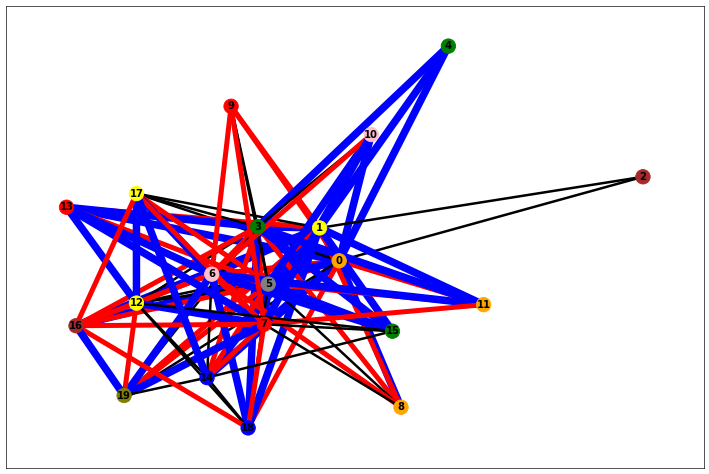

In [10]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [11]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])

print('Edges: ')
for e in G.edges:
    print(G.edges[e])

<class 'networkx.classes.graph.Graph'>
{0: {1: {'label': 2}, 2: {'label': 0}, 3: {'label': 2}, 4: {'label': 2}, 5: {'label': 1}, 6: {'label': 1}, 7: {'label': 2}, 8: {'label': 2}, 9: {'label': 1}, 10: {'label': 2}, 11: {'label': 1}, 12: {'label': 0}, 13: {'label': 2}, 14: {'label': 2}, 15: {'label': 0}, 16: {'label': 2}, 17: {'label': 0}, 18: {'label': 1}, 19: {'label': 0}}, 1: {0: {'label': 2}, 2: {'label': 0}, 3: {'label': 2}, 4: {'label': 2}, 5: {'label': 2}, 6: {'label': 2}, 7: {'label': 1}, 8: {'label': 1}, 9: {'label': 1}, 10: {'label': 0}, 11: {'label': 2}, 12: {'label': 0}, 13: {'label': 1}, 14: {'label': 2}, 15: {'label': 2}, 16: {'label': 2}, 17: {'label': 0}, 18: {'label': 2}, 19: {'label': 1}}, 2: {0: {'label': 0}, 1: {'label': 0}}, 3: {0: {'label': 2}, 1: {'label': 2}, 4: {'label': 2}, 5: {'label': 0}, 6: {'label': 1}, 7: {'label': 1}, 8: {'label': 1}, 9: {'label': 0}, 10: {'label': 0}, 11: {'label': 2}, 12: {'label': 0}, 13: {'label': 2}, 14: {'label': 1}, 15: {'label': 2

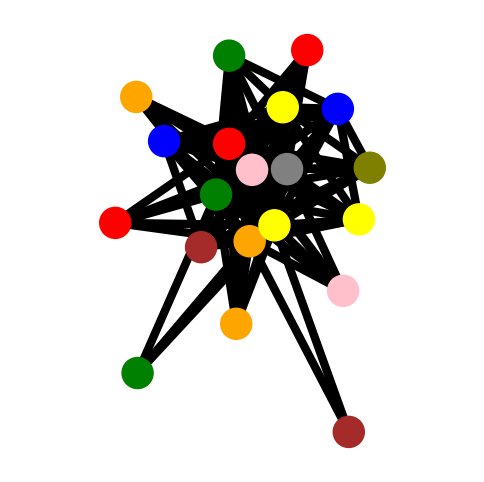

In [12]:
trainer[cls_idx].dataset.draw(G, ax=None)

# Non-Mutagen Class (Class 1)

In [13]:

cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=4),
        dict(key="omega", criterion=NormPenalty(order=2), weight=4),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=30, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [14]:
trainer[cls_idx].train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  0%|          | 1/1000 [00:02<46:47,  2.81s/it, size=101, bpw=1.1, mutagen=-15.3, nonmutagen=19.1]

iteration=0, loss=3691.78, size=100.63219451904297, scores={'mutagen': -15.305439949035645, 'nonmutagen': 19.057573318481445}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  0%|          | 2/1000 [00:04<35:49,  2.15s/it, size=83.4, bpw=1.21, mutagen=-32.2, nonmutagen=31.9]

iteration=1, loss=36422.05, size=83.36978149414062, scores={'mutagen': -32.17395782470703, 'nonmutagen': 31.913009643554688}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  0%|          | 3/1000 [00:05<29:51,  1.80s/it, size=90.4, bpw=1.33, mutagen=-41, nonmutagen=39.9]  

iteration=2, loss=34996.07, size=90.35696411132812, scores={'mutagen': -41.038795471191406, 'nonmutagen': 39.93842315673828}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  0%|          | 4/1000 [00:07<28:37,  1.72s/it, size=81.8, bpw=1.46, mutagen=-46.6, nonmutagen=44.7]

iteration=3, loss=32162.31, size=81.83586883544922, scores={'mutagen': -46.634090423583984, 'nonmutagen': 44.7313117980957}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  0%|          | 5/1000 [00:08<26:18,  1.59s/it, size=87.5, bpw=1.61, mutagen=-46.7, nonmutagen=44.9]

iteration=4, loss=31141.44, size=87.50606536865234, scores={'mutagen': -46.730438232421875, 'nonmutagen': 44.94471740722656}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  1%|          | 6/1000 [00:10<25:12,  1.52s/it, size=78.7, bpw=1.77, mutagen=-48.3, nonmutagen=46.1]

iteration=5, loss=29568.77, size=78.73033905029297, scores={'mutagen': -48.25883483886719, 'nonmutagen': 46.09730529785156}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  1%|          | 7/1000 [00:11<24:10,  1.46s/it, size=86.5, bpw=1.95, mutagen=-39.4, nonmutagen=36.4]

iteration=6, loss=31235.72, size=86.51669311523438, scores={'mutagen': -39.449344635009766, 'nonmutagen': 36.39797592163086}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  1%|          | 8/1000 [00:12<23:36,  1.43s/it, size=74.1, bpw=2.14, mutagen=-44.4, nonmutagen=42.7]

iteration=7, loss=28859.60, size=74.14033508300781, scores={'mutagen': -44.35116958618164, 'nonmutagen': 42.66796875}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  1%|          | 9/1000 [00:14<24:04,  1.46s/it, size=82.3, bpw=2.36, mutagen=-44.4, nonmutagen=42.4]

iteration=8, loss=30133.69, size=82.32221984863281, scores={'mutagen': -44.38245391845703, 'nonmutagen': 42.42960739135742}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  1%|          | 10/1000 [00:15<23:24,  1.42s/it, size=75.2, bpw=2.59, mutagen=-47.8, nonmutagen=46.2]

iteration=9, loss=29385.22, size=75.16673278808594, scores={'mutagen': -47.8153190612793, 'nonmutagen': 46.19037628173828}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  1%|          | 11/1000 [00:17<23:48,  1.44s/it, size=77.9, bpw=2.85, mutagen=-42.1, nonmutagen=38.7]

iteration=10, loss=26176.25, size=77.87220001220703, scores={'mutagen': -42.10676574707031, 'nonmutagen': 38.704254150390625}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  1%|          | 12/1000 [00:18<23:13,  1.41s/it, size=83, bpw=3.14, mutagen=-40.8, nonmutagen=38.2]  

iteration=11, loss=21142.33, size=83.03485870361328, scores={'mutagen': -40.83372497558594, 'nonmutagen': 38.17535400390625}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  1%|▏         | 13/1000 [00:20<23:27,  1.43s/it, size=74.8, bpw=3.45, mutagen=-41.9, nonmutagen=39.9]

iteration=12, loss=21706.60, size=74.78641510009766, scores={'mutagen': -41.93044662475586, 'nonmutagen': 39.89755630493164}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  1%|▏         | 14/1000 [00:21<23:05,  1.41s/it, size=78.5, bpw=3.8, mutagen=-39.5, nonmutagen=36.8] 

iteration=13, loss=21352.35, size=78.53929138183594, scores={'mutagen': -39.45191955566406, 'nonmutagen': 36.830970764160156}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▏         | 15/1000 [00:22<23:22,  1.42s/it, size=76.6, bpw=4.18, mutagen=-36.3, nonmutagen=33.9]

iteration=14, loss=21246.77, size=76.56708526611328, scores={'mutagen': -36.257362365722656, 'nonmutagen': 33.9235954284668}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  2%|▏         | 16/1000 [00:24<23:25,  1.43s/it, size=81.6, bpw=4.59, mutagen=-40, nonmutagen=35.9]  

iteration=15, loss=19867.90, size=81.6468505859375, scores={'mutagen': -39.98476791381836, 'nonmutagen': 35.917354583740234}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▏         | 17/1000 [00:25<23:05,  1.41s/it, size=83.9, bpw=5.05, mutagen=-34.1, nonmutagen=31.2]

iteration=16, loss=17593.79, size=83.86070251464844, scores={'mutagen': -34.08564758300781, 'nonmutagen': 31.242830276489258}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  2%|▏         | 18/1000 [00:27<23:28,  1.43s/it, size=81.6, bpw=5.56, mutagen=-37.7, nonmutagen=34.7]

iteration=17, loss=17461.23, size=81.57019805908203, scores={'mutagen': -37.6782341003418, 'nonmutagen': 34.71946716308594}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▏         | 19/1000 [00:28<22:48,  1.40s/it, size=84.7, bpw=6.12, mutagen=-35.7, nonmutagen=33.3]

iteration=18, loss=18850.17, size=84.68592834472656, scores={'mutagen': -35.74144744873047, 'nonmutagen': 33.30445098876953}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  2%|▏         | 20/1000 [00:29<22:24,  1.37s/it, size=86, bpw=6.73, mutagen=-42.1, nonmutagen=39.4]  

iteration=19, loss=19338.45, size=86.02117919921875, scores={'mutagen': -42.112754821777344, 'nonmutagen': 39.4085578918457}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▏         | 21/1000 [00:31<22:28,  1.38s/it, size=90.3, bpw=7.4, mutagen=-37.7, nonmutagen=34.9]

iteration=20, loss=18395.31, size=90.29470825195312, scores={'mutagen': -37.73558807373047, 'nonmutagen': 34.90483856201172}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  2%|▏         | 22/1000 [00:32<23:14,  1.43s/it, size=87.6, bpw=8.14, mutagen=-39.2, nonmutagen=37.2]

iteration=21, loss=16971.14, size=87.59017181396484, scores={'mutagen': -39.217708587646484, 'nonmutagen': 37.23845672607422}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▏         | 23/1000 [00:34<23:26,  1.44s/it, size=89.2, bpw=8.95, mutagen=-40.6, nonmutagen=38.3]

iteration=22, loss=16252.61, size=89.16090393066406, scores={'mutagen': -40.56352233886719, 'nonmutagen': 38.25803756713867}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  2%|▏         | 24/1000 [00:35<22:52,  1.41s/it, size=87.9, bpw=9.85, mutagen=-37.4, nonmutagen=35.9]

iteration=23, loss=16310.23, size=87.92733001708984, scores={'mutagen': -37.402862548828125, 'nonmutagen': 35.86751937866211}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  2%|▎         | 25/1000 [00:37<23:13,  1.43s/it, size=89.1, bpw=10.8, mutagen=-39.6, nonmutagen=38.2]

iteration=24, loss=16898.35, size=89.13035583496094, scores={'mutagen': -39.56507110595703, 'nonmutagen': 38.21022415161133}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  3%|▎         | 26/1000 [00:38<23:16,  1.43s/it, size=83.7, bpw=11.9, mutagen=-42.3, nonmutagen=40.5]

iteration=25, loss=16932.25, size=83.73847961425781, scores={'mutagen': -42.28805923461914, 'nonmutagen': 40.47410583496094}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  3%|▎         | 27/1000 [00:39<22:36,  1.39s/it, size=85.3, bpw=13.1, mutagen=-35.2, nonmutagen=32.9]

iteration=26, loss=16480.56, size=85.30528259277344, scores={'mutagen': -35.15768814086914, 'nonmutagen': 32.880977630615234}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  3%|▎         | 28/1000 [00:41<22:47,  1.41s/it, size=86.4, bpw=14.4, mutagen=-38.1, nonmutagen=35]  

iteration=27, loss=16022.87, size=86.43930053710938, scores={'mutagen': -38.065792083740234, 'nonmutagen': 35.03488540649414}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  3%|▎         | 29/1000 [00:42<22:34,  1.39s/it, size=86.4, bpw=15.9, mutagen=-39.4, nonmutagen=37.3]

iteration=28, loss=16232.60, size=86.40910339355469, scores={'mutagen': -39.36613845825195, 'nonmutagen': 37.28681182861328}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  3%|▎         | 30/1000 [00:43<22:02,  1.36s/it, size=82.9, bpw=17.4, mutagen=-39, nonmutagen=36.6]  

iteration=29, loss=17154.65, size=82.85747528076172, scores={'mutagen': -39.028465270996094, 'nonmutagen': 36.580604553222656}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  3%|▎         | 31/1000 [00:45<22:44,  1.41s/it, size=83.7, bpw=19.2, mutagen=-35.3, nonmutagen=32.6]

iteration=30, loss=16707.72, size=83.73080444335938, scores={'mutagen': -35.2546272277832, 'nonmutagen': 32.60921859741211}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  3%|▎         | 32/1000 [00:46<22:05,  1.37s/it, size=78.9, bpw=21.1, mutagen=-35.2, nonmutagen=32.9]

iteration=31, loss=15950.67, size=78.94239807128906, scores={'mutagen': -35.24166488647461, 'nonmutagen': 32.903751373291016}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  3%|▎         | 33/1000 [00:48<22:03,  1.37s/it, size=79.2, bpw=23.2, mutagen=-33.3, nonmutagen=31.1]

iteration=32, loss=16059.12, size=79.19575500488281, scores={'mutagen': -33.3078727722168, 'nonmutagen': 31.105398178100586}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  3%|▎         | 34/1000 [00:49<22:11,  1.38s/it, size=79.6, bpw=25.5, mutagen=-35.9, nonmutagen=33]  

iteration=33, loss=16567.78, size=79.56950378417969, scores={'mutagen': -35.89185333251953, 'nonmutagen': 33.04477310180664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▎         | 35/1000 [00:50<21:48,  1.36s/it, size=76.4, bpw=28.1, mutagen=-35.5, nonmutagen=32.8]

iteration=34, loss=16808.57, size=76.42621612548828, scores={'mutagen': -35.508060455322266, 'nonmutagen': 32.83633804321289}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  4%|▎         | 36/1000 [00:52<21:31,  1.34s/it, size=78.9, bpw=30.9, mutagen=-32.6, nonmutagen=30.1]

iteration=35, loss=16609.64, size=78.91002655029297, scores={'mutagen': -32.62605285644531, 'nonmutagen': 30.114778518676758}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▎         | 37/1000 [00:53<21:20,  1.33s/it, size=81, bpw=34, mutagen=-30.4, nonmutagen=27.6]    

iteration=36, loss=16043.82, size=80.99813079833984, scores={'mutagen': -30.399118423461914, 'nonmutagen': 27.62310218811035}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  4%|▍         | 38/1000 [00:54<21:32,  1.34s/it, size=79.9, bpw=37.4, mutagen=-33.3, nonmutagen=30.7]

iteration=37, loss=15419.49, size=79.91230010986328, scores={'mutagen': -33.31158447265625, 'nonmutagen': 30.718217849731445}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▍         | 39/1000 [00:56<21:23,  1.34s/it, size=79.1, bpw=41.1, mutagen=-32.9, nonmutagen=30.4]

iteration=38, loss=15408.59, size=79.06391906738281, scores={'mutagen': -32.906280517578125, 'nonmutagen': 30.36943817138672}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  4%|▍         | 40/1000 [00:57<21:47,  1.36s/it, size=82.3, bpw=45.3, mutagen=-36, nonmutagen=33.9]  

iteration=39, loss=16230.92, size=82.25390625, scores={'mutagen': -36.030548095703125, 'nonmutagen': 33.93898010253906}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▍         | 41/1000 [00:58<21:32,  1.35s/it, size=80.7, bpw=49.8, mutagen=-39.6, nonmutagen=37.6]

iteration=40, loss=18326.25, size=80.69717407226562, scores={'mutagen': -39.638919830322266, 'nonmutagen': 37.643680572509766}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  4%|▍         | 42/1000 [01:00<22:13,  1.39s/it, size=78.8, bpw=54.8, mutagen=-37.6, nonmutagen=35.4]

iteration=41, loss=18671.45, size=78.76514434814453, scores={'mutagen': -37.580894470214844, 'nonmutagen': 35.4256477355957}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▍         | 43/1000 [01:01<22:46,  1.43s/it, size=77.7, bpw=60.2, mutagen=-33.1, nonmutagen=30.6]

iteration=42, loss=19483.76, size=77.72933959960938, scores={'mutagen': -33.07712936401367, 'nonmutagen': 30.627519607543945}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  4%|▍         | 44/1000 [01:03<22:20,  1.40s/it, size=76.2, bpw=66.3, mutagen=-32.8, nonmutagen=30.2]

iteration=43, loss=19645.59, size=76.2339096069336, scores={'mutagen': -32.84999084472656, 'nonmutagen': 30.202373504638672}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  4%|▍         | 45/1000 [01:04<22:01,  1.38s/it, size=77.7, bpw=72.9, mutagen=-34.2, nonmutagen=31.3]

iteration=44, loss=19344.50, size=77.66494750976562, scores={'mutagen': -34.24811935424805, 'nonmutagen': 31.263957977294922}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  5%|▍         | 46/1000 [01:05<21:51,  1.37s/it, size=76.7, bpw=80.2, mutagen=-33.5, nonmutagen=30.7]

iteration=45, loss=18553.15, size=76.67853546142578, scores={'mutagen': -33.52656936645508, 'nonmutagen': 30.66634178161621}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  5%|▍         | 47/1000 [01:07<21:48,  1.37s/it, size=76.8, bpw=88.2, mutagen=-29.6, nonmutagen=27.2]

iteration=46, loss=17825.15, size=76.8017578125, scores={'mutagen': -29.57387924194336, 'nonmutagen': 27.20455551147461}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  5%|▍         | 48/1000 [01:08<21:31,  1.36s/it, size=76.3, bpw=97, mutagen=-34.2, nonmutagen=31.7]  

iteration=47, loss=18016.54, size=76.28408813476562, scores={'mutagen': -34.16905212402344, 'nonmutagen': 31.710330963134766}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  5%|▍         | 49/1000 [01:09<21:27,  1.35s/it, size=75.9, bpw=107, mutagen=-31.2, nonmutagen=28.7]

iteration=48, loss=18760.48, size=75.85484313964844, scores={'mutagen': -31.22368049621582, 'nonmutagen': 28.666982650756836}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  5%|▌         | 50/1000 [01:11<21:24,  1.35s/it, size=76.4, bpw=117, mutagen=-32.2, nonmutagen=29.6]

iteration=49, loss=20438.98, size=76.44886779785156, scores={'mutagen': -32.15263748168945, 'nonmutagen': 29.595767974853516}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  5%|▌         | 51/1000 [01:12<21:23,  1.35s/it, size=77.6, bpw=129, mutagen=-32.8, nonmutagen=30.6]

iteration=50, loss=22103.07, size=77.60411071777344, scores={'mutagen': -32.78801345825195, 'nonmutagen': 30.63249397277832}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  5%|▌         | 52/1000 [01:13<21:21,  1.35s/it, size=77.2, bpw=142, mutagen=-34.2, nonmutagen=31.8]

iteration=51, loss=23847.18, size=77.16763305664062, scores={'mutagen': -34.235252380371094, 'nonmutagen': 31.767101287841797}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  5%|▌         | 53/1000 [01:15<21:15,  1.35s/it, size=72.8, bpw=156, mutagen=-32.8, nonmutagen=30]  

iteration=52, loss=23753.59, size=72.81137084960938, scores={'mutagen': -32.830135345458984, 'nonmutagen': 30.042892456054688}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  5%|▌         | 54/1000 [01:16<21:02,  1.33s/it, size=75, bpw=172, mutagen=-35.5, nonmutagen=32.4]

iteration=53, loss=24420.28, size=74.95148468017578, scores={'mutagen': -35.54539489746094, 'nonmutagen': 32.405250549316406}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▌         | 55/1000 [01:17<21:08,  1.34s/it, size=73.1, bpw=189, mutagen=-32.9, nonmutagen=30.3]

iteration=54, loss=25443.07, size=73.12236022949219, scores={'mutagen': -32.934242248535156, 'nonmutagen': 30.286243438720703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  6%|▌         | 56/1000 [01:19<21:27,  1.36s/it, size=70.2, bpw=208, mutagen=-34.5, nonmutagen=31.9]

iteration=55, loss=25165.48, size=70.24344635009766, scores={'mutagen': -34.49118423461914, 'nonmutagen': 31.88253402709961}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▌         | 57/1000 [01:20<21:55,  1.39s/it, size=65.7, bpw=229, mutagen=-32.5, nonmutagen=30]  

iteration=56, loss=26447.11, size=65.66777038574219, scores={'mutagen': -32.49878692626953, 'nonmutagen': 30.01455307006836}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  6%|▌         | 58/1000 [01:22<22:03,  1.41s/it, size=67.9, bpw=252, mutagen=-30.3, nonmutagen=27.7]

iteration=57, loss=28748.69, size=67.8917236328125, scores={'mutagen': -30.272216796875, 'nonmutagen': 27.664873123168945}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▌         | 59/1000 [01:23<21:57,  1.40s/it, size=66.5, bpw=277, mutagen=-33, nonmutagen=29.3]  

iteration=58, loss=28235.09, size=66.4996337890625, scores={'mutagen': -33.01430892944336, 'nonmutagen': 29.250459671020508}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  6%|▌         | 60/1000 [01:25<21:59,  1.40s/it, size=62.9, bpw=304, mutagen=-33, nonmutagen=31]  

iteration=59, loss=31289.36, size=62.93279266357422, scores={'mutagen': -33.01460266113281, 'nonmutagen': 30.964128494262695}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▌         | 61/1000 [01:26<23:14,  1.49s/it, size=57, bpw=335, mutagen=-30.9, nonmutagen=29]

iteration=60, loss=30661.80, size=56.962303161621094, scores={'mutagen': -30.90928840637207, 'nonmutagen': 29.039249420166016}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  6%|▌         | 62/1000 [01:28<22:55,  1.47s/it, size=53.7, bpw=368, mutagen=-31.8, nonmutagen=28]

iteration=61, loss=30974.75, size=53.68931198120117, scores={'mutagen': -31.7862491607666, 'nonmutagen': 28.037492752075195}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▋         | 63/1000 [01:29<22:18,  1.43s/it, size=52.1, bpw=405, mutagen=-28.1, nonmutagen=25]

iteration=62, loss=29758.29, size=52.11245346069336, scores={'mutagen': -28.069480895996094, 'nonmutagen': 25.01226806640625}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  6%|▋         | 64/1000 [01:30<22:05,  1.42s/it, size=49.9, bpw=446, mutagen=-27, nonmutagen=23.5]

iteration=63, loss=29776.32, size=49.91583251953125, scores={'mutagen': -27.01028060913086, 'nonmutagen': 23.536184310913086}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  6%|▋         | 65/1000 [01:32<21:35,  1.39s/it, size=43.7, bpw=490, mutagen=-28.2, nonmutagen=25.2]

iteration=64, loss=29441.26, size=43.72788619995117, scores={'mutagen': -28.207509994506836, 'nonmutagen': 25.232553482055664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>


  7%|▋         | 66/1000 [01:33<21:39,  1.39s/it, size=37.3, bpw=539, mutagen=-24.5, nonmutagen=21.1]

iteration=65, loss=29899.12, size=37.255104064941406, scores={'mutagen': -24.522214889526367, 'nonmutagen': 21.10756492614746}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e50cbf10>


  7%|▋         | 67/1000 [01:35<22:05,  1.42s/it, size=27.7, bpw=593, mutagen=-23, nonmutagen=18.7]  

iteration=66, loss=28880.91, size=27.726436614990234, scores={'mutagen': -22.965547561645508, 'nonmutagen': 18.734281539916992}


  7%|▋         | 67/1000 [01:36<22:19,  1.44s/it, size=27.7, bpw=593, mutagen=-23, nonmutagen=18.7]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f55e4f95e40>
Expected number of edges of sample: 27.726436614990234; Budget: 30
Current explanation has high prediction probability and low expected maximum number of edges. Hence, it is a good explanation.
Breaking from train loop!



True

n=17 m=27
logits=[-19.424633026123047, 10.758039474487305]
probs=[7.795282838283721e-14, 1.0]
Graph Viz info: 
No of nodes:  17
Nodes:  [(0, {'label': 'N', 'color': 'orange'}), (2, {'label': 'F', 'color': 'purple'}), (4, {'label': 'P', 'color': 'black'}), (6, {'label': 'F', 'color': 'purple'}), (11, {'label': 'Li', 'color': 'olive'}), (12, {'label': 'P', 'color': 'black'}), (14, {'label': 'O', 'color': 'blue'}), (15, {'label': 'Na', 'color': 'cyan'}), (18, {'label': 'F', 'color': 'purple'}), (19, {'label': 'F', 'color': 'purple'}), (1, {'label': 'K', 'color': 'magenta'}), (7, {'label': 'O', 'color': 'blue'}), (13, {'label': 'I', 'color': 'gray'}), (16, {'label': 'K', 'color': 'magenta'}), (3, {'label': 'K', 'color': 'magenta'}), (8, {'label': 'N', 'color': 'orange'}), (9, {'label': 'C', 'color': 'red'})]
No of edges:  27
Edges:  [(0, 2, {'label': 'single', 'color': 'black', 'width': 3}), (0, 4, {'label': 'triple', 'color': 'blue', 'width': 9}), (0, 6, {'label': 'double', 'color': 'red'

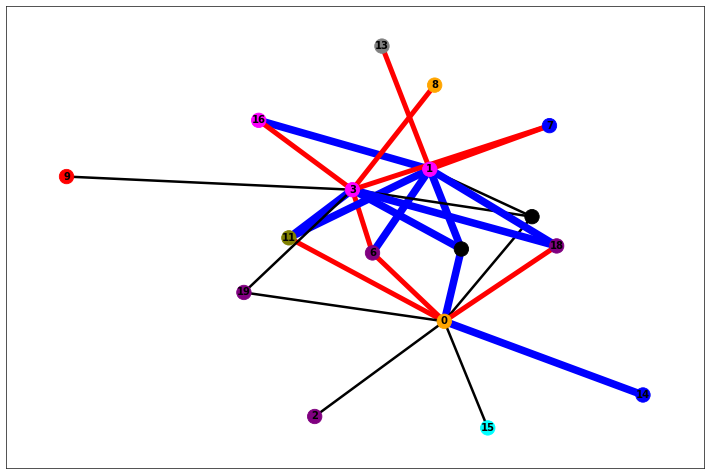

In [15]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [16]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])
    
print('Edges: ')
for e in G.edges:
    print(G.edges[e])

<class 'networkx.classes.graph.Graph'>
{0: {2: {'label': 0}, 4: {'label': 2}, 6: {'label': 1}, 11: {'label': 1}, 12: {'label': 0}, 14: {'label': 2}, 15: {'label': 0}, 18: {'label': 1}, 19: {'label': 0}}, 2: {0: {'label': 0}}, 4: {0: {'label': 2}, 1: {'label': 2}, 3: {'label': 2}}, 6: {0: {'label': 1}, 1: {'label': 2}, 3: {'label': 1}}, 11: {0: {'label': 1}, 1: {'label': 2}, 3: {'label': 2}}, 12: {0: {'label': 0}, 1: {'label': 0}, 3: {'label': 0}}, 14: {0: {'label': 2}}, 15: {0: {'label': 0}}, 18: {0: {'label': 1}, 1: {'label': 2}, 3: {'label': 2}}, 19: {0: {'label': 0}, 3: {'label': 0}}, 1: {4: {'label': 2}, 6: {'label': 2}, 7: {'label': 1}, 11: {'label': 2}, 12: {'label': 0}, 13: {'label': 1}, 16: {'label': 2}, 18: {'label': 2}}, 7: {1: {'label': 1}, 3: {'label': 1}}, 13: {1: {'label': 1}}, 16: {1: {'label': 2}, 3: {'label': 1}}, 3: {4: {'label': 2}, 6: {'label': 1}, 7: {'label': 1}, 8: {'label': 1}, 9: {'label': 0}, 11: {'label': 2}, 12: {'label': 0}, 16: {'label': 1}, 18: {'label': 

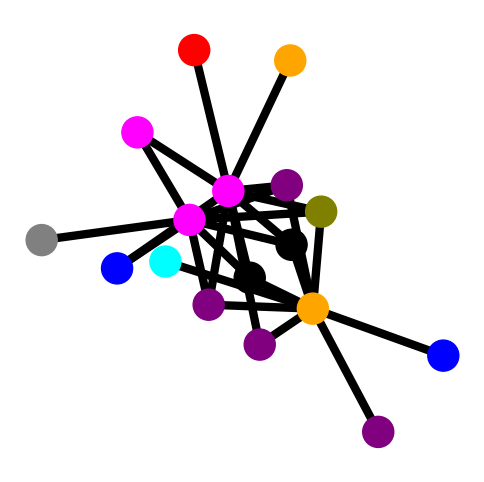

In [17]:
trainer[cls_idx].dataset.draw(G, ax=None)